# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>
 
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
___

# INTRODUCTION


## Business Problem

COVID-19 vaccines became available to subsets of the American public at the end of 2020. States and cities differed in terms of which groups of people were eligible first, and the timeline by which they expanded eligibility, but [by April 19th](https://www.nytimes.com/2021/04/19/world/adults-eligible-covid-vaccine.html), all Americans over the age of 16 were eligible.

Appointment availability was initially scarce in some places, but this very quickly shifted to a growing number of appointments going unfilled across the country. [Only 59% of adults have received at least one dose](https://covid.cdc.gov/covid-data-tracker/#datatracker-home) (as of this writing, on May 14th, 2021), so there are still plenty of people who haven't received any doses.

Vaccination rate is an important metric being considered as state and local governments decide how and when to relax mask-wearing, occupancy, and other COVID restrictions. These entities are already wondering about the best methods to encourage their populations to get vaccinated. In order to develop effective strategies, state and local governments need to understand the factors that contribute to vaccine hesitancy. 

To aid in this understanding, I will build a predictive model to classify whether someone is likely to be vaccine optimistic, or vaccine hesitant, based on their other answers to the Household Pulse Survey that the US Census has been conducting bi-weekly during the pandemic. Interpreting the factors which are most important in predicting vaccine hesitancy among populations should provide insights that will allow state and local governments to develop effective outreach strategies.




# OBTAIN

## Data Understanding

For this analysis, I will use a [publicly available microdata sample](https://www.census.gov/programs-surveys/household-pulse-survey/datasets.html) from the bi-weekly Household Pulse Surveys that the US Census has been conducting during the pandemic. Each observation represents an individual's anonymized response to the survey.

Respondents were randomly sampled from all 50 states and the top 15 metropolitan areas, and asked to fill out the survey online. They were asked a variety of questions about their household, including whether they've received any doses of the vaccine, and if not, what their intent was to do so in the future. I will engineer these features into a binary target variable representing vaccine optimism versus vaccine hesitancy, and use each respondent's answers to other survey questions as the predictors.

Some survey questions were only presented to the respondent if they answered a certain way to a prior question, such as only asking about intention to get a vaccine in the future if the respondent indicated they had not yet received any doses. I will carefully review the data dictionary provided by the Census team to understand these relationships, and  engineer features from the groups of questions as appropriate.

I will use the most recent microdata file available as of this writing, May 14, 2021, which includes a sample of about 78,000 responses from Phase 3 of the survey, covering the timeframe of March 3 to March 15, 2021. This is referred to as the "week 26" period.  Note that the survey is ongoing and currently in Phase 3.1, but microdata is not yet available for the first week of Phase 3.1, so I will use the most recent data available.

For more technical information on the sampling methodology and full questionnaire, [see here](https://www.census.gov/programs-surveys/household-pulse-survey/technical-documentation.html).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import missingno
import plotly.express as px
import dstools

pd.set_option('display.max_info_rows', 300)
pd.set_option('display.max_info_columns', 300)

%autoreload 2

In [2]:
# import data from downloaded CSV
df = pd.read_csv(r"data/pulse2021_puf_26.csv.tar.gz")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78307 entries, 0 to 78306
Data columns (total 204 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   ._pulse2021_puf_26.csv  object 
 1   WEEK                    float64
 2   EST_ST                  float64
 3   EST_MSA                 float64
 4   REGION                  float64
 5   HWEIGHT                 float64
 6   PWEIGHT                 float64
 7   TBIRTH_YEAR             float64
 8   ABIRTH_YEAR             float64
 9   EGENDER                 float64
 10  AGENDER                 float64
 11  RHISPANIC               float64
 12  AHISPANIC               float64
 13  RRACE                   float64
 14  ARACE                   float64
 15  EEDUC                   float64
 16  AEDUC                   float64
 17  MS                      float64
 18  THHLD_NUMPER            float64
 19  AHHLD_NUMPER            float64
 20  THHLD_NUMKID            float64
 21  AHHLD_NUMKID            float64
 2

I will primarily use the data dictionary provided by the Census team to determine which fields to include in my initial model.

Although all the data fields are stored as floats, based on the dictionary most of them are actually ordinally encoded categorical variables. I will need to combine them or convert them to text categories as appropriate.

# SCRUB

I will need to engineer multiple features, including my target. As written and organized into a question per column, the data is not in ideal format for analysis due to the presence of main question and sub-question groups; some questions are conceptually spread across multiple columns.

I will endeavor to balance reducing the feature space with keeping as much of the original information as possible.

One notable challenge will be dealing with missing data. The data dictionary indicates that there are two placeholders that represent a non-answer: 
- -88: Missing / Did not report
- -99: Question seen but category not selected

The Census team provides no additional information about why a response might be missing and placed in the -88 category as opposed to the -99 category that represents a lack of a response from the respondent. I have reached out to them via email for explanation, but have not yet heard back. Although some instances appear to be filled in to account for the fact that a sub-question wasn't presented to a respondent because of how they answered a prior question, there are some columns with -88 placeholders that do not appear to be sub-questions, so in my understanding should have been presented to everyone. 

Since there are a significant number of these -88 placeholders in some top-level question columns, I will likely encode them as a separate category instead of dropping them or attempting to impute them.

## Target columns

I want to create a binary target that represents a respondent's vaccine outlook: hesitant, or optimistic.

I will need to engineer this target from two questions: 
- `RECVDVACC` asked the respondent whether they have received any doses of the COVID vaccine
- `GETVACC` is a sub-question asked of the respondent if they said they had not received any doses. It asked about the respondent's intent to get a vaccine in the future. Choices include:

1. Definitely get a vaccine
2. Probably get a vaccine
3. Probably NOT get a vaccine 
4. Definitely NOT get a vaccine

At the time of the survey back in early March, only certain subsets of the population were eligible to make a vaccine appointment, based on state-specific criteria such as age, occupation, health risk indicators, and other factors. I want to make sure my class takes into account people who have been vaccinated but doesn't penalize people who have not yet been vaccinated yet, given there is no easy way to know if they were eligible for vaccination when they were surveyed. 

I will create the binary target by combining answers to these two questions in the following way:

**Vaccine optimistic**
- Has received at least one dose OR
- Has not received any doses yet AND:
    - Intends to Definitely get a vaccine OR
    - Intends to Probably get a vaccine

**Vaccine hesitant**
- Has not received any doses yet AND:
    - Intends to Probably NOT get a vaccine OR
    - Intends to Definitely NOT get a vaccine


In [3]:
# First question asking whether they have received any doses
df['RECVDVACC'].value_counts()

 2.0     42085
 1.0     35840
-99.0      381
Name: RECVDVACC, dtype: int64

In [4]:
df['RECVDVACC'].isna().sum()

1

In [5]:
df.loc[df['RECVDVACC'].isna()]

,._pulse2021_puf_26.csv,WEEK,EST_ST,EST_MSA,REGION,HWEIGHT,PWEIGHT,TBIRTH_YEAR,ABIRTH_YEAR,EGENDER,...,PSWHYCHG1,PSWHYCHG2,PSWHYCHG3,PSWHYCHG4,PSWHYCHG5,PSWHYCHG6,PSWHYCHG7,PSWHYCHG8,PSWHYCHG9,INCOME
78306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- Value of 1 indicates Yes, at least one dose
- Value of 2 indicates No, no doses yet
- Value of -99 indicates the respondent did not answer the question

I will drop the -99 values, since there are few of them and I wouldn't be comfortable imputing target variables.

In [6]:
to_drop = df.loc[df['RECVDVACC'] == -99.0].index
df.drop(index=to_drop, inplace=True)

df['RECVDVACC'].value_counts()

2.0    42085
1.0    35840
Name: RECVDVACC, dtype: int64

It looks like there was an extra blank line at the end of the file that is NaN for all values, so I'll remove that too.

In [7]:
df.dropna(axis=0, how='all', inplace=True)

In [8]:
df['GETVACC'].value_counts()

-88.0    35840
 1.0     24576
 2.0      7904
 3.0      5271
 4.0      4234
-99.0      100
Name: GETVACC, dtype: int64

In [9]:
df['GETVACC'].isna().sum()

0

This question was only asked of respondents who said they had not received any doses yet.

- Value of 1 indicates will Definitely get a vaccine
- Value of 2 indicates will Probably get a vaccine
- Value of 3 indicates will Probably NOT get a vaccine 
- Value of 4 indicates will Definitely NOT get a vaccine
- Value of -99 indicates the respondent did not answer the question

A value of -88 is described as simply missing in the data dictionary. In this case, we know that this question was asked of a subset of people who sad they hadn't received any doses, and the count of value -88 in this question matches the count of 1 - Yes in the previous question.

I will confirm that these -88 placeholders represent people who received a dose of the vaccine.

In [10]:
# Do 'GETVACC' values of -88 also have 'RECVDVACC' values of 1?
df.loc[df['GETVACC'] == -88.0]['RECVDVACC'].value_counts()

1.0    35840
Name: RECVDVACC, dtype: int64

Yes, all the -88 values from the second question are people who answered Yes (1.0) in the first question.

I will drop the -99 values to the second question since they are also very small in size. Then I will create a binary target based on the logic outlined in the header section above.

In [11]:
# drop -99 values, where the respondent didn't answer the question
to_drop = df.loc[df['GETVACC'] == -99.0].index
df.drop(index=to_drop, inplace=True)

# Target class 0 will be vaccine optimistic
df.loc[(df['RECVDVACC'] == 1.0) | 
       (df['GETVACC'] == 1.0) | 
       (df['GETVACC'] == 2.0), 'target'] = 0

# Target class 1 will be vaccine hesitant
df.loc[(df['GETVACC'] == 3.0) | 
       (df['GETVACC'] == 4.0), 'target'] = 1

df['target'].value_counts()

0.0    68320
1.0     9505
Name: target, dtype: int64

In [12]:
df['target'].value_counts(normalize=True)

0.0    0.877867
1.0    0.122133
Name: target, dtype: float64

In [13]:
df['target'].isna().sum()

0

## Predictor Columns

I used the data dictionary provided by the Census as the primary method of determining which columns were categorical versus numeric, and which I wanted to use versus leave out of the initial exploration. A copy of the data dictionary is provided in the data folder.

Many of the questions asked in this survey involve potentially sensitive topics, such as race, financial circumstances, participation level in social assistance programs, household spending habits, aspects of mental health, etc. I will therefore do my utmost to apply consistent, objective criteria regarding which columns to include or remove in the model to avoid unintentional personal bias, and will provide detail regarding each of these tactical decisions.

### Initial Columns to Exclude

As a first pass, I identified the following characteristics of columns in the data set that led me to decide to exclude them in the initial exploration and likely from the model.

#### Subquestions

Certain questions were asked of respondents only if they answered in a certain way to a prior question. One example would be the set of `WHYCHNGD` subquestions asking WHY household spending had changed, which were only presented to respondents who said their household spending HAD changed.

I think these subquestions will be very useful in understanding more nuance about the opinions and circumstances of households, if the primary question turns out to be an important predictor of vaccine hesitancy. However, I will include only the top-level questions in the modeling process.

Fields that represent subquestions (based on the data dictionary), and will be excluded from initial analysis are:

- WHYNOT1
- WHYNOT2
- WHYNOT3
- WHYNOT4
- WHYNOT5
- WHYNOT6
- WHYNOT7
- WHYNOT8
- WHYNOT9
- WHYNOT10
- WHYNOT11
- WHYNOTB1
- WHYNOTB2
- WHYNOTB3
- WHYNOTB4
- WHYNOTB5
- WHYNOTB6
- RSNNOWRK
- SSAPGM1
- SSAPGM2
- SSAPGM3
- SSAPGM4
- SSAPGM5
- SSALIKELY
- SSAEXPCT1
- SSAEXPCT2
- SSAEXPCT3
- SSAEXPCT4
- SSAEXPCT5
- SSADECISN
- EIPSPND1
- EIPSPND2
- EIPSPND3
- EIPSPND4
- EIPSPND5
- EIPSPND6
- EIPSPND7
- EIPSPND8
- EIPSPND9
- EIPSPND10
- EIPSPND11
- EIPSPND12
- EIPSPND13
- WHYCHNGD1
- WHYCHNGD2
- WHYCHNGD3
- WHYCHNGD4
- WHYCHNGD5
- WHYCHNGD6
- WHYCHNGD7
- WHYCHNGD8
- WHYCHNGD9
- WHYCHNGD10
- WHYCHNGD11
- WHYCHNGD12
- WHYCHNGD13
- CHILDFOOD
- FOODSUFRSN1
- FOODSUFRSN2
- FOODSUFRSN3
- FOODSUFRSN4
- FOODSUFRSN5
- WHEREFREE1
- WHEREFREE2
- WHEREFREE3
- WHEREFREE4
- WHEREFREE5
- WHEREFREE6
- WHEREFREE7
- RENTCUR
- MORTCUR
- MORTCONF
- EVICT
- FORCLOSE
- TEACH1
- TEACH2
- TEACH3
- TEACH4
- TEACH5
- COMPAVAIL
- COMP1
- COMP2
- COMP3
- INTRNTAVAIL
- INTRNT1
- INTRNT2
- INTRNT3
- KINDWORK
- SCHLHRS
- TSTDY_HRS
- TCH_HRS
- PSPLANS1
- PSPLANS2
- PSPLANS3
- PSPLANS4
- PSPLANS5
- PSPLANS6
- PSCHNG1
- PSCHNG2
- PSCHNG3
- PSCHNG4
- PSCHNG5
- PSCHNG6
- PSCHNG7
- PSWHYCHG1
- PSWHYCHG2
- PSWHYCHG3
- PSWHYCHG4
- PSWHYCHG5
- PSWHYCHG6
- PSWHYCHG7
- PSWHYCHG8
- PSWHYCHG9
- DOSES

#### Duplicates, Metadata, and Imputed values

Several columns were already imputed into appropriate summary columns by the Census Bureau, which means the original columns are essentially duplicates:

- THHLD_NUMPER
- PRIVHLTH
- PUBHLTH

The REGION column will also not be included, as the dataset contains other columns that can be used to represent geographical characteristics, such as State and Metropolitan Area.

A few columns represent metadata such as household identifier, and weight calculations to be used to generate population statistics:

- SCRAM
- PWEIGHT
- HWEIGHT
- WEEK

The following columns are indicators that a value was imputed by the Census team:

- ABIRTH_YEAR
- AGENDER
- AHISPANIC
- ARACE
- AEDUC
- AHHLD_NUMPER
- AHHLD_NUMKID

### Categories to Engineer

Some categorical columns are likely candidates to be engineered into a single column, such as reducing respondent's answers to different types of health insurance they have into a single column representing whether they have health insurance or not.

I can't be sure yet whether these features will perform better in their original state, or if my engineer feature will capture the important information. I'll create them where they make sense for now, and will be able to model either or both versions.

In [14]:
# See values in HLTHINS columns
hlth_cols = ['HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 
             'HLTHINS6', 'HLTHINS7', 'HLTHINS8']

for col in hlth_cols:
    print(df[col].value_counts(1))

 1.0     0.534623
 2.0     0.262987
-88.0    0.169663
-99.0    0.032727
Name: HLTHINS1, dtype: float64
 2.0     0.537861
 1.0     0.194064
-88.0    0.169663
-99.0    0.098413
Name: HLTHINS2, dtype: float64
 2.0     0.494982
 1.0     0.257861
-88.0    0.169663
-99.0    0.077494
Name: HLTHINS3, dtype: float64
 2.0     0.626637
-88.0    0.169663
-99.0    0.118484
 1.0     0.085217
Name: HLTHINS4, dtype: float64
 2.0     0.667086
-88.0    0.169663
-99.0    0.124664
 1.0     0.038587
Name: HLTHINS5, dtype: float64
 2.0     0.661934
-88.0    0.169663
-99.0    0.129213
 1.0     0.039190
Name: HLTHINS6, dtype: float64
 2.0     0.685744
-88.0    0.169663
-99.0    0.137347
 1.0     0.007247
Name: HLTHINS7, dtype: float64
 2.0     0.628050
-88.0    0.169663
-99.0    0.163996
 1.0     0.038291
Name: HLTHINS8, dtype: float64


In [15]:
# Combine HLTHINS multi-choice answers to represent has insurance or not

# Assign 1 if any health insurance option chosen
df.loc[(df['HLTHINS1']==1)|(df['HLTHINS2']==1)|(df['HLTHINS3']==1)|
       (df['HLTHINS4']==1)|(df['HLTHINS5']==1)|(df['HLTHINS6']==1)|
       (df['HLTHINS7']==1)|(df['HLTHINS8']==1), ['HLTHINS']] = 1

# Assign 0 if No seleted for all
df.loc[(df['HLTHINS1']==2)&(df['HLTHINS2']==2)&(df['HLTHINS3']==2)&
       (df['HLTHINS4']==2)&(df['HLTHINS5']==2)&(df['HLTHINS6']==2)&
       (df['HLTHINS7']==2)&(df['HLTHINS8']==2), ['HLTHINS']] = 0

# Assign 0 if No seleted for all
df.loc[(df['HLTHINS1']==-99)&(df['HLTHINS2']==-99)&(df['HLTHINS3']==-99)&
       (df['HLTHINS4']==-99)&(df['HLTHINS5']==-99)&(df['HLTHINS6']==-99)&
       (df['HLTHINS7']==-99)&(df['HLTHINS8']==-99), ['HLTHINS']] = -99

# Assign 0 if No seleted for all
df.loc[(df['HLTHINS1']==-88)&(df['HLTHINS2']==-88)&(df['HLTHINS3']==-88)&
       (df['HLTHINS4']==-88)&(df['HLTHINS5']==-88)&(df['HLTHINS6']==-88)&
       (df['HLTHINS7']==-88)&(df['HLTHINS8']==-88), ['HLTHINS']] = -88

print(df['HLTHINS'].isna().sum())
df['HLTHINS'].value_counts()

451


 1.0     61184
-88.0    13204
 0.0      2653
-99.0      333
Name: HLTHINS, dtype: int64

In [16]:
df.loc[df['HLTHINS'].isna(), hlth_cols]

,HLTHINS1,HLTHINS2,HLTHINS3,HLTHINS4,HLTHINS5,HLTHINS6,HLTHINS7,HLTHINS8
235,2.0,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
299,2.0,2.0,2.0,2.0,2.0,2.0,-99.0,-99.0
490,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
558,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-99.0
604,2.0,2.0,2.0,2.0,2.0,2.0,2.0,-99.0
...,...,...,...,...,...,...,...,...
77636,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
77848,2.0,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
77877,2.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0,-99.0
77976,-99.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0


In [17]:
# Assign the remaining records to 0, since it looks like respondents
# started marking them all No but didn't mark each 
df.loc[df['HLTHINS'].isna(), 'HLTHINS'] = 0

In [18]:
# Create a single categorical column for children enrolled in school outside
# the home

# Assign 1 if have any children enrolled in school outside the home
df.loc[(df['ENROLL1']==1), ['SCHOOL_KIDS']] = 1

# Assign 0 if have ONLY children who are being homeschooled
df.loc[(df['ENROLL2']==1) & (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = 0

# Assign 3 if indicated did NOT have children enrolled in school
df.loc[(df['ENROLL3']==1) & (df['SCHOOL_KIDS'].isna()), ['SCHOOL_KIDS']] = 0

# Assign 0 if did not answer; assume this means they don't have kids of
# school age
df.loc[df['SCHOOL_KIDS'].isna(), ['SCHOOL_KIDS']] = 0

df['SCHOOL_KIDS'].value_counts()

0.0    63559
1.0    14266
Name: SCHOOL_KIDS, dtype: int64

In [19]:
# Combine TSPNDPRPD and TSPNDFOOD into a single column representing the
# proportion of money spent on food that was on food to be eaten at home
# TSPNDPRPD is amount spent on prepared meals
# TSPNDFOOD is amount spent on food to be prepared at home

# if respondent entered one food amount but not the other, assume they left
# the other blank because it should be 0
df.loc[(df['TSPNDPRPD'] < 0) & (df['TSPNDFOOD'] >0), 'TSPNDPRPD'] = 0
df.loc[(df['TSPNDPRPD'] > 0) & (df['TSPNDFOOD'] <0), 'TSPNDFOOD'] = 0

# Only calculate if respondent included an answer for one
ans = df.loc[(df['TSPNDPRPD'] >0) | (df['TSPNDFOOD'] >0), ['TSPNDPRPD', 'TSPNDFOOD']]
ans.head()

,TSPNDPRPD,TSPNDFOOD
1,50.0,200.0
3,0.0,300.0
4,210.0,100.0
5,200.0,200.0
6,0.0,40.0


In [20]:
# Populate proportion of food spend that was on food to be prepared
# at home
ans['PROP_FOODSPEND_HOME'] = ans.apply(lambda x: x[1]/np.sum(x), axis=1)
ans.head()

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
1,50.0,200.0,0.800000
3,0.0,300.0,1.000000
4,210.0,100.0,0.322581
5,200.0,200.0,0.500000
6,0.0,40.0,1.000000


In [21]:
# merge results back into main df
df = df.merge(right=ans['PROP_FOODSPEND_HOME'], how='left', 
         left_on=df.index, right_on=ans.index)

df[['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']].head(20)

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
0,-88.0,-88.0,NaN
1,50.0,200.0,0.800000
2,-88.0,-88.0,NaN
3,0.0,300.0,1.000000
4,210.0,100.0,0.322581
5,200.0,200.0,0.500000
6,0.0,40.0,1.000000
7,0.0,800.0,1.000000
8,8.0,84.0,0.913043
9,25.0,120.0,0.827586


In [22]:
# Insert appropriate -99 and -88 values, so can assess -88s in bulk
# with other columns later
df.loc[(df['TSPNDPRPD'] ==-88) & (df['TSPNDFOOD'] ==-88), 'PROP_FOODSPEND_HOME'] = -88
df.loc[(df['TSPNDPRPD'] ==-99) & (df['TSPNDFOOD'] ==-99), 'PROP_FOODSPEND_HOME'] = -99

In [23]:
df.loc[df['PROP_FOODSPEND_HOME'].isna(), ['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']]

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME
64,0.0,0.0,NaN
191,0.0,-99.0,NaN
284,0.0,0.0,NaN
287,0.0,0.0,NaN
388,-88.0,-99.0,NaN
...,...,...,...
77416,0.0,0.0,NaN
77439,-88.0,-99.0,NaN
77656,-88.0,-99.0,NaN
77680,0.0,-99.0,NaN


In [24]:
# For the ones where people put 0 for both, going to fill in with 0
df.loc[(df['TSPNDPRPD'] ==0) & (df['TSPNDFOOD'] ==0) & 
       (df['PROP_FOODSPEND_HOME'].isna()), 'PROP_FOODSPEND_HOME'] = 0

# For the rest of the nas, put -99
df.loc[df['PROP_FOODSPEND_HOME'].isna(), 'PROP_FOODSPEND_HOME'] = -99

df.loc[df['PROP_FOODSPEND_HOME'].isna(), ['TSPNDPRPD','TSPNDFOOD','PROP_FOODSPEND_HOME']]

,TSPNDPRPD,TSPNDFOOD,PROP_FOODSPEND_HOME


In [25]:
df['PROP_FOODSPEND_HOME'].describe()

count    77825.000000
mean       -15.693697
std         35.134390
min        -99.000000
25%          0.462366
50%          0.714286
75%          0.877193
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64

In [26]:
# Create column to represent whether household was in a metropolitan statistical
# area or not

df.loc[df['EST_MSA'] > 0, 'IN_METRO_AREA'] = 1
df.loc[df['IN_METRO_AREA'].isna(), 'IN_METRO_AREA'] = 0

df.loc[df['EST_MSA'].isna(), 'EST_MSA'] = 0

print(df['IN_METRO_AREA'].isna().sum())
df['IN_METRO_AREA'].value_counts()

0


0.0    51865
1.0    25960
Name: IN_METRO_AREA, dtype: int64

In [27]:
# convert -99 values to 0 in columns that represent checkboxes that are
# part of a larger multiple choice question
# This essentially OHE's them, except there are some values with -88
# which appear to be mising across the board

multichoice_cols = ['SPNDSRC1','SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5',
                    'SPNDSRC6','SPNDSRC7','SPNDSRC8','CHNGHOW1','CHNGHOW2',
                    'CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6','CHNGHOW7',
                    'CHNGHOW8','CHNGHOW9','CHNGHOW10','CHNGHOW11','CHNGHOW12']

for col in multichoice_cols:
    df.loc[df[col] == -99, col] = 0
    
df[multichoice_cols].head(20)

,SPNDSRC1,SPNDSRC2,SPNDSRC3,SPNDSRC4,SPNDSRC5,SPNDSRC6,SPNDSRC7,SPNDSRC8,CHNGHOW1,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,CHNGHOW7,CHNGHOW8,CHNGHOW9,CHNGHOW10,CHNGHOW11,CHNGHOW12
0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0,-88.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0
6,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
8,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [28]:
# Convert birth year to age
df['AGE'] = df['TBIRTH_YEAR'].map(lambda x: 2021-x)

df['AGE'].describe()

count    77825.000000
mean        54.562159
std         15.898557
min         18.000000
25%         42.000000
50%         56.000000
75%         67.000000
max         88.000000
Name: AGE, dtype: float64

In [29]:
df['AGE'].isna().sum()

0

In [30]:
# Running list of the categorical and numeric column names, both engineered
# and original

cat_cols = ['HLTHINS', 'SCHOOL_KIDS', 'IN_METRO_AREA', 'ANXIOUS','ANYWORK',
            'CHNGHOW1','CHNGHOW10','CHNGHOW11','CHNGHOW12','CHNGHOW2',
            'CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6','CHNGHOW7','CHNGHOW8',
            'CHNGHOW9','CURFOODSUF','DELAY','DOWN','EEDUC','EGENDER','EIP',
            'EXPCTLOSS','EXPNS_DIF','FEWRTRANS','FEWRTRIPS','FREEFOOD',
            'HADCOVID','INCOME','INTEREST','LIVQTR','MH_NOTGET','MH_SVCS',
            'MS','NOTGET','PLNDTRIPS','PRESCRIPT','RHISPANIC','RRACE',
            'SNAP_YN','SPNDSRC1','SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5',
            'SPNDSRC6','SPNDSRC7','SPNDSRC8','SSA_APPLY','SSA_RECV','TENURE',
            'TW_START','UI_APPLY','UI_RECV','WORRY','WRKLOSS','HLTHINS1', 
            'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 
            'HLTHINS7', 'HLTHINS8', 'ENROLL1', 'ENROLL2', 'ENROLL3', 'EST_MSA']

cat_cols.sort()

num_cols = ['PROP_FOODSPEND_HOME', 'AGE', 'THHLD_NUMADLT','THHLD_NUMKID',
            'TNUM_PS']



In [31]:
for col in cat_cols:
    print(df[col].value_counts(1))

 1.0     0.351044
 2.0     0.261022
-88.0    0.162082
 4.0     0.129007
 3.0     0.092168
-99.0    0.004677
Name: ANXIOUS, dtype: float64
 1.0     0.568789
 2.0     0.428037
-99.0    0.003174
Name: ANYWORK, dtype: float64
 0.0     0.497783
 1.0     0.448159
-88.0    0.054057
Name: CHNGHOW1, dtype: float64
 0.0     0.884022
 1.0     0.061921
-88.0    0.054057
Name: CHNGHOW10, dtype: float64
 0.0     0.925782
-88.0    0.054057
 1.0     0.020161
Name: CHNGHOW11, dtype: float64
 0.0     0.700405
 1.0     0.245538
-88.0    0.054057
Name: CHNGHOW12, dtype: float64
 0.0     0.725255
 1.0     0.220687
-88.0    0.054057
Name: CHNGHOW2, dtype: float64
 0.0     0.873228
 1.0     0.072714
-88.0    0.054057
Name: CHNGHOW3, dtype: float64
 0.0     0.661022
 1.0     0.284921
-88.0    0.054057
Name: CHNGHOW4, dtype: float64
 0.0     0.913935
-88.0    0.054057
 1.0     0.032008
Name: CHNGHOW5, dtype: float64
 0.0     0.474513
 1.0     0.471429
-88.0    0.054057
Name: CHNGHOW6, dtype: float64
 0.0     0

In [32]:
for col in num_cols:
    print(df[col].isna().sum())
    print(df[col].describe())

0
count    77825.000000
mean       -15.693697
std         35.134390
min        -99.000000
25%          0.462366
50%          0.714286
75%          0.877193
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64
0
count    77825.000000
mean        54.562159
std         15.898557
min         18.000000
25%         42.000000
50%         56.000000
75%         67.000000
max         88.000000
Name: AGE, dtype: float64
0
count    77825.000000
mean         2.122981
std          0.966851
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max         10.000000
Name: THHLD_NUMADLT, dtype: float64
0
count    77825.000000
mean         0.588024
std          1.010032
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          5.000000
Name: THHLD_NUMKID, dtype: float64
0
count    77825.000000
mean       -19.387189
std         37.068353
min        -99.000000
25%          0.000000
50%          0.000000
75%          0.

Of the columns I initially had listed as categorical, I used the value counts above, combined with reviewing the meanings of each label in the data dictionary, to make further decisions on each column.

- Many of these columns are almost already OHE. There are already only 2 choices, mostly Yes/No answers, but a few others such as gender Male/Female. 
    - Many of the Yes/No questions actually have Yes encoded as 1 and No encoded as 2, so I'm going to mass replace those with 0 instead of 2 to be more consistent with how OHE typically works.
    - A few can be turned into OHE columns if I combine rare labels.


- A few categorical columns are suited to be left as ordinals and treated like numbers. These columns are:
    - `ANXIOUS`, `DOWN`, `INTEREST` (lack of), and `WORRY`: as value increases, frequency of experiencing these feelings increases.
    - `CURFOODSUF`: as value increases, food insecurity increases / food suffiency decreases.
    - `EEDUC`: as value increases, education level represented by years of schooling required to obtain that level increases.
    - `EXPNS_DIF`: as value increases, difficulty with expenses increases
    - `INCOME`: as value increases, pre-tax income range increases
    
    
- Some categorical columns do need to be OHE because they have more than two choices that can't be combined without losing information.


- I will drop `UI_RECV` because the vast majority of its values are -88 missing, so it has little to contribute in terms of actual answers the respondents provided.

Almost all of the columns have -99 values that represent the respondent skipped the question, and -88 values that are simply missing with no explanation. Before accepting that I need to make 2 separate columns for every one of these (expanding my feature space by a lot) I'm going to map them using missingno and see if I can identify patterns. Maybe values that are -88 across multiple columns can be bundled together in fewer missing indicator columns.

Of the numerical columns, I will turn `TNUM_PS` into a Yes/No categorical column, since it appears most households have no one who was planning on post-secondary education in fall 2021. I don't think the number of people will make a big difference.

In [33]:
# for columns that really only have 2 answers, most are 1 and 2. Leave 1 as Yes
# and convert the 2s to 0s for Nos or second value.

conv_2_to_0 = ['ANYWORK', 'DELAY', 'EGENDER', 'EXPCTLOSS', 'FEWRTRIPS', 
               'FREEFOOD', 'HADCOVID', 'MH_NOTGET', 'MH_SVCS', 'NOTGET', 
               'PLNDTRIPS','PRESCRIPT', 'SNAP_YN', 'SSA_APPLY', 'SSA_RECV', 
               'UI_APPLY', 'WRKLOSS', 'HLTHINS1', 'HLTHINS2', 'HLTHINS3', 
               'HLTHINS4', 'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8']

for col in conv_2_to_0:
    df.loc[df[col] == 2, col] = 0
    print(df[col].value_counts())

 1.0     44266
 0.0     33312
-99.0      247
Name: ANYWORK, dtype: int64
 0.0     46448
 1.0     17044
-88.0    13906
-99.0      427
Name: DELAY, dtype: int64
0.0    46326
1.0    31499
Name: EGENDER, dtype: int64
 0.0     66184
 1.0     11349
-99.0      292
Name: EXPCTLOSS, dtype: int64
 1.0     42247
 0.0     27499
-88.0     7438
-99.0      641
Name: FEWRTRIPS, dtype: int64
 0.0     64839
-88.0     8032
 1.0      4592
-99.0      362
Name: FREEFOOD, dtype: int64
 0.0     68660
 1.0      8527
 3.0       514
-99.0      124
Name: HADCOVID, dtype: int64
 0.0     56873
-88.0    13906
 1.0      6658
-99.0      388
Name: MH_NOTGET, dtype: int64
 0.0     56552
-88.0    13906
 1.0      6911
-99.0      456
Name: MH_SVCS, dtype: int64
 0.0     51332
-88.0    13906
 1.0     12182
-99.0      405
Name: NOTGET, dtype: int64
 1.0     55601
 0.0     14386
-88.0     7438
-99.0      400
Name: PLNDTRIPS, dtype: int64
 0.0     49248
 1.0     14233
-88.0    13906
-99.0      438
Name: PRESCRIPT, dtype: int64

In [34]:
# OHE HADCOVID by combining rare label 3 - Not Sure with -99 No Answer
df.loc[df['HADCOVID']==3, 'HADCOVID'] = -99
df['HADCOVID'].value_counts()

 0.0     68660
 1.0      8527
-99.0      638
Name: HADCOVID, dtype: int64

In [35]:
# Make RHISPANIC consistent with 0=No, 1=Yes
df.loc[df['RHISPANIC']==1, 'RHISPANIC'] = 0
df.loc[df['RHISPANIC']==2, 'RHISPANIC'] = 1
df['RHISPANIC'].value_counts()

0.0    70428
1.0     7397
Name: RHISPANIC, dtype: int64

In [36]:
# TW_Start labels 2 and 3 are both no telework, so converting to 0
df.loc[(df['TW_START']==2)|(df['TW_START']==3), 'TW_START'] = 0
df['TW_START'].value_counts()

 0.0     42009
 1.0     32097
-99.0     3719
Name: TW_START, dtype: int64

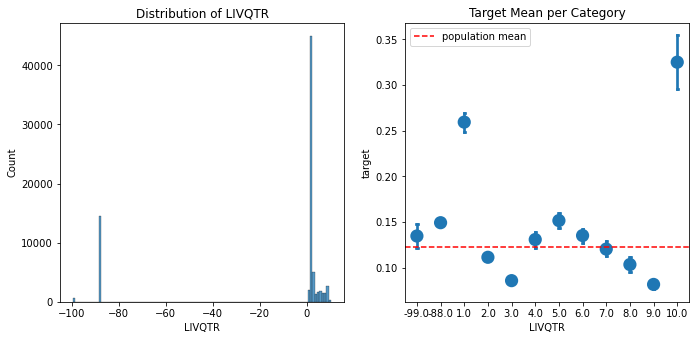

In [37]:
dstools.explore_data_catbin(['LIVQTR'], df, 'target')

In [38]:
# LIVQTR will need to be OHE, but I can combine some labels and not lose
# much information

df['LIVQTR'].value_counts()

 2.0     44955
-88.0    14502
 3.0      4975
 9.0      2730
 1.0      1921
 6.0      1746
 5.0      1729
 7.0      1562
 8.0      1479
 4.0      1254
-99.0      698
 10.0      274
Name: LIVQTR, dtype: int64

Category labels from the data dictionary:
1. A mobile home
2. A one-family house detached from any other house
3. A one-family house attached to one or more houses
4. A building with 2 apartments
5. A building with 3 or 4 apartment
6. A building with 5 to 9 apartments
7. A building with 10 to 19 apartments
8. A building with 20 to 49 apartments 
9. A building with 50 or more apartments
10. Boat, RV, van, etc.

-99. Question seen but category not selected

-88. Missing / Did not report

I will combine these 10 categories into 4:
- 1) Mobile home
- 2 and 3 -> 2) House
- 4 through 9 -> 3) Apartment
- 10 -> 4) Boat, RV, van


In [39]:
df.loc[df['LIVQTR']==1, 'LIVQTR_2'] = 1
df.loc[df['LIVQTR'].isin([2, 3]), 'LIVQTR_2'] = 2
df.loc[df['LIVQTR'].isin([4,5,6,7,8,9]), 'LIVQTR_2'] = 3
df.loc[df['LIVQTR']==10, 'LIVQTR_2'] = 4

In [40]:
df['LIVQTR_2'].value_counts()

2.0    49930
3.0    10500
1.0     1921
4.0      274
Name: LIVQTR_2, dtype: int64

In [41]:
df['LIVQTR_2'].isna().sum()

15200

In [42]:
df.loc[df['LIVQTR']==-88, 'LIVQTR_2'] = -88
df.loc[df['LIVQTR']==-99, 'LIVQTR_2'] = -99
print(df['LIVQTR_2'].value_counts())
df['LIVQTR_2'].isna().sum()

 2.0     49930
-88.0    14502
 3.0     10500
 1.0      1921
-99.0      698
 4.0       274
Name: LIVQTR_2, dtype: int64


0

In [43]:
# Combine a few rare Married Status labels
# Adding 3 - divorced and 4 - separated into 2 - Widowed (all sound single now
# but used to be married)
# 1 is married, and 5 is never married

df.loc[df['MS']==1, 'MS_2'] = 1
df.loc[df['MS'].isin([2, 3, 4]), 'MS_2'] = 2
df.loc[df['MS']==5, 'MS_2'] = 3
df.loc[df['MS']==-88, 'MS_2'] = -88
df.loc[df['MS']==-99, 'MS_2'] = -99
print(df['MS_2'].value_counts())
df['MS_2'].isna().sum()

 1.0     45740
 2.0     17835
 3.0     13762
-99.0      488
Name: MS_2, dtype: int64


0

In [44]:
# OHE TNUM_PS manually
df['TNUM_PS'].value_counts()

 0.0     45969
-88.0    15652
 1.0     10678
 2.0      3138
-99.0     1525
 3.0       863
Name: TNUM_PS, dtype: int64

In [45]:
# These represent the number of people in the household who plan to go to
# post-secondary classes in 2021. Since there aren't a lot of 2 and 3 values,
# will combine them into 1 so it's just a Yes have people who plan to take
# PS classes, or No have none in the household.
df['TNUM_PS_2'] = df['TNUM_PS']
df.loc[df['TNUM_PS_2'].isin([2, 3]), 'TNUM_PS_2'] = 1

df['TNUM_PS_2'].value_counts()

 0.0     45969
-88.0    15652
 1.0     14679
-99.0     1525
Name: TNUM_PS_2, dtype: int64

In [46]:
# drop UI_RECV from cat_cols, as majority of values are -88 missing
df['UI_RECV'].value_counts(normalize=True)

-88.0    0.847941
 1.0     0.121825
 2.0     0.027857
-99.0    0.002377
Name: UI_RECV, dtype: float64

In [47]:
cat_cols.remove('UI_RECV')

cat_cols.append('MS_2')
cat_cols.append('LIVQTR_2')
cat_cols.append('TNUM_PS_2')

## Review Locations of -88 Missing
There are some sets of predictor columns that seem to have the same number of -88 values. I have reached out to the Census team to determine what this indicates, but they have not yet responded.

I will try to visualize these to see if there are patterns. Perhaps I can use combine missing indicator columns.

In [48]:
# columns, in question order

q_order = ['TBIRTH_YEAR','EGENDER','RHISPANIC','RRACE','EEDUC','MS',
           'THHLD_NUMKID','THHLD_NUMADLT','RECVDVACC','HADCOVID',
           'WRKLOSS','EXPCTLOSS','ANYWORK','TW_START','UI_APPLY','UI_RECV',
           'SSA_RECV','SSA_APPLY','EIP','EXPNS_DIF','SPNDSRC1',
           'SPNDSRC2','SPNDSRC3','SPNDSRC4','SPNDSRC5','SPNDSRC6','SPNDSRC7',
           'SPNDSRC8','FEWRTRIPS','FEWRTRANS','PLNDTRIPS','CURFOODSUF',
           'FREEFOOD','SNAP_YN','TSPNDFOOD','TSPNDPRPD','ANXIOUS','WORRY',
           'INTEREST','DOWN','HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 
           'HLTHINS5', 'HLTHINS6', 'HLTHINS7', 'HLTHINS8','DELAY','NOTGET',
           'PRESCRIPT','MH_SVCS','MH_NOTGET','TENURE','LIVQTR','ENROLL1',
           'ENROLL2','ENROLL3','TNUM_PS','INCOME']

In [49]:
# create a copy of the columns so I can replace -88 with nulls and visualize
nan_viz = df[q_order].copy()
print(list(nan_viz.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [50]:
# replace -88s with nans
nan_viz.replace(-88, np.nan, inplace=True)
print(list(nan_viz.isna().sum()))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 197, 65991, 519, 795, 2212, 2915, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7438, 7771, 8032, 8195, 10775, 11054, 12614, 12614, 12614, 12614, 13204, 13204, 13204, 13204, 13204, 13204, 13204, 13204, 13906, 13906, 13906, 13906, 13906, 14502, 14502, 57437, 57437, 57437, 15652, 16311]


<AxesSubplot:>

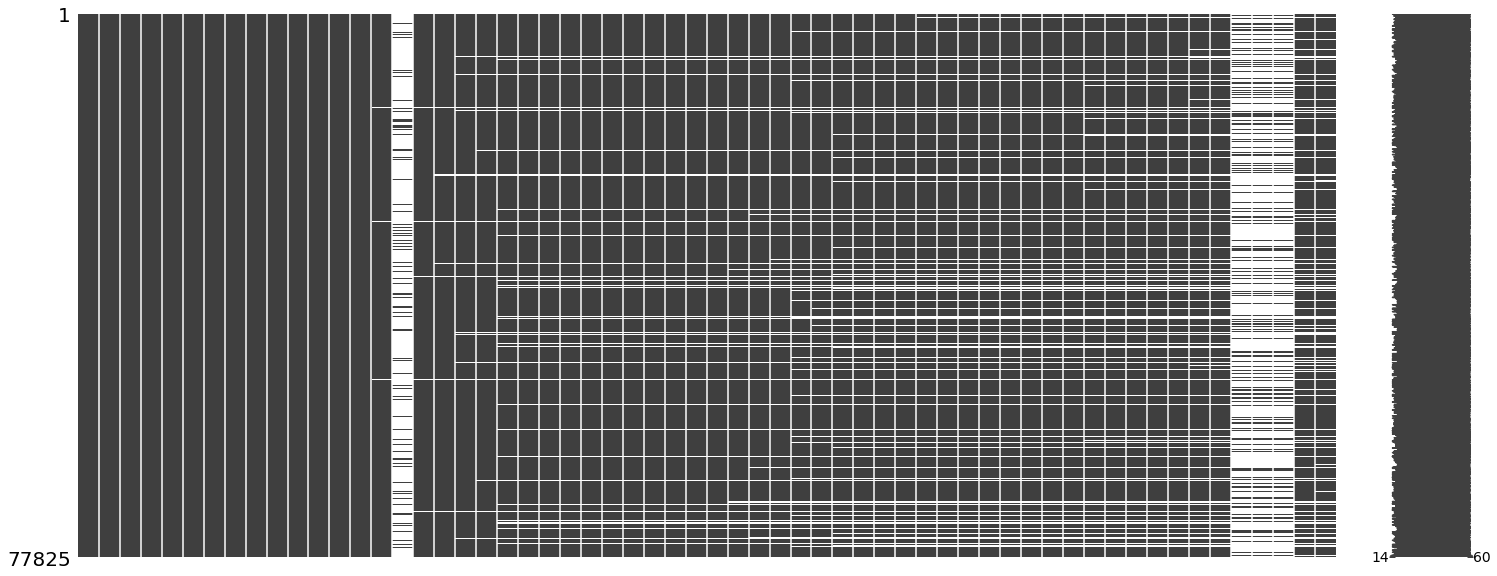

In [51]:
missingno.matrix(nan_viz)

Hmm, when I look at them in the order the questions were presented, I see that with the exception of a few columns that have a lot of nans, once missing answers start showing up, the rest of that record has missing answers.

**I suspect that the -88 Missing placeholder indicates that the respondent exited the questionnaire prematurely, and Census kept the incomplete answers in the sample.**

After re-reviewing the technical documentation, I found this paragraph buried towards the end:

>Responses are made up of complete interviews and sufficient partial interviews. A sufficient partial interview is an incomplete interview in which the household or person answered enough of the questionnaire to be considered a complete interview. Some remaining questions may have been edited or imputed to fill in missing values. Insufficient partial interviews are considered to be nonrespondents.

But there are a few columns that stand out as having a lot of -88 values and aren't following this pattern. I would like to look further into those before deciding how to proceed.

In [52]:
missing_sum = nan_viz.isna().sum(axis=0)
missing_sum.loc[q_order]

TBIRTH_YEAR          0
EGENDER              0
RHISPANIC            0
RRACE                0
EEDUC                0
MS                   0
THHLD_NUMKID         0
THHLD_NUMADLT        0
RECVDVACC            0
HADCOVID             0
WRKLOSS              0
EXPCTLOSS            0
ANYWORK              0
TW_START             0
UI_APPLY           197
UI_RECV          65991
SSA_RECV           519
SSA_APPLY          795
EIP               2212
EXPNS_DIF         2915
SPNDSRC1          7438
SPNDSRC2          7438
SPNDSRC3          7438
SPNDSRC4          7438
SPNDSRC5          7438
SPNDSRC6          7438
SPNDSRC7          7438
SPNDSRC8          7438
FEWRTRIPS         7438
FEWRTRANS         7438
PLNDTRIPS         7438
CURFOODSUF        7771
FREEFOOD          8032
SNAP_YN           8195
TSPNDFOOD        10775
TSPNDPRPD        11054
ANXIOUS          12614
WORRY            12614
INTEREST         12614
DOWN             12614
HLTHINS1         13204
HLTHINS2         13204
HLTHINS3         13204
HLTHINS4   

It looks like the four columns that don't fit the pattern are `UI_RECV`, `ENROLL1`, `ENROLL2`, and `ENROLL3`.

The data dictionary says that both of these questions were presented to everyone, but let me do some digging and see if perhaps the -88 count corresponds to the count of people who answered a certain way to a previous, related question.

In [53]:
df['UI_APPLY'].value_counts()

 0.0     65536
 1.0     11875
-99.0      217
-88.0      197
Name: UI_APPLY, dtype: int64

In [54]:
df['UI_RECV'].value_counts()

-88.0    65991
 1.0      9481
 2.0      2168
-99.0      185
Name: UI_RECV, dtype: int64

In [55]:
# What is the sum of people who answered No (0) or didn't answer 'UI_APPLY'?
print(65536 + 217 + 197)

65950


That's pretty darn close. I'm thinking 'UI_RECV' was only presented to people who said they actually applied for unemployment benefits.

In [56]:
# ENROLL1, ENROLL2, and ENROLL1 would only apply to households who said they
# had kids under 18
print(df['ENROLL1'].value_counts())
print(df['ENROLL2'].value_counts())
print(df['ENROLL3'].value_counts())

-88.0    57437
 1.0     14266
-99.0     6122
Name: ENROLL1, dtype: int64
-88.0    57437
-99.0    18627
 1.0      1761
Name: ENROLL2, dtype: int64
-88.0    57437
-99.0    15644
 1.0      4744
Name: ENROLL3, dtype: int64


In [57]:
df['THHLD_NUMKID'].value_counts()

0.0    52672
1.0    11499
2.0     8853
3.0     3195
4.0     1057
5.0      549
Name: THHLD_NUMKID, dtype: int64

There's some difference between the 52,672 people who said they didn't have kids in the household in question 8, and the 57,437 people who didn't answer the question about how their kids attended school in question 42. But it looks like a decent amount of people didn't make it that far in the questionnaire, so the ~5k differents could just be that.

## Strategy for Incomplete Questionnaires

I found the section of the technical documentation that says there are incomplete questionnaires, and the patterns I can see in the responses matches that. Now I need to decide whether to simply drop these incomplete answers and use only the complete ones, or account for them in some way.

To decide, I'll take a look at the class distribution for incomplete versus complete questionnaires and see if there appears to be a difference.

In [58]:
q_order.remove('ENROLL1')
q_order.remove('ENROLL2')
q_order.remove('ENROLL3')
q_order.remove('UI_RECV')

In [59]:
# populate incomplete column with sum of -88 values in top-level q columns
def sum_neg88(row):
    missing = row.isin([-88]).sum(axis=0)
    return missing

df['incomplete'] = df[q_order].apply(sum_neg88, axis=1)

df['incomplete']

0        37
1         0
2        39
3         0
4         0
         ..
77820     0
77821     0
77822     0
77823     0
77824     0
Name: incomplete, Length: 77825, dtype: int64

In [60]:
print(list(df[q_order].loc[2]))

[1961.0, 0.0, 0.0, 1.0, 6.0, 1.0, 0.0, 2.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0, -88.0]


In [61]:
# Add 'incomplete' to the list of cat_cols
cat_cols.append('incomplete')

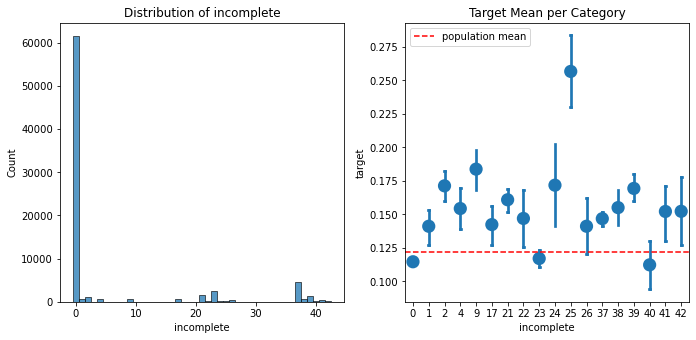

In [62]:
# plot number of incomplete questionnaires against target
dstools.explore_data_catbin(['incomplete'], df, 'target')

Interesting, so there is some variability based on number of questions.

I will create a binary column for 'incomplete' to use as a predictor, which will stand in for all the -88 values in the top-level questions. I'll also keep this numeric column and try both in my model to see which does better.

To make it easy to get rid of the -88 values I will set them equal to the 'first', or lowest value in the column, and when I use sklearn's OneHotEncoder, I will drop the first column.

I will convert -88 to -2 so it will be 'first' and will convert -99, which represents someone viewing but skipping a particular question, as -1.

In [63]:
# Create inc_binary column
df.loc[df['incomplete'] == 0, 'inc_binary'] = 0
df.loc[df['incomplete'] > 0, 'inc_binary'] = 1

df['inc_binary'].value_counts()

0.0    61514
1.0    16311
Name: inc_binary, dtype: int64

In [64]:
df['inc_binary'].isna().sum()

0

I'll do the same thing for -99 values. I'll create a numeric column to indicate the number of skipped questions based on -99, and will also OHE the -99 category for each categorical column so I can try modeling both ways and see which does better.

In [65]:
# populate skipped column with sum of -88 values in top-level q columns
def sum_neg99(row):
    missing = row.isin([-99]).sum(axis=0)
    return missing

df['skipped'] = df[q_order].apply(sum_neg99, axis=1)

df['skipped'].value_counts()

0     54560
1      8389
7      4782
2      2647
6      2188
3      1344
5      1261
4       920
8       758
9       345
10      160
11       70
12       48
13       34
14       32
23       27
21       24
29       23
18       20
17       18
15       17
16       16
19       16
20       15
25       15
22       15
26       12
27        9
30        8
24        7
28        7
39        6
34        6
32        6
31        4
33        3
35        3
36        3
38        3
37        2
40        2
Name: skipped, dtype: int64

In [66]:
# add new columns to lists
num_cols.append('incomplete')
num_cols.append('skipped')
cat_cols.append('inc_binary')

In [67]:
# replace -88 with -2 and -99 with -1 for all cat cols
# I will still need to deal with some missing values in num cols

for col in cat_cols:
    df.loc[df[col] == -88, col] = -2
    df.loc[df[col] == -99, col] = -1

# check for remaining -88 and -99 values
print(list(df[cat_cols].isin([-88, -99]).sum(axis=0)))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [68]:
# take a look at which num cols have -88 or -99 values
df[num_cols].isin([-88, -99]).sum(axis=0)

PROP_FOODSPEND_HOME    14015
AGE                        0
THHLD_NUMADLT              0
THHLD_NUMKID               0
TNUM_PS                17177
incomplete                 0
skipped                    0
dtype: int64

I will need to remember to do something else with these numerical values when I prepare the data for modeling, as they will need to be replaced with something. But for now, so I can chart the columns against the target, I will see if it's safe to assign -2 and -1 to my placeholders. I want to set them on a scale that will work well with the rest of the values when I chart them on a continuous x axis, but also be easy to single out for replacement with something else later.

In [69]:
# are there any values less than 0 other than -88 and -99?
df.loc[df['PROP_FOODSPEND_HOME'] < 0, ['PROP_FOODSPEND_HOME']].value_counts()

PROP_FOODSPEND_HOME
-88.0                  10775
-99.0                   3240
dtype: int64

In [70]:
# are there any values less than 0 other than -88 and -99?
df.loc[df['TNUM_PS'] < 0, ['TNUM_PS']].value_counts()

TNUM_PS
-88.0      15652
-99.0       1525
dtype: int64

In [71]:
# Both columns look fine to replace with -2 and -1
for col in ['TNUM_PS', 'PROP_FOODSPEND_HOME']:
    df.loc[df[col] == -88, col] = -2
    df.loc[df[col] == -99, col] = -1

# EXPLORE
Now I have my predictors fairly cleaned up: some rare labels combined, a better understanding of the -99 (now -1) and -88 (now -2) missing indicators, a few features engineered.

I will visualize each variable's distribution and relationship to the target to see if any need further engineering.

In [72]:
# reset my lists of categorical and numeric columns after engineering
# I'll have a new ordinal list, because they will be treated differently
# in preprocessing

# These are the columns that only have one version
cat_cols = ['ANYWORK','CHNGHOW1','CHNGHOW10','CHNGHOW11','CHNGHOW12',
            'CHNGHOW2','CHNGHOW3','CHNGHOW4','CHNGHOW5','CHNGHOW6',
            'CHNGHOW7','CHNGHOW8','CHNGHOW9','DELAY','EGENDER','EIP',
            'EXPCTLOSS','FEWRTRANS','FEWRTRIPS','FREEFOOD','HADCOVID',
            'MH_NOTGET', 'MH_SVCS','NOTGET','PLNDTRIPS','PRESCRIPT','RHISPANIC',
            'RRACE','SNAP_YN','SPNDSRC1','SPNDSRC2','SPNDSRC3',
            'SPNDSRC4','SPNDSRC5','SPNDSRC6','SPNDSRC7','SPNDSRC8',
            'SSA_APPLY','SSA_RECV','TENURE','TW_START','UI_APPLY','WRKLOSS']

# I engineered versions of these columns, but these are the originals
# They have more rare labels, and provide more detail than the engineered 
# versions
cat_cols_v1 = ['HLTHINS1', 'HLTHINS2', 'HLTHINS3', 'HLTHINS4', 'HLTHINS5', 
               'HLTHINS6', 'HLTHINS7', 'HLTHINS8', 'ENROLL1', 'ENROLL2', 
               'ENROLL3', 'EST_MSA', 'LIVQTR', 'MS']

# These are the engineered versions of the columns that I can try if the
# original versions don't perform well
cat_cols_v2 = ['HLTHINS','inc_binary','IN_METRO_AREA', 'SCHOOL_KIDS', 
               'LIVQTR_2', 'MS_2', 'TNUM_PS_2']

# These are the columns that are categorical, but I think can be treated as
# numbers
ord_cols = ['ANXIOUS','CURFOODSUF','DOWN','EEDUC','EXPNS_DIF','INCOME',
            'INTEREST','WORRY']

# Numeric columns to be run through the 
num_cols = ['THHLD_NUMADLT','THHLD_NUMKID','PROP_FOODSPEND_HOME','AGE', 
            'incomplete', 'TNUM_PS']

# I can try out this column instead of OHE -99 as separate columns
num_cols_v2 = ['skipped']



In [73]:
for col in num_cols:
    print(f"Column {col} has {len(df[col].value_counts())} values.")

Column THHLD_NUMADLT has 10 values.
Column THHLD_NUMKID has 6 values.
Column PROP_FOODSPEND_HOME has 2097 values.
Column AGE has 71 values.
Column incomplete has 18 values.
Column TNUM_PS has 6 values.


I really only have 2 numeric values in terms of how I want to visualize them: `PROP_FOODSPEND_HOME` and `AGE`. The others are numbers but are discrete and have few values.

In [74]:
rerun_viz = False
all_cats = cat_cols + cat_cols_v1 + cat_cols_v2

if rerun_viz:
    dstools.explore_data_catbin(all_cats, df, 'target')

In [75]:
# RRACE category labels are:
#1) White, Alone
#2) Black, Alone
#3) Asian, Alone
#4) Any other race alone, or race in combination

# Are the proportions of respondents similar to population proportions?
df['RRACE'].value_counts(normalize=True)

1.0    0.825609
2.0    0.078073
3.0    0.050434
4.0    0.045885
Name: RRACE, dtype: float64

In [76]:
df['RHISPANIC'].value_counts(normalize=True)

0.0    0.904953
1.0    0.095047
Name: RHISPANIC, dtype: float64

The [2020 Census statistics](https://www.census.gov/quickfacts/fact/table/US/PST045219) report that the US population is about 76% White, 13% Black, and about 6% Asian. About 18% of the population identifies as Hispanic or Latinx.

In this data, White respondents are overrepresented, Black respondents are far underrepresented, Asian respondents are slightly underrepresented, and Hispanic/Latinx respondents are far underrepresented.

## Understanding Categorical Features
Focusing on the actual answers (values of 0 and above):
- Features that don't appear to make much difference on target mean include `SSA_APPLY`, `SPNDSRC` 2, 3, and 7.
- I noticed that a `LVEQTR` value of 1 had a target mean more than double the population mean. I looked back and realized I had combined mobile home with boat/RV/van because both were somewhat rare features. Given how large of a target mean difference I saw, I went back and re-engineered that feature earlier in the notebook to keep them separate, so that 1 = mobile home, and 4 = boat/RV/van.
- `RRACE` has few respondents who are not white. In this data, White respondents are overrepresented, Black and Hispanic/Latinx respondents are far underrepresented, and Asian respondents are slightly underrepresented.
- `SPNDSRC8` value of 1 has a much higher target mean than the population. Looking at that question, it's related to whether the respondent used SNAP funds in the past 7 days. Since I already have a column to indicate SNAP participation, I'll drop this column.

Focusing on the -2 and -1 answers, few respondents opted not to answer any given question. I'm considering whether to do something similar to what I did with Incomplete where I create a single column to represent whether the respondent skipped ANY questions.


In [77]:
cat_cols.remove('SPNDSRC8')

In [78]:
# explore ordinal categorical columns
if rerun_viz:
    dstools.explore_data_catbin(ord_cols + ['THHLD_NUMADLT', 'THHLD_NUMKID'], 
                            df, 'target')

## Understanding Ordinal Categorical Features
Focusing on the actual answers (values of 0 and above):
- `ANXIOUS`, `DOWN`, `INTEREST` and `WORRY` all share a similar pattern. 
    - Responses of 1 (Not at All) are fairly close to the population mean but a bit below
    - Responses of 2 (Several Days) are well below population mean
    - Responses of 3 (More than half the days) are again fairly close to the population mean but a bit above
    - Responses of 4 (Nearly every day) are well above the population mean
    
    I'm not sure I can treat these as numbers, I think I have to OHE them.


- `THHLD_NUMADLT` doesn't appear to have much of a linear relationship with target mean. Most values are pretty close to the mean, and those that appear to deviate have very few observations. I'm going to keep this column, but consolidate the number of adults above 3 with 3.


- The rest of the features do show a linear relationship with the target mean, so I will treat them as numeric columns.

In [79]:
# Combine THHLD_NUMADLT > 3 with 3
df.loc[df['THHLD_NUMADLT'] > 3, 'THHLD_NUMADLT'] = 3
df['THHLD_NUMADLT'].value_counts()

2.0    43223
1.0    17308
3.0    17294
Name: THHLD_NUMADLT, dtype: int64

In [80]:
if rerun_viz:
    dstools.explore_data_catbin(['THHLD_NUMADLT'], df, 'target')

In [81]:
# Reorganize my lists of columns by type, based on what I've learned and updated here
cat_cols = cat_cols + ['ANXIOUS', 'DOWN', 'INTEREST', 'WORRY', 'THHLD_NUMADLT']

for col in ['ANXIOUS', 'DOWN', 'INTEREST', 'WORRY']:
    ord_cols.remove(col)
    
num_cols.remove('THHLD_NUMADLT')

print(cat_cols)
print(ord_cols)
print(num_cols)

['ANYWORK', 'CHNGHOW1', 'CHNGHOW10', 'CHNGHOW11', 'CHNGHOW12', 'CHNGHOW2', 'CHNGHOW3', 'CHNGHOW4', 'CHNGHOW5', 'CHNGHOW6', 'CHNGHOW7', 'CHNGHOW8', 'CHNGHOW9', 'DELAY', 'EGENDER', 'EIP', 'EXPCTLOSS', 'FEWRTRANS', 'FEWRTRIPS', 'FREEFOOD', 'HADCOVID', 'MH_NOTGET', 'MH_SVCS', 'NOTGET', 'PLNDTRIPS', 'PRESCRIPT', 'RHISPANIC', 'RRACE', 'SNAP_YN', 'SPNDSRC1', 'SPNDSRC2', 'SPNDSRC3', 'SPNDSRC4', 'SPNDSRC5', 'SPNDSRC6', 'SPNDSRC7', 'SSA_APPLY', 'SSA_RECV', 'TENURE', 'TW_START', 'UI_APPLY', 'WRKLOSS', 'ANXIOUS', 'DOWN', 'INTEREST', 'WORRY', 'THHLD_NUMADLT']
['CURFOODSUF', 'EEDUC', 'EXPNS_DIF', 'INCOME']
['THHLD_NUMKID', 'PROP_FOODSPEND_HOME', 'AGE', 'incomplete', 'TNUM_PS']


In [82]:
if rerun_viz:
    dstools.explore_data_catbin(num_cols + num_cols_v2, df, 'target', 
                            pred_type='cont')

Looking at AGE, I see the histogram is not smooth, but rather appears to have spikes in certain areas. After reviewing the data dictionary again, I notice there are some columns indicating imputed values for some features. I'd like to understand the proportion of imputed values.

In [83]:
imputed_ind = ['ABIRTH_YEAR','AGENDER','AHISPANIC','ARACE','AEDUC',
           'AHHLD_NUMPER','AHHLD_NUMKID']

for col in imputed_ind:
    print(np.round(df[col].value_counts(normalize=True) * 100, 4))
    print()

2.0    99.5027
1.0     0.4973
Name: ABIRTH_YEAR, dtype: float64

2.0    99.6646
1.0     0.3354
Name: AGENDER, dtype: float64

2.0    97.8901
1.0     2.1099
Name: AHISPANIC, dtype: float64

2.0    97.903
1.0     2.097
Name: ARACE, dtype: float64

2.0    99.7019
1.0     0.2981
Name: AEDUC, dtype: float64

2.0    96.6553
1.0     3.3447
Name: AHHLD_NUMPER, dtype: float64

2.0    98.4041
1.0     1.5959
Name: AHHLD_NUMKID, dtype: float64



None of the percentages of imputed values look too large. I'm comfortable with this.

## Understanding Numeric Features
Focusing on the actual answers (values of 0 and above):
- I don't see much difference in feature distribution of `PROP_FOODSPEND_HOME` for the different target classes 

## Exploring States
I initially chose to leave out the State, as it has a high cardinality. But perhaps a visualization will help me decide if I want to try to include it somehow.


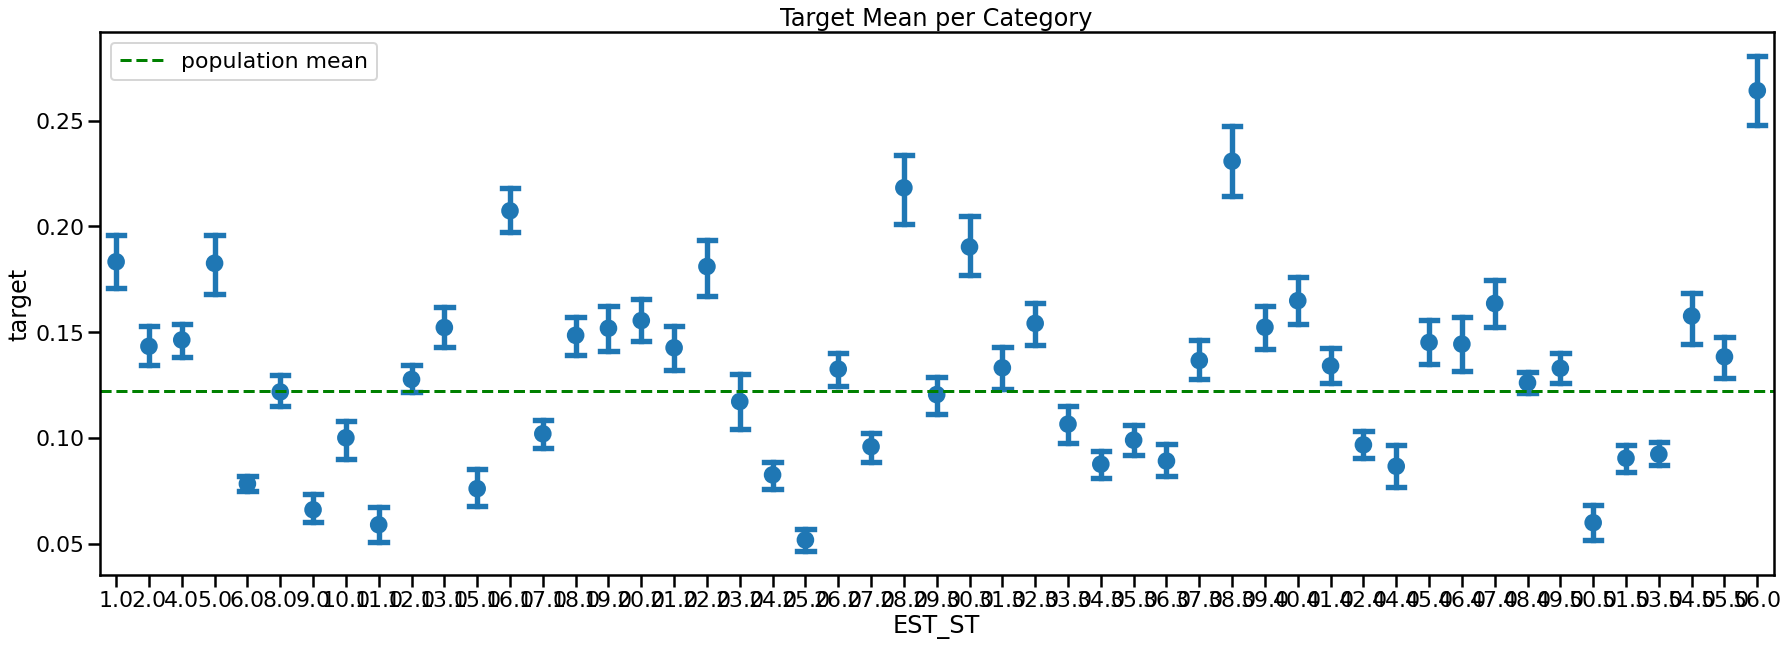

In [84]:
pop_mean = np.round(df['target'].mean(), 4)

sns.set_context('poster')

fig, ax = plt.subplots(figsize=(30, 10))

sns.pointplot(data=df, x='EST_ST', y='target', 
              ci=68, ax=ax, join=False, scale=1, capsize=0.5)
ax.set_title("Target Mean per Category")
ax.axhline(pop_mean, color='green', ls='dashed', label='population mean')
ax.legend();

In [85]:
# using data from https://www.archives.gov/electoral-college/2020,
# separate states based on the political party to which they allocated 
# the majority of their electoral college votes in the 2020 presidential 
# election
dems = [4, 6, 8, 9, 10, 11, 13, 15, 17, 23, 24, 25, 26, 27, 32, 33, 34, 35, 
        36, 41, 42, 44, 50, 51, 53, 55]
reps = [1, 2, 5, 12, 16, 18, 19, 20, 21, 22, 28, 29, 30, 31, 37, 38, 39, 40, 
        45, 46, 47, 48, 49, 54, 56]

df.loc[df['EST_ST'].isin(dems), 'polit'] = 'Dem'
df.loc[df['EST_ST'].isin(reps), 'polit'] = 'Rep'
df['polit'].value_counts()

Dem    45211
Rep    32614
Name: polit, dtype: int64

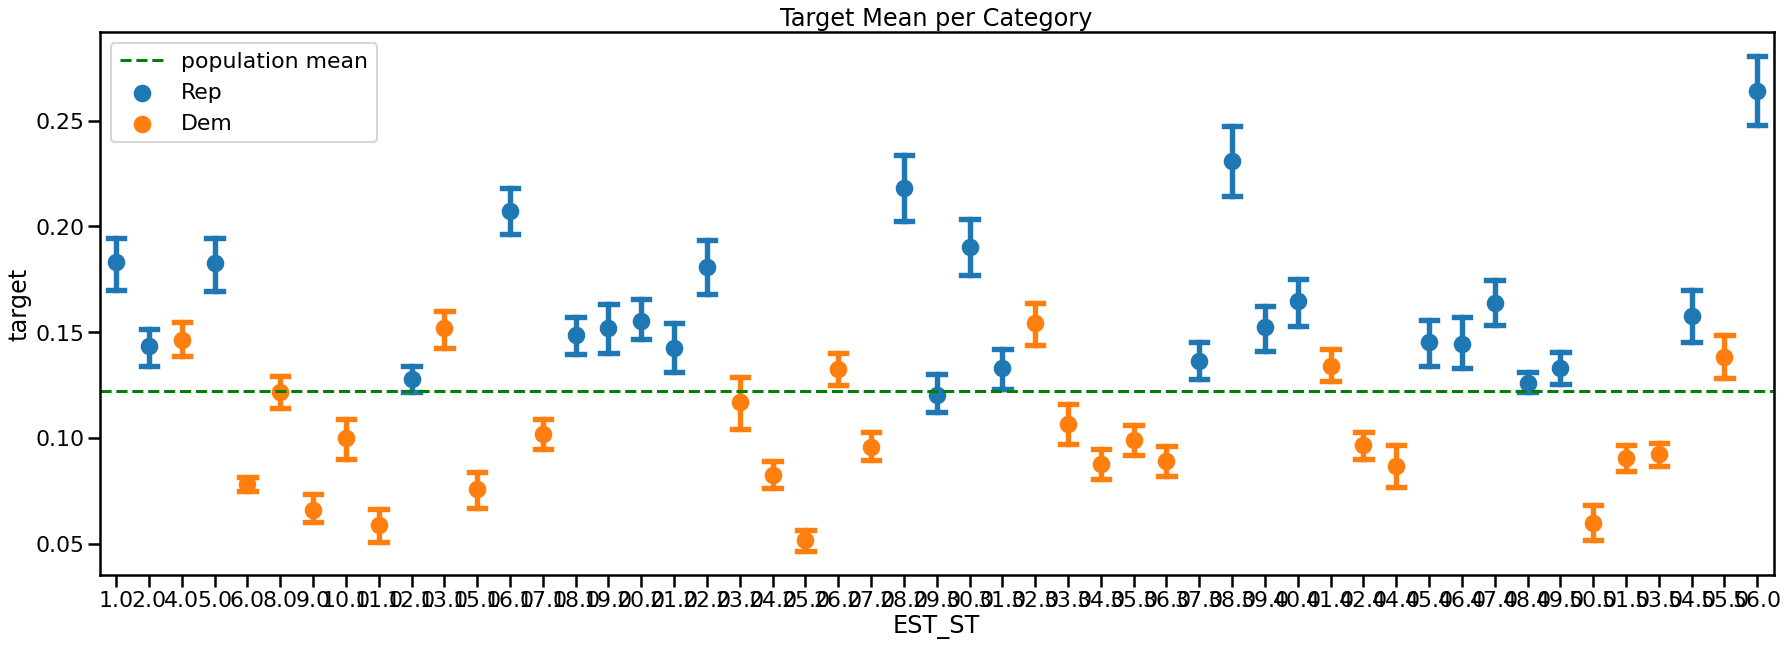

In [86]:
fig, ax = plt.subplots(figsize=(30, 10))

sns.pointplot(data=df, x='EST_ST', y='target', hue='polit',
              ci=68, ax=ax, join=False, scale=1, capsize=0.5)
ax.set_title("Target Mean per Category")
ax.axhline(pop_mean, color='green', ls='dashed', label='population mean')
ax.legend();

It does look like all of the states that case the majority of their electoral college votes for the Republican candidate in the 2020 presidential election are at or above population mean, so they lean more towards vaccine hesitancy. 

Some of the majority Democratic states (orange) are at or above population mean too. But almost all of the states that are below population mean (lean more towards vaccine optimism) are Democratic majority.

Much as I wanted to avoid playing up the perception of a political divide, it does appear to be supported by the data. I will OHE this already so I don't have to worry about dropping anything.

In [87]:
# Majority Democratic will be 0; majority Republican will be 1
df.loc[df['EST_ST'].isin(dems), 'polit'] = 0
df.loc[df['EST_ST'].isin(reps), 'polit'] = 1

cat_cols.append('polit')

df['polit'].value_counts()

0    45211
1    32614
Name: polit, dtype: int64

## Correlation Matrix

In [88]:
all_cols = cat_cols + cat_cols_v1 + cat_cols_v2 + ord_cols + num_cols + num_cols_v2

print(len(all_cols))
print(len(set(all_cols)))

79
79


In [89]:
# Create a correlation matrix
corr = df[all_cols].corr()

# Unstack the matrix and sort by values to get something I can filter
corr2 = corr.unstack()
sorted_corr = corr2.sort_values().reset_index()
sorted_corr

,level_0,level_1,0
0,HLTHINS,incomplete,-0.939064
1,incomplete,HLTHINS,-0.939064
2,MH_NOTGET,incomplete,-0.891169
3,incomplete,MH_NOTGET,-0.891169
4,inc_binary,LIVQTR_2,-0.890951
...,...,...,...
6079,HLTHINS7,HLTHINS7,1.000000
6080,HLTHINS8,HLTHINS8,1.000000
6081,ENROLL1,ENROLL1,1.000000
6082,HLTHINS2,HLTHINS2,1.000000


In [90]:
# Remove duplicates where a feature is correlated against itself
to_drop = sorted_corr.loc[sorted_corr['level_0'] == sorted_corr['level_1']].index
sorted_corr.drop(index=to_drop, inplace=True)

# Remove the second copy of each correlated pair by combining them in sorted 
# order into a new column
def combine_cols(x):
    combo = [x['level_0'], x['level_1']]
    combo.sort()
    return ' / '.join(combo)

sorted_corr['combo'] = sorted_corr.apply(combine_cols, axis=1)

# Drop duplicates based on combo column
sorted_corr.drop_duplicates(subset='combo', inplace=True)
sorted_corr

,level_0,level_1,0,combo
0,HLTHINS,incomplete,-0.939064,HLTHINS / incomplete
2,MH_NOTGET,incomplete,-0.891169,MH_NOTGET / incomplete
4,inc_binary,LIVQTR_2,-0.890951,LIVQTR_2 / inc_binary
6,MH_SVCS,incomplete,-0.889066,MH_SVCS / incomplete
8,LIVQTR_2,incomplete,-0.887357,LIVQTR_2 / incomplete
...,...,...,...,...
5996,HLTHINS5,HLTHINS6,0.945932,HLTHINS5 / HLTHINS6
5998,HLTHINS7,HLTHINS6,0.947737,HLTHINS6 / HLTHINS7
6000,TNUM_PS_2,TNUM_PS,0.968248,TNUM_PS / TNUM_PS_2
6002,SCHOOL_KIDS,ENROLL1,0.972977,ENROLL1 / SCHOOL_KIDS


In [91]:
# Filter features with pearson R greater than 0.8

with pd.option_context('display.max_rows', 200):
    display(sorted_corr.loc[(sorted_corr[0] > 0.8)|(sorted_corr[0] < -0.8), 
                            ['combo', 0]])

,combo,0
0,HLTHINS / incomplete,-0.939064
2,MH_NOTGET / incomplete,-0.891169
4,LIVQTR_2 / inc_binary,-0.890951
6,MH_SVCS / incomplete,-0.889066
8,LIVQTR_2 / incomplete,-0.887357
10,PROP_FOODSPEND_HOME / incomplete,-0.875832
12,TNUM_PS_2 / inc_binary,-0.874383
14,NOTGET / incomplete,-0.867114
16,HLTHINS / inc_binary,-0.866056
18,PRESCRIPT / incomplete,-0.860997


So I definitely have some multicollinearity going on here with my categorical variables, and not only the ones that are naturally related or represent features I engineered.

Many of these seem to be around health insurance, healthcare received or not received, and feelings of anxiety, worry, down, or lost interest.

I'm not sure to what extent these will cause a problem. To start with, I'm going to create a baseline model using the original versions of the features where possible, and I'll see what I get. I can always substitute some of the engineered features.

## Plan to deal with missing values in preprocessing

I need to decide how each set of columns will be preprocessed. Categorical columns will be OHE and I can drop a label or not. Numeric columns will be standardized, but I need to decide how to deal with placeholders and impute values.

### Categorical Columns
Some of my categorical columns have -2 values, which I will want to drop during OHE and will be replaced with the engineered 'incomplete' column. I need to separate these from the categorical columns which do NOT have -2 values, because I won't drop anything from those.

In [92]:
# Create new dataframe including only the features I'll want to try out
# in my initial models
X = df[all_cols].copy()
y = df['target'].copy()

X.head()

,ANYWORK,CHNGHOW1,CHNGHOW10,CHNGHOW11,CHNGHOW12,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,...,CURFOODSUF,EEDUC,EXPNS_DIF,INCOME,THHLD_NUMKID,PROP_FOODSPEND_HOME,AGE,incomplete,TNUM_PS,skipped
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,-2.0,4.0,1.0,-2.0,0.0,-2.000000,65.0,37,-2.0,0
1,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,5.0,3.0,6.0,1.0,0.800000,26.0,0,0.0,0
2,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,-2.0,6.0,-2.0,-2.0,0.0,-2.000000,60.0,39,-2.0,0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,4.0,4.0,4.0,3.0,0.0,1.000000,50.0,0,0.0,0
4,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,6.0,2.0,4.0,1.0,0.322581,80.0,0,0.0,2


In [93]:
# Loop through categorical columns and determine which have -2 and will need
# to have their first label dropped

all_cats = cat_cols + cat_cols_v1 + cat_cols_v2

cat_drop_first = []
cat_drop_none = []

for col in all_cats:
    if len(X.loc[X[col]==-2, col]) > 0:
        cat_drop_first.append(col)
    else:
        cat_drop_none.append(col)

In [94]:
# Loop through lists to confirm results
for col in cat_drop_first:
    print(X[col].value_counts())

 0.0    38740
 1.0    34878
-2.0     4207
Name: CHNGHOW1, dtype: int64
 0.0    68799
 1.0     4819
-2.0     4207
Name: CHNGHOW10, dtype: int64
 0.0    72049
-2.0     4207
 1.0     1569
Name: CHNGHOW11, dtype: int64
 0.0    54509
 1.0    19109
-2.0     4207
Name: CHNGHOW12, dtype: int64
 0.0    56443
 1.0    17175
-2.0     4207
Name: CHNGHOW2, dtype: int64
 0.0    67959
 1.0     5659
-2.0     4207
Name: CHNGHOW3, dtype: int64
 0.0    51444
 1.0    22174
-2.0     4207
Name: CHNGHOW4, dtype: int64
 0.0    71127
-2.0     4207
 1.0     2491
Name: CHNGHOW5, dtype: int64
 0.0    36929
 1.0    36689
-2.0     4207
Name: CHNGHOW6, dtype: int64
 0.0    67489
 1.0     6129
-2.0     4207
Name: CHNGHOW7, dtype: int64
 0.0    58778
 1.0    14840
-2.0     4207
Name: CHNGHOW8, dtype: int64
 0.0    56697
 1.0    16921
-2.0     4207
Name: CHNGHOW9, dtype: int64
 0.0    46448
 1.0    17044
-2.0    13906
-1.0      427
Name: DELAY, dtype: int64
 4.0    49102
 3.0    12221
 1.0     7574
 2.0     6201
-2.0   

In [95]:
# Loop through lists to confirm results
for col in cat_drop_none:
    print(X[col].value_counts())

 1.0    44266
 0.0    33312
-1.0      247
Name: ANYWORK, dtype: int64
0.0    46326
1.0    31499
Name: EGENDER, dtype: int64
 0.0    66184
 1.0    11349
-1.0      292
Name: EXPCTLOSS, dtype: int64
 0.0    68660
 1.0     8527
-1.0      638
Name: HADCOVID, dtype: int64
0.0    70428
1.0     7397
Name: RHISPANIC, dtype: int64
1.0    64253
2.0     6076
3.0     3925
4.0     3571
Name: RRACE, dtype: int64
 0.0    42009
 1.0    32097
-1.0     3719
Name: TW_START, dtype: int64
 0.0    48766
 1.0    28874
-1.0      185
Name: WRKLOSS, dtype: int64
2.0    43223
1.0    17308
3.0    17294
Name: THHLD_NUMADLT, dtype: int64
0    45211
1    32614
Name: polit, dtype: int64
0.0        51865
47900.0     3050
35620.0     2111
37980.0     2071
14460.0     2020
42660.0     1848
41860.0     1842
31080.0     1751
19100.0     1680
16980.0     1679
26420.0     1632
38060.0     1429
40140.0     1229
19820.0     1222
12060.0     1220
33100.0     1176
Name: EST_MSA, dtype: int64
 1.0    45740
 5.0    13762
 3.0    1

### Numeric and Ordinal columns
Now I have the numeric and ordinal columns which I will treat as numeric.

These will not be OHE, they will be standardized. I will need to determine the best way to remove the missing placeholders and impute them. 

I think I will want to simply nullify and impute the -2 values, since their info will be covered by the 'incomplete' column. But for -1 values indicating someone skipped just that question, I will probably want to create another column to indicate the respondent skipped that particular question.

In [96]:
for col in num_cols + ord_cols + num_cols_v2:
    print(X[col].value_counts())

0.0    52672
1.0    11499
2.0     8853
3.0     3195
4.0     1057
5.0      549
Name: THHLD_NUMKID, dtype: int64
 1.000000    13938
-2.000000    10775
 0.666667     4761
 0.500000     4201
-1.000000     3240
             ...  
 0.559387        1
 0.949657        1
 0.699422        1
 0.440559        1
 0.946502        1
Name: PROP_FOODSPEND_HOME, Length: 2097, dtype: int64
67.0    1967
66.0    1957
69.0    1916
65.0    1853
68.0    1813
        ... 
19.0     239
85.0     203
86.0     166
18.0     154
87.0     134
Name: AGE, Length: 71, dtype: int64
0     61514
37     4523
23     2580
21     1560
39     1417
2      1150
38      703
9       702
1       659
4       596
17      590
26      333
41      322
22      279
40      276
25      261
42      197
24      163
Name: incomplete, dtype: int64
 0.0    45969
-2.0    15652
 1.0    10678
 2.0     3138
-1.0     1525
 3.0      863
Name: TNUM_PS, dtype: int64
 1.0    50871
 2.0    14681
-2.0     7771
 3.0     3258
 4.0      834
-1.0      410
Name

In [97]:
def missingind_prep(df, col, dummy_val=-1):
    """Prepares numeric columns that have placeholders for modeling.
    
    Create a separate missing indicator column where col is populated
    with `dummy_val`.
    
    Replace all values less than 0 with np.nan, since these numbers represent
    placeholders in this dataset.
    
    Graph the distribution to help me decide which statistic would be 
    appropriate for imputing missing values.
    """
    skipped = col + '_skipped'
    
    # Create missing indicator column
    df.loc[df[col]==dummy_val, skipped] = 1
    df.loc[df[skipped].isna(), skipped] = 0

    # Nullify the -2 and -1 values to see the proportion distribution
    df.loc[df[col]<0, col] = np.nan

    # print descriptive statistics
    print(df[col].describe())

    #chart histogram
    fig, ax = plt.subplots()
    sns.histplot(df[col])
    plt.show();
    
    return df, skipped

In [98]:
# These are the cols that don't need to be imputed since they have no nulls
num_cols_filled = ['THHLD_NUMKID','AGE','incomplete','EEDUC']

count    63810.000000
mean         0.745933
std          0.225950
min          0.000000
25%          0.636364
50%          0.769231
75%          0.923077
max          1.000000
Name: PROP_FOODSPEND_HOME, dtype: float64


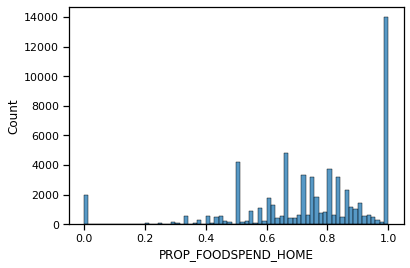

count    60648.000000
mean         0.322237
std          0.638175
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          3.000000
Name: TNUM_PS, dtype: float64


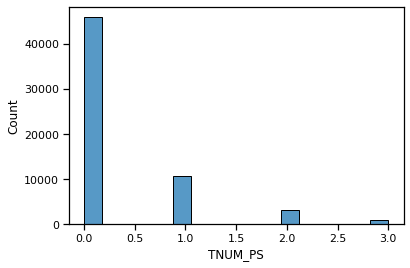

count    69644.000000
mean         1.340288
std          0.624428
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: CURFOODSUF, dtype: float64


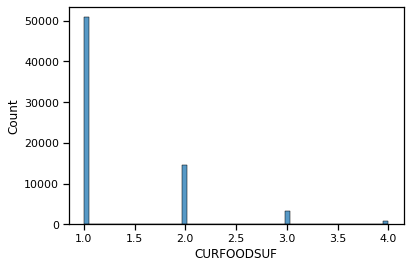

count    74463.000000
mean         1.801942
std          1.010840
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: EXPNS_DIF, dtype: float64


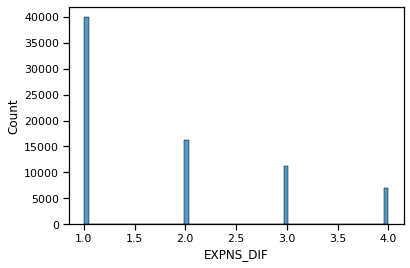

count    59429.000000
mean         4.640916
std          2.079498
min          1.000000
25%          3.000000
50%          5.000000
75%          6.000000
max          8.000000
Name: INCOME, dtype: float64


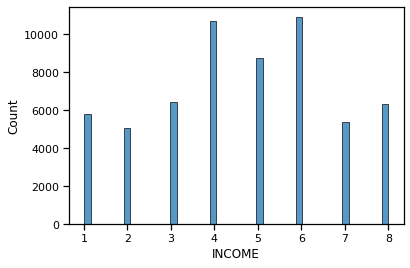

['PROP_FOODSPEND_HOME_skipped',
 'TNUM_PS_skipped',
 'CURFOODSUF_skipped',
 'EXPNS_DIF_skipped',
 'INCOME_skipped']

In [99]:
# These columns need to have missing placeholders dropped and values imputed
# The rest are fully filled out
to_impute = ['PROP_FOODSPEND_HOME', 'TNUM_PS', 'CURFOODSUF', 'EXPNS_DIF', 
             'INCOME']

missing_inds = []

sns.set_context('notebook')

for col in to_impute:
    # Create a missing indicator for -1 values
    X, ind_col = missingind_prep(X, col)
    missing_inds.append(ind_col)
    
missing_inds

PROP_FOODSPEND_HOME
- Represents the proportion of food spend that went towards food to be prepared at home versus food that already was prepared.
- By far the most common value is 1. Mean and median are around 0.75. I think the best bet is to impute this with mode.

TNUM_PS
- Represents the number of people in the household who plan to attend post-secondary classes.
- 0 is by far the most common, so will impute with mode.

CURFOODSUF
- Represents the level of food insufficiency in the past 7 days.
- 1 is by far the most common, so will impute with mode.

EXPNS_DIF
- Represents degree of difficulty meeting expenses
- Median and mode are both 1, but mean is significantly higher at 1.8 I think imputing with mean here is most representative.

INCOME
- Ordinally encoded income range pre-tax
- Mean seems like the most representative statistic to impute here.



In [100]:
# append missing indicator columns to cat_col lists
cat_cols = cat_cols + missing_inds
cat_drop_none = cat_drop_none + missing_inds

num_cols_mode = ['PROP_FOODSPEND_HOME', 'TNUM_PS', 'CURFOODSUF']

num_cols_mean = ['EXPNS_DIF', 'INCOME']

## Summary of Explore

During the Explore phase, I reviewed distributions of the original and engineered features. I also visualized the impact of each feature on the target, focusing on the target mean for categorical variables. Since target is binary, the mean of the target for each feature class is a representation of the proportion of vaccine hesitant respondents in that feature class.

There were a handful of features that didn't appear to have much impact on target mean, but at this point I'm not removing anything. I will model all of the features in their near-original forms first to get a baseline, and will iterate to remove features or substitute engineered versions of features to improve performance.

Going into the modeling phase, I have several lists of feature columns which have been split up based on how I intend to preprocess them, and whether they are the 'original' or more engineered features:

- **cat_drop_none**:
    - All categorical features, both original and engineered
    - Did not have any respondents who didn't answer because they prematurely exited the questionnaire. If -1 values exist indicating the respondent didn't answer that particular question only, these will be dummied in initial model.
    
- **cat_drop_first**:
    - All categorical features, both original and engineered
    - Had some respondents who didn't answer because they prematurely exited the questionnaire. These have value -2, so will drop first. If -1 values exist indicating the respondent didn't answer that particular question only, these will be dummied in initial model.
    
- **num_cols_mode**:
    - (almost) Original numeric features where values of -2 and -1 have been nullified
    - These will be scaled, since they're numeric
    - Null values to be imputed with mode
    
- **num_cols_mean**:
    - (almost) Original numeric features where values of -2 and -1 have been nullified
    - These will be scaled, since they're numeric
    - Null values to be imputed with mean

- **num_cols_filled**:
    - Numeric features I will include in my first model and that do not need to be imputed.

- **cat_cols**:
    - Categorical features that I didn't engineer anything additional for. These don't have a corresponding eng feature I can substitute.
    
- **cat_cols_v1**:
    - Original version of the categorical features that I did engineer. I will try these first, but am keeping a separate list so I can easily switch the engineered versions for these.
    
- **cat_cols_v2**:
    - Engineered versions of categorical features. These will not be included in initial model, but I'll transform them and keep them around so I can test them out if the original features don't perform too well.
    
- **num_cols_v2**:
    - Engineered versions of numeric features, which at this point is actually only the 'skipped' feature. Depending on how the OHE -1 dummy columns and numeric "_skipped" columns perform, I can substitute those for this one.

# MODEL

I will focus on F1 score, since I am modeling primarily for interpretation as opposed to prediction. I want the model to be as balanced as possible between precision and recall.

Because I have so many categorical features which will be dummied into one-hot columns, and the spread of my numeric features isn't too wide, I will use a Min-Max scaler instead of Standard scaler, because there will be more consistency between categorical and numeric that way.

In [101]:
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier, \
    RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_validate, \
    cross_val_predict, cross_val_score, GridSearchCV
from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2, \
    mutual_info_classif, f_classif, SelectFromModel
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
import joblib

## Initial Preprocessing

### Train-Test-Split

In [103]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, 
                                                    stratify=y)

X_train.head()

,ANYWORK,CHNGHOW1,CHNGHOW10,CHNGHOW11,CHNGHOW12,CHNGHOW2,CHNGHOW3,CHNGHOW4,CHNGHOW5,CHNGHOW6,...,PROP_FOODSPEND_HOME,AGE,incomplete,TNUM_PS,skipped,PROP_FOODSPEND_HOME_skipped,TNUM_PS_skipped,CURFOODSUF_skipped,EXPNS_DIF_skipped,INCOME_skipped
49436,1.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,-2.0,...,NaN,62.0,39,NaN,0,0.0,0.0,0.0,0.0,0.0
34047,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.75,34.0,0,0.0,0,0.0,0.0,0.0,0.0,0.0
22994,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.70,59.0,0,1.0,0,0.0,0.0,0.0,0.0,0.0
47478,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,NaN,78.0,0,0.0,1,1.0,0.0,0.0,0.0,0.0
37059,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,NaN,81.0,0,0.0,8,1.0,0.0,0.0,0.0,0.0


In [104]:
print(y_train.value_counts(1))
y_train.value_counts()

0.0    0.877861
1.0    0.122139
Name: target, dtype: float64


0.0    51239
1.0     7129
Name: target, dtype: int64

In [105]:
print(y_test.value_counts(1))
y_test.value_counts()

0.0    0.877885
1.0    0.122115
Name: target, dtype: float64


0.0    17081
1.0     2376
Name: target, dtype: int64

My target exhibits class imbalance.

The classification models I intend to test are:
- KNN <-- Does NOT have a class_weight parameter
- Decision Tree <-- has a class_weight parameter
- Random Forest <-- has a class_weight parameter

I can try to play with the `weights` parameter in KNN to account for class imbalance, but I'm not sure how well it will do. I will use SMOTE to resample my data and create a version of X_train that is resampled, so I can test its performance versus not adjusting and using class_weight=balanced.

### Impute, OHE, Scale

Before I can resample to address class imbalance using SMOTE, I need to impute null values, since SMOTE doesn't like null values.

I may as well just build a column transformer of pipelines.

In [106]:
# Pipeline for numeric columns imputing the mean
num_tf_mean = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
    ])

# Pipeline for numeric columns imputing the mode
num_tf_mode = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', MinMaxScaler())
    ])

# Pipeline for categorical columns where the first label will be dropped
cat_tf_dfirst = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False, drop='first'))
    ])

# Pipeline for categorical columns where the no label will be dropped
cat_tf_dnone = Pipeline(steps=[
    ('encoder', OneHotEncoder(sparse=False))
    ])

# create column transformer to do all the transformations

# Transforming and scaling all my X_train data, including some columns
# I may or may not end up using. This will avoid having to do it again later.

# Note that I'm adding num_cols_v2 with the mean transformer just to get it
# scaled somewhere; it has no missing values to be imputed

col_trans = ColumnTransformer(transformers=[
    ('num_mean', num_tf_mean, num_cols_mean + num_cols_v2 + num_cols_filled),
    ('num_mode', num_tf_mode, num_cols_mode),
    ('cat_dfirst', cat_tf_dfirst, cat_drop_first),
    ('cat_dnone', cat_tf_dnone, cat_drop_none)
    ])

In [107]:
from sklearn import set_config
set_config(display='diagram')

col_trans

ColumnTransformer(transformers=[('num_mean',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['EXPNS_DIF', 'INCOME', 'skipped',
                                  'THHLD_NUMKID', 'AGE', 'incomplete',
                                  'EEDUC']),
                                ('num_mode',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('scaler', MinMaxScaler())]),
                                 ['PROP_FOODSPEND_HOME', 'TNUM_PS',
                                  'CURFOODSUF']),
                                ('...
                                ('cat_dnone',
                                 Pipeline(steps=[('encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 ['ANYWORK', 'EGENDER', 'EXPCTLOSS', 'HADCOVID',
                                  'RHISPANIC', 'RRACE', 'TW_START', 'WRKLOSS',
                                  'THHLD_NUMADLT', 'polit', 'EST_MSA', 'MS',
                                  'inc_binary', 'IN_METRO_AREA', 'SCHOOL_KIDS',
                                  'MS_2', 'PROP_FOODSPEND_HOME_skipped',
                                  'TNUM_PS_skipped', 'CURFOODSUF_skipped',
                                  'EXPNS_DIF_skipped', 'INCOME_skipped'])])

In [108]:
# transform training data
X_train_tf = col_trans.fit_transform(X_train)
X_test_tf = col_trans.transform(X_test)

In [109]:
# Do X_train and X_test have the same number of columns? They might not
# if I had rare columns in train but not test
print(X_train_tf.shape)
print(X_test_tf.shape)

(58368, 240)
(19457, 240)


In [110]:
# Turn the X dfs into dataframes
nums = num_cols_mean + num_cols_v2 + num_cols_filled + num_cols_mode

# I'm assuming here that we had the same categories in X_test and X_train
ohe1 = list(col_trans.named_transformers_['cat_dfirst'].\
            named_steps['encoder'].get_feature_names(cat_drop_first))
ohe2 = list(col_trans.named_transformers_['cat_dnone'].\
            named_steps['encoder'].get_feature_names(cat_drop_none))

all_x_cols = nums + ohe1 + ohe2

X_train_df = pd.DataFrame(X_train_tf, columns=all_x_cols, index=X_train.index)
X_test_df = pd.DataFrame(X_test_tf, columns=all_x_cols, index=X_test.index)

display(X_train_df.head())
display(X_test_df.head())

,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,...,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
49436,0.267979,0.519979,0.000,0.0,0.628571,0.928571,0.500000,1.00,0.000000,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
34047,0.000000,0.714286,0.000,0.0,0.228571,0.000000,0.833333,0.75,0.000000,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
22994,1.000000,0.428571,0.000,0.6,0.585714,0.000000,1.000000,0.70,0.333333,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
47478,0.000000,0.000000,0.025,0.0,0.857143,0.000000,0.500000,1.00,0.000000,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
37059,0.000000,0.571429,0.200,0.0,0.900000,0.000000,1.000000,1.00,0.000000,0.0,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,...,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
62473,0.0,0.857143,0.000,0.0,0.742857,0.0,0.833333,0.882353,0.000000,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
75583,0.0,0.857143,0.025,0.0,0.514286,0.0,1.000000,0.605263,0.666667,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
10321,1.0,0.285714,0.175,0.6,0.300000,0.0,0.666667,0.666667,0.000000,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6031,0.0,1.000000,0.175,0.4,0.342857,0.0,1.000000,0.666667,0.000000,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
66638,0.0,1.000000,0.000,0.0,0.514286,0.0,1.000000,0.500000,0.333333,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [111]:
# How many -1 skipped question columns do I have now?
cols_skipped = list(filter(lambda x: x.endswith('-1.0'), 
                           list(X_train_df.columns)))
cols_skipped

['DELAY_-1.0',
 'EIP_-1.0',
 'FEWRTRANS_-1.0',
 'FEWRTRIPS_-1.0',
 'FREEFOOD_-1.0',
 'MH_NOTGET_-1.0',
 'MH_SVCS_-1.0',
 'NOTGET_-1.0',
 'PLNDTRIPS_-1.0',
 'PRESCRIPT_-1.0',
 'SNAP_YN_-1.0',
 'SSA_APPLY_-1.0',
 'SSA_RECV_-1.0',
 'TENURE_-1.0',
 'UI_APPLY_-1.0',
 'ANXIOUS_-1.0',
 'DOWN_-1.0',
 'INTEREST_-1.0',
 'WORRY_-1.0',
 'HLTHINS1_-1.0',
 'HLTHINS2_-1.0',
 'HLTHINS3_-1.0',
 'HLTHINS4_-1.0',
 'HLTHINS5_-1.0',
 'HLTHINS6_-1.0',
 'HLTHINS7_-1.0',
 'HLTHINS8_-1.0',
 'ENROLL1_-1.0',
 'ENROLL2_-1.0',
 'ENROLL3_-1.0',
 'LIVQTR_-1.0',
 'HLTHINS_-1.0',
 'LIVQTR_2_-1.0',
 'TNUM_PS_2_-1.0',
 'ANYWORK_-1.0',
 'EXPCTLOSS_-1.0',
 'HADCOVID_-1.0',
 'TW_START_-1.0',
 'WRKLOSS_-1.0',
 'MS_-1.0',
 'MS_2_-1.0']

### SMOTE

In [112]:
from imblearn.over_sampling import SMOTENC

In [113]:
# list columns to create a boolean mask for categorical
list(X_train_df.columns)

['EXPNS_DIF',
 'INCOME',
 'skipped',
 'THHLD_NUMKID',
 'AGE',
 'incomplete',
 'EEDUC',
 'PROP_FOODSPEND_HOME',
 'TNUM_PS',
 'CURFOODSUF',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW10_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW8_0.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'DELAY_-1.0',
 'DELAY_0.0',
 'DELAY_1.0',
 'EIP_-1.0',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'FEWRTRANS_-1.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_2.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_-1.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_-1.0',
 'FREEFOOD_0.0',
 'FREEFOOD_1.0',
 'MH_NOTGET_-1.0',
 'MH_NOTGET_0.0',
 'MH_NOTGET_1.0',
 'MH_SVCS_-1.0',
 'MH_SVCS_0.0',
 'MH_SVCS_1.0',
 'NOTGET_-1.0',
 'NOTGET_0.0',
 'NOTGET_1.0',
 'PLNDTRIPS_-1

Luckily, the OHE columns were all put at the end, so I can easily make a boolean mask. The first 10 columns are False, and the rest are True.

In [114]:
cat_mask = np.array([True]*10 + [False]*230)
print(len(cat_mask))
cat_mask

240


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [115]:
sm = SMOTENC(cat_mask, random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train_df, y_train) 

In [116]:
print(y_train_sm.value_counts(1))
print(y_train_sm.value_counts())


1.0    0.5
0.0    0.5
Name: target, dtype: float64
1.0    51239
0.0    51239
Name: target, dtype: int64


## Create Dummy Model


In [117]:
def eval_clf_model(clf, X_test, y_test, X_train, y_train, score='macro',
               reports=True, labels=['Class 0', 'Class 1']):
    """Shows metrics and plots visualizations to interpret classifier model 
    performance.
    
    ***
    Args
    
    clf: classifier model to evaluate
    
    X_test: dataframe of test predictors
    
    y_test: dataframe of true target values
    
    X_train: dataframe (optional). Default is None. Provide training data if
    you want to evaluate performance on train versus test; otherwise only 
    test performance is evaluated.
    
    y_train: dataframe (optional). Default is None. Provide training data if
    you want to evaluate performance on train versus test; otherwise only 
    test performance is evaluated.
    
    scores: string (optional). Default is `std` to return standard F1, accuracy, 
    and recall scores. Use `macro` to return macro F1 and recall, and balanced
    accuracy. Scores are always returned, regardles of `reports` param.
    
    reports: boolean (optional). Default is True. Set to False to return only 
    scores, not actual classification reports.
    
    labels: list (optional). Provide a list of labels for the target class.
    """
    spacer = '*'*30
    
    # Get predictions 1 time only, since they will be used in a few spots
    test_preds = clf.predict(X_test)
    train_preds = clf.predict(X_train)
    
    # print classification reports
    if reports:
        print(spacer + ' Training Data ' + spacer)
        print(metrics.classification_report(y_train, train_preds))
        print()
        print(spacer + ' Test Data ' + spacer)
        print(metrics.classification_report(y_test, test_preds))
        print()
    
    # print scores from train and test next to each other for easy comparison
    print(spacer + ' Training Scores ' + spacer)

    # Train
    if score == 'std':
        train_f1 = np.round(metrics.f1_score(y_train, train_preds), 4)
        print(f"                  Training F1 = {train_f1}")
        train_r = np.round(metrics.recall_score(y_train, train_preds), 4)
        print(f"              Training Recall = {train_r}")
        train_acc = np.round(metrics.accuracy_score(y_train, train_preds), 4)
        print(f"            Training Accuracy = {train_acc}")
    elif score == 'macro':
        train_f1m = np.round(metrics.f1_score(y_train, train_preds, average='macro'), 4)
        print(f"            Training Macro F1 = {train_f1m}")
        train_rm = np.round(metrics.recall_score(y_train, train_preds, average='macro'), 4)
        print(f"        Training Macro Recall = {train_rm}")
        train_accbal = np.round(metrics.balanced_accuracy_score(y_train, train_preds), 4)
        print(f"   Training Balanced Accuracy = {train_accbal}")
    print()
    print(spacer + ' Test Scores ' + spacer)
    
    #Test
    if score == 'std':
        test_f1 = np.round(metrics.f1_score(y_test, test_preds), 4)
        print(f"                      Test F1 = {test_f1}")
        test_r = np.round(metrics.recall_score(y_test, test_preds), 4)
        print(f"                  Test Recall = {test_r}")
        test_acc = np.round(metrics.accuracy_score(y_test, test_preds), 4)
        print(f"                Test Accuracy = {test_acc}")
        
    elif score == 'macro':
        test_f1m = np.round(metrics.f1_score(y_test, test_preds, average='macro'), 4)
        print(f"                Test Macro F1 = {test_f1m}")
        test_rm = np.round(metrics.recall_score(y_test, test_preds, average='macro'), 4)
        print(f"            Test Macro Recall = {test_rm}")
        test_accbal = np.round(metrics.balanced_accuracy_score(y_test, test_preds), 4)
        print(f"       Test Balanced Accuracy = {test_accbal}")
    print()
    print(spacer + ' Differences ' + spacer)
    
    #Diffs
    if score == 'std':
        print(f"               Train-Test F1 Diff = {test_f1 - train_f1}")       
        print(f"           Train-Test Recall Diff = {test_r - train_r}")       
        print(f"         Train-Test Accuracy Diff = {test_acc - train_acc}")     
    elif score == 'macro':  
        print(f"         Train-Test Macro F1 Diff = {test_f1m - train_f1m}")      
        print(f"     Train-Test Macro Recall Diff = {test_rm - train_rm}")       
        print(f"Train-Test Balanced Accuracy Diff = {test_accbal - train_accbal}")
    
    print()
    print(spacer + ' Graphs for Test ' + spacer)
    # plot graphs
    auc = np.round(metrics.roc_auc_score(y_test, test_preds), 2)
    ap = np.round(metrics.average_precision_score(y_test, test_preds), 2)
    
    fig, [ax1, ax2, ax3] = plt.subplots(figsize=[10, 3], nrows=1, ncols=3)
    plt.tight_layout(pad=2.5)
    metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true', 
                              display_labels=labels, cmap='Reds', ax=ax1)
    metrics.plot_roc_curve(clf, X_test, y_test, ax=ax2)
    ax2.legend(loc='best', fontsize='small', labels=[f'AUC: {auc}'])
    
    metrics.plot_precision_recall_curve(clf, X_test, y_test, ax=ax3)
    ax3.legend(loc='best', fontsize='small')
    ax3.legend(loc='best', fontsize='small', labels=[f'AP: {ap}'])
    plt.show();
    
    return None
    

In [118]:
y_train.value_counts()

0.0    51239
1.0     7129
Name: target, dtype: int64

In [119]:
labels = ['Optimistic', 'Hesitant']

### New Lists of Features to Try

It has become increasingly difficult to keep track of the columns to be used for different purposes over the course of this analysis. I tried to use lists, but they aren't very useful now that I have OHE columns.

I resorted to printing lists of columns and combing through them outside this notebook to curate the different sets of feature columns that I want to use. If I had it to do over again, I would use a dataframe with columns instead of separate lists, but the new OHE columns would still be a challenge.

Here is a summary of the main differences between v1 and v2 column sets:

| Question | V1 | V2 |
|-|-|-|
| HLTHINS | Multiple choice question consisting of 8 options that represented different types of health insurance coverage. Kept as separate columns which were OHE, including -1 for skipped. | Engineered into a single binary column representing whether the person has any health insurance coverage or not. |
| LIVQTR | Single choice question about housing, where there were separate choices for detached versus attached house, and apartment buildings with different numbers of apartments. | Combined both house choices and all apartment choices to consolidate them |
| TNUM_PS | Numeric column representing how many individuals in the household intended to attend post-secondary classes in 2021. Max reported was 3, most were 0. | Engineered into a single binary column representing whether anyone in the household planned to attend post-secondary classes. |
| EST_MSA | Categorical column populated with different values for the metropolitan area the household was in. Only top 10 metro areas were imputed at all. | Engineered into a single binary column representing whether the household was in a top 10 metro area or not. |
| ENROLL | Multiple choice question consisting of 3 options that represented whether the household contained children enrolled in school outside the home or homeschooled, or not enrolled in school. Kept as separate columns which were OHE, including -1 for skipped. | Engineered into single binary column representing whether the household contained any children who were attending school outside the home (homeschooled is 0) |
| MS | Single choice question about married status. Divorced, Widowed, and Separated were separate choices. | Combined Divorced, Widowed, and Separated into a single category, leaving Married, Never Married, and Was Married but aren't anymore |
| incomplete | Numeric column representing how many questions were left incomplete when the respondent prematurely exited the questionnaire. Value of 0 means they finished the whole thing. | Binary column indicating 1 for prematurely exited at any point, 0 for finished the whole thing. |
| skipped | Populated missing indicator columns for numeric, and OHE -1 values for categorical features to indicate which specific questions a respondent didn't answer. Each question has its oen skipped indicator in some form in V1. This is different from incomplete, which indicates the entire questionnaire was exited at a certain point; skipped just means they skipped a particular question and kept going. | Numeric column with the number of questions the respondent skipped. This replaces all the individual skipped indicator columns. |

In [120]:
# get updated lists of original features now that columns have been dummied

# I printed the list of columns and pulled out the ones I know are engineered
eng_cols = ['skipped', 'HLTHINS_-1.0', 'HLTHINS_0.0', 'HLTHINS_1.0', 
           'LIVQTR_2_-1.0', 'LIVQTR_2_1.0', 'LIVQTR_2_2.0', 'LIVQTR_2_3.0', 
           'LIVQTR_2_4.0', 'TNUM_PS_2_-1.0', 'TNUM_PS_2_0.0', 'TNUM_PS_2_1.0', 
           'inc_binary_0.0', 'inc_binary_1.0', 'IN_METRO_AREA_0.0', 
           'IN_METRO_AREA_1.0', 'SCHOOL_KIDS_0.0', 'SCHOOL_KIDS_1.0', 
           'MS_2_-1.0', 'MS_2_1.0', 'MS_2_2.0', 'MS_2_3.0']
eng_cols.sort()

# v2 are everything that isn't v1
v1_cols = list(set(X_train_df.columns) - set(eng_cols))

# I really don't need both a skipped and not skipped indicator columns since
# if the respondent didn't skip a question, I have their answer coded separately
# Going to remove the _skipped= 0 dummy columns
v1_cols = list(filter(lambda x: not x.endswith('_skipped_0.0'), v1_cols))
v1_cols.sort()

display(v1_cols)


['AGE',
 'ANXIOUS_-1.0',
 'ANXIOUS_1.0',
 'ANXIOUS_2.0',
 'ANXIOUS_3.0',
 'ANXIOUS_4.0',
 'ANYWORK_-1.0',
 'ANYWORK_0.0',
 'ANYWORK_1.0',
 'CHNGHOW10_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW8_0.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'CURFOODSUF_skipped_1.0',
 'DELAY_-1.0',
 'DELAY_0.0',
 'DELAY_1.0',
 'DOWN_-1.0',
 'DOWN_1.0',
 'DOWN_2.0',
 'DOWN_3.0',
 'DOWN_4.0',
 'EEDUC',
 'EGENDER_0.0',
 'EGENDER_1.0',
 'EIP_-1.0',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'ENROLL1_-1.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'ENROLL3_1.0',
 'EST_MSA_0.0',
 'EST_MSA_12060.0',
 'EST_MSA_14460.0',
 'EST_MSA_16980.0',
 'EST_MSA_19100.0',

In [121]:
v2_cols = ['AGE', 'ANXIOUS_1.0', 'ANXIOUS_2.0', 'ANXIOUS_3.0', 'ANXIOUS_4.0', 
           'ANYWORK_0.0', 'ANYWORK_1.0', 'CHNGHOW10_0.0', 'CHNGHOW10_1.0', 
           'CHNGHOW11_0.0', 'CHNGHOW11_1.0', 'CHNGHOW12_0.0', 'CHNGHOW12_1.0', 
           'CHNGHOW1_0.0', 'CHNGHOW1_1.0', 'CHNGHOW2_0.0', 'CHNGHOW2_1.0', 
           'CHNGHOW3_0.0', 'CHNGHOW3_1.0', 'CHNGHOW4_0.0', 'CHNGHOW4_1.0', 
           'CHNGHOW5_0.0', 'CHNGHOW5_1.0', 'CHNGHOW6_0.0', 'CHNGHOW6_1.0', 
           'CHNGHOW7_0.0', 'CHNGHOW7_1.0', 'CHNGHOW8_0.0', 'CHNGHOW8_1.0', 
           'CHNGHOW9_0.0', 'CHNGHOW9_1.0', 'CURFOODSUF', 'DELAY_0.0', 
           'DOWN_1.0', 'DOWN_2.0', 'DOWN_3.0', 'DOWN_4.0', 'EEDUC', 
           'EGENDER_0.0', 'EGENDER_1.0', 'EIP_1.0', 'EIP_2.0', 'EIP_3.0', 
           'EIP_4.0', 'EXPCTLOSS_0.0', 'EXPCTLOSS_1.0', 'EXPNS_DIF', 
           'FEWRTRANS_1.0', 'FEWRTRANS_2.0', 'FEWRTRANS_3.0', 'FEWRTRIPS_0.0', 
           'FEWRTRIPS_1.0', 'FREEFOOD_0.0', 'FREEFOOD_1.0', 'HADCOVID_0.0', 
           'HADCOVID_1.0', 'INCOME', 'INTEREST_1.0', 'INTEREST_2.0', 
           'INTEREST_3.0', 'INTEREST_4.0', 'MH_NOTGET_0.0', 'MH_NOTGET_1.0', 
           'MH_SVCS_0.0', 'MH_SVCS_1.0', 'NOTGET_-1.0', 'NOTGET_0.0', 
           'NOTGET_1.0', 'PLNDTRIPS_0.0', 'PLNDTRIPS_1.0', 'PRESCRIPT_0.0', 
           'PRESCRIPT_1.0', 'PROP_FOODSPEND_HOME', 'RHISPANIC_0.0', 
           'RHISPANIC_1.0', 'RRACE_1.0', 'RRACE_2.0', 'RRACE_3.0', 
           'RRACE_4.0', 'SNAP_YN_0.0', 'SNAP_YN_1.0', 'SPNDSRC1_0.0', 
           'SPNDSRC1_1.0', 'SPNDSRC2_0.0', 'SPNDSRC2_1.0', 'SPNDSRC3_0.0', 
           'SPNDSRC3_1.0', 'SPNDSRC4_0.0', 'SPNDSRC4_1.0', 'SPNDSRC5_0.0', 
           'SPNDSRC5_1.0', 'SPNDSRC6_0.0', 'SPNDSRC6_1.0', 'SPNDSRC7_0.0', 
           'SPNDSRC7_1.0', 'SSA_APPLY_0.0', 'SSA_APPLY_1.0', 'SSA_RECV_0.0', 
           'SSA_RECV_1.0', 'TENURE_1.0', 'TENURE_2.0', 'TENURE_3.0', 
           'TENURE_4.0', 'THHLD_NUMADLT_1.0', 'THHLD_NUMADLT_2.0', 
           'THHLD_NUMADLT_3.0', 'THHLD_NUMKID', 'TW_START_0.0', 'TW_START_1.0', 
           'UI_APPLY_-1.0', 'UI_APPLY_0.0', 'UI_APPLY_1.0', 'WORRY_1.0', 
           'WORRY_2.0', 'WORRY_3.0', 'WORRY_4.0', 'WRKLOSS_0.0', 'WRKLOSS_1.0', 
           'polit_0', 'polit_1', 'skipped', 'HLTHINS_0.0', 'HLTHINS_1.0', 
           'LIVQTR_2_1.0', 'LIVQTR_2_2.0', 'LIVQTR_2_3.0',   'LIVQTR_2_4.0', 
           'TNUM_PS_2_0.0', 'TNUM_PS_2_1.0', 'inc_binary_0.0', 'inc_binary_1.0', 
           'IN_METRO_AREA_0.0', 'IN_METRO_AREA_1.0', 'SCHOOL_KIDS_0.0', 
           'SCHOOL_KIDS_1.0', 'MS_2_1.0', 'MS_2_2.0', 'MS_2_3.0']



****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     51239
         1.0       0.12      0.12      0.12      7129

    accuracy                           0.79     58368
   macro avg       0.50      0.50      0.50     58368
weighted avg       0.79      0.79      0.79     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     17081
         1.0       0.12      0.12      0.12      2376

    accuracy                           0.79     19457
   macro avg       0.50      0.50      0.50     19457
weighted avg       0.79      0.79      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.5004
        Training Macro Recall = 0.5004
   Training Balanced Accuracy = 0.5004



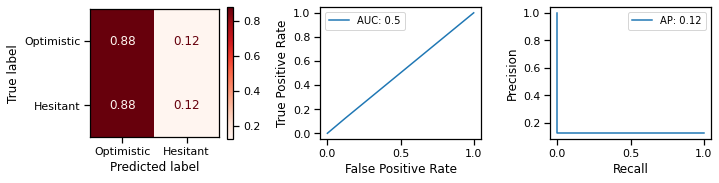

In [122]:
dum = DummyClassifier(strategy='stratified', random_state=42)

dum.fit(X_train_df[v1_cols], y_train)

eval_clf_model(dum, X_test_df, y_test, X_train_df[v1_cols], y_train, 
               labels=labels)

Performs appropriately poorly. Let's try on the SMOTEd data as well.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.50      0.88      0.64     51239
         1.0       0.50      0.12      0.19     51239

    accuracy                           0.50    102478
   macro avg       0.50      0.50      0.41    102478
weighted avg       0.50      0.50      0.41    102478


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      0.88      0.88     17081
         1.0       0.12      0.12      0.12      2376

    accuracy                           0.79     19457
   macro avg       0.50      0.50      0.50     19457
weighted avg       0.79      0.79      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.4147
        Training Macro Recall = 0.4991
   Training Balanced Accuracy = 0.4991



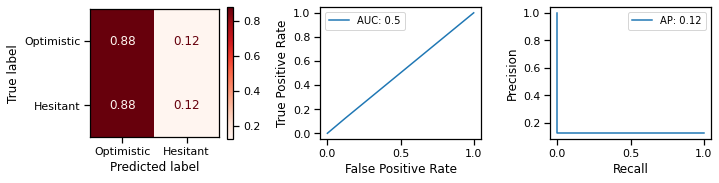

In [123]:
dum_bal = DummyClassifier(strategy='stratified', random_state=42)

dum_bal.fit(X_train_sm[v1_cols], y_train_sm)

eval_clf_model(dum, X_test_df, y_test, X_train_sm[v1_cols], y_train_sm, 
               labels=labels)

Also performs quite poorly. Great, now I can start modeling for real!

## Initial Models
I'll start by creating initial vanilla models using both the SMOTEd data, and original unbalanced data with the `class_weight='balanced'` parameter.

I'll use the 'v1' columns, aka the columns most close to the original data. I think it makes sense to use these for my baseline, so I can perform feature selection and compare model performance with those features to the baselines.

This will serve two purposes: I want to get some baseline models to compare to later once I start tuning, and also see if I can suss out which class imbalance approach will be best for this data set.

### Logistic Regression

Here I create two different logistic regression models without regularization, testing whether letting sklearn address class imbalance or using SMOTEd data is a better result.

I initially used the default `lbfgs` solver and had to bump up the max iterations to 300 to get it to converge. When I tried to cross validate, the models failed to converge even with max iter of 500. I switched to `saga` solver, which worked better for this larger dataset.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51239
         1.0       0.27      0.75      0.40      7129

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     17081
         1.0       0.27      0.74      0.39      2376

    accuracy                           0.72     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.72      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6078
        Training Macro Recall = 0.7326
   Training Balanced Accuracy = 0.7326



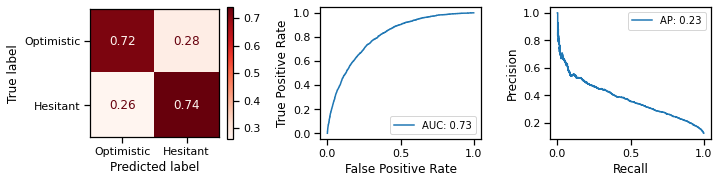

In [124]:
# When I tried to use cross validation, both models failed to converge,
# even when I increased max_iter to 500. Trying saga solver, which is supposed
# to converge faster for large datasets

lr_ub = LogisticRegression(C=1e12, class_weight='balanced', max_iter=500, 
                           solver='saga')

lr_ub.fit(X_train_df[v1_cols], y_train)

eval_clf_model(lr_ub, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74     51239
         1.0       0.74      0.77      0.75     51239

    accuracy                           0.75    102478
   macro avg       0.75      0.75      0.75    102478
weighted avg       0.75      0.75      0.75    102478


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.73      0.82     17081
         1.0       0.26      0.68      0.37      2376

    accuracy                           0.72     19457
   macro avg       0.60      0.70      0.60     19457
weighted avg       0.86      0.72      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.7483
        Training Macro Recall = 0.7484
   Training Balanced Accuracy = 0.7484



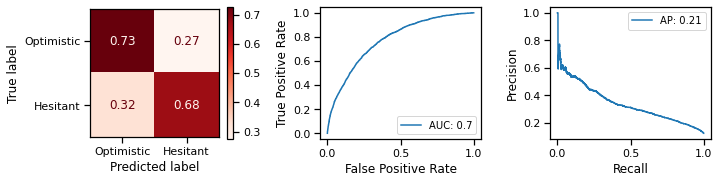

In [125]:
# trying saga solver since x-val didn't converge with default
lr_sm = LogisticRegression(C=1e12, max_iter=500, solver='saga')

lr_sm.fit(X_train_sm[v1_cols], y_train_sm)

eval_clf_model(lr_sm, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)

In [126]:
lr_ub_scores = cross_val_score(lr_ub, X_train_df[v1_cols], y_train, 
                               scoring='f1_macro', cv=5, n_jobs=-1)

lr_sm_scores = cross_val_score(lr_sm, X_train_sm[v1_cols], y_train_sm, 
                               scoring='f1_macro', cv=5, n_jobs=-1)
print('*** sklearn macro f1 ***')
print(lr_ub_scores)
print(lr_ub_scores.mean())
print()
print('*** SMOTE macro f1 ***')
print(lr_sm_scores)
print(lr_sm_scores.mean())

*** sklearn macro f1 ***
[0.60469226 0.60806106 0.60306609 0.60620751 0.60136458]
0.6046782997307323

*** SMOTE macro f1 ***
[0.71018579 0.75290792 0.7565044  0.75012758 0.75265494]
0.7444761260602583


In [451]:
lr_ub_scores = cross_val_score(lr_ub, X_train_df[v1_cols], y_train, 
                               scoring='balanced_accuracy', cv=5, n_jobs=-1)

lr_sm_scores = cross_val_score(lr_sm, X_train_sm[v1_cols], y_train_sm, 
                               scoring='balanced_accuracy', cv=5, n_jobs=-1)
print('*** sklearn balanced accuracy ***')
print(lr_ub_scores)
print(lr_ub_scores.mean())
print()
print('*** SMOTE balanced accuracy ***')
print(lr_sm_scores)
print(lr_sm_scores.mean())

*** sklearn balanced accuracy ***
[0.71466477 0.72613959 0.73324058 0.73432974 0.72950805]
0.7275765440479132

*** SMOTE balanced accuracy ***
[0.7078093  0.75318257 0.75405958 0.74776858 0.75278978]
0.7431219606198696


The vanilla model run on SMOTEd data did slightly better in terms of balanced accuracy, and quite a bit better in terms of macro F1 using cross validation on training data. 

However, with SMOTEd data there was a greater difference between F1 macro scores on train versus test. This looks like it's overfit. I'm concerned that by generating data using SMOTE, it has amplified noise in the training set that doesn't exist in the test set.

### Random Forests
Starting with `max_depth =10` because the default parameter of `None` still resulted in a very overfit model.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.87     51283
         1.0       0.34      0.79      0.47      7085

    accuracy                           0.79     58368
   macro avg       0.65      0.79      0.67     58368
weighted avg       0.89      0.79      0.82     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     17037
         1.0       0.29      0.66      0.41      2420

    accuracy                           0.76     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.76      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6692
        Training Macro Recall = 0.7883
   Training Balanced Accuracy = 0.7883



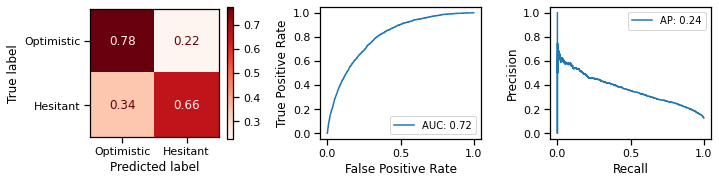

In [465]:
rf_ub = RandomForestClassifier(class_weight='balanced', n_jobs=-1, 
                               max_depth=10)

rf_ub.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf_ub, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.91      0.88      0.90     51283
         1.0       0.89      0.91      0.90     51283

    accuracy                           0.90    102566
   macro avg       0.90      0.90      0.90    102566
weighted avg       0.90      0.90      0.90    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.88      0.90     17037
         1.0       0.33      0.43      0.37      2420

    accuracy                           0.82     19457
   macro avg       0.62      0.65      0.64     19457
weighted avg       0.84      0.82      0.83     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.8986
        Training Macro Recall = 0.8986
   Training Balanced Accuracy = 0.8986



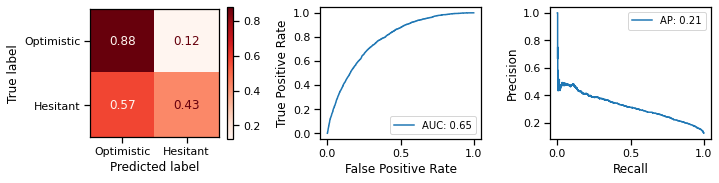

In [468]:
# SMOTEd data
rf_sm = RandomForestClassifier(n_jobs=-1, max_depth=10)

rf_sm.fit(X_train_sm[v1_cols], y_train_sm)

eval_clf_model(rf_sm, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)

In [469]:
rf_ub_scores = cross_val_score(rf_ub, X_train_df[v1_cols], y_train, 
                               scoring='f1_macro', cv=5, n_jobs=-1)

rf_sm_scores = cross_val_score(rf_sm, X_train_sm[v1_cols], y_train_sm, 
                               scoring='f1_macro', cv=5, n_jobs=-1)
print('*** sklearn macro f1 ***')
print(rf_ub_scores)
print(rf_ub_scores.mean())
print()
print('*** SMOTE macro f1 ***')
print(rf_sm_scores)
print(rf_sm_scores.mean())

*** sklearn macro f1 ***
[0.61709519 0.6212898  0.63208889 0.62573303 0.62979754]
0.6252008896751378

*** SMOTE macro f1 ***
[0.72498224 0.9186254  0.924237   0.92347387 0.92192323]
0.8826483476775323


In [470]:
rf_ub_scores = cross_val_score(rf_ub, X_train_df[v1_cols], y_train, 
                               scoring='balanced_accuracy', cv=5, n_jobs=-1)

rf_sm_scores = cross_val_score(rf_sm, X_train_sm[v1_cols], y_train_sm, 
                               scoring='balanced_accuracy', cv=5, n_jobs=-1)
print('*** sklearn balanced accuracy ***')
print(rf_ub_scores)
print(rf_ub_scores.mean())
print()
print('*** SMOTE balanced accuracy ***')
print(rf_sm_scores)
print(rf_sm_scores.mean())

*** sklearn balanced accuracy ***
[0.69715245 0.71184458 0.71559588 0.72044868 0.71341945]
0.7116922101448889

*** SMOTE balanced accuracy ***
[0.73150044 0.92093085 0.92283198 0.92365545 0.92204686]
0.8841931186753174


Decision Trees are prone to overfitting but a using a Random Forest should help combat that, especially with a max_depth parameter of 10.

I see the same pattern here between SMOTEd and weighted balancing where although SMOTEd data performs higher on training accuracy and F1 macro, it looks way overfit on test.

I'm going proceed with using the original data and asking sklearn to balance it for me.

## GridSearch for Best Params
Since I decided to go with original unbalanced data, I want to determine the best parameters for these models using v1 features before I proceed to reducing features.

In [ ]:
rerun_gridsearch = False

### Logistic Regression

In [472]:
# Logistic regression, optimized for f1_macro
lr = LogisticRegression(max_iter=600, class_weight='balanced')

param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gs_lr = GridSearchCV(lr, param_grid, scoring='f1_macro', n_jobs=-1,  verbose=True)

if rerun_gridsearch:
    gs_lr.fit(X_train_df[v1_cols], y_train)

    print(gs_lr.best_estimator_)
    print(gs_lr.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   46.5s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 18.0min finished


LogisticRegression(C=1, class_weight='balanced', max_iter=600, penalty='l1',
                   solver='saga')
0.6046278796323324


In [473]:
# Logistic regression, optimized for recall_macro
lr = LogisticRegression(max_iter=600, class_weight='balanced')

param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gs_lr = GridSearchCV(lr, param_grid, scoring='recall_macro', n_jobs=-1,  verbose=True)

if rerun_gridsearch:
    gs_lr.fit(X_train_df[v1_cols], y_train)

    print(gs_lr.best_estimator_)
    print(gs_lr.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   45.9s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 17.6min finished


LogisticRegression(C=1, class_weight='balanced', max_iter=600, solver='saga')
0.7278955046732235


**Best params for F1 macro**:
- LogisticRegression(C=1, class_weight='balanced', max_iter=600, penalty='l1', solver='saga')
- 0.6046278796323324

**Best params for recall macro**:
- LogisticRegression(C=1, class_weight='balanced', max_iter=600, solver='saga')
- 0.7278955046732235

The only difference between optimizing for recall and F1 is regularization penalty: for F1 the best was L1, and for recall the best was L2.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.75      0.40      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6074
        Training Macro Recall = 0.7329
   Training Balanced Accuracy = 0.7329



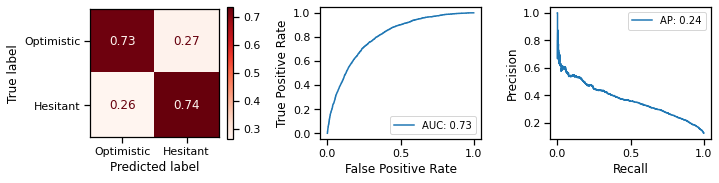

In [474]:
# Check out results on test for recall optizmiation
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=600, 
                        solver='saga')
lr.fit(X_train_df[v1_cols], y_train)

eval_clf_model(lr, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.75      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6074
        Training Macro Recall = 0.7327
   Training Balanced Accuracy = 0.7327



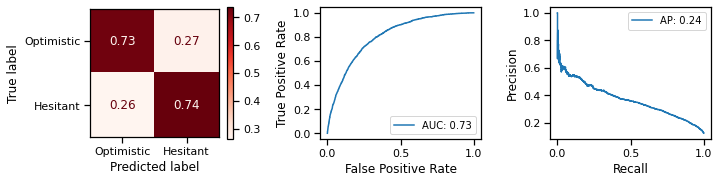

In [475]:
# Check out results on test for F1 optizmiation
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=600, 
                        solver='saga', penalty='l1')
lr.fit(X_train_df[v1_cols], y_train)

eval_clf_model(lr, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

**Recall**
- Train-Test Macro F1 Diff = 0.0065
- Train-Test Macro Recall Diff = -0.0007
- Train-Test Balanced Accuracy Diff = -0.0007

**F1**
- Train-Test Macro F1 Diff = 0.0070
- Train-Test Macro Recall Diff = 0.0003
- Train-Test Balanced Accuracy Diff = 0.0003

These aren't much different, they're both pretty good, with very small differences between training and test.

I think F1 is a better balance, so I'm going to use those params.

### Random Forest

In [478]:
# Random Forest, optimized for f1_macro
rf = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [5, 10, 30],
    'min_samples_split': [1, 5, 20],
    'min_impurity_decrease': [0, 0.01, 0.02],
    'max_features': [10, 20],
    'max_leaf_nodes': [6000, 2000, 500]
}

gs_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1,  verbose=True)

if rerun_gridsearch:
    gs_rf.fit(X_train_df[v1_cols], y_train)

    print(gs_rf.best_estimator_)
    print(gs_rf.best_score_)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  7.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 24.0min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 45.0min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 58.9min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 77.1min finished


RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=30, max_features=20, max_leaf_nodes=2000,
                       min_impurity_decrease=0, min_samples_split=20)
0.6544043696030634


**Best RandomForest params optimizing for F1_macro**:
- RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=30, max_features=20, max_leaf_nodes=2000,                 min_impurity_decrease=0, min_samples_split=20)
- 0.6544043696030634

This is pretty close to the F1 macro I got using only max_depth = 10.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96     51283
         1.0       0.64      0.91      0.76      7085

    accuracy                           0.93     58368
   macro avg       0.82      0.92      0.86     58368
weighted avg       0.95      0.93      0.93     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.90      0.91     17037
         1.0       0.38      0.43      0.41      2420

    accuracy                           0.84     19457
   macro avg       0.65      0.67      0.66     19457
weighted avg       0.85      0.84      0.85     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.8565
        Training Macro Recall = 0.9213
   Training Balanced Accuracy = 0.9213



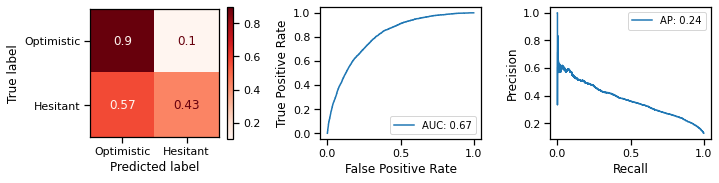

In [479]:
# Review model performance for a model with these optimal params
rf = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                            max_depth=30, max_features=20, 
                            max_leaf_nodes=2000, min_samples_split=20)


rf.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

Not great on test. Let's take out some of the params that were at the high end of my grid search; maybe they were the best just because they were highest, and higher would actually be better.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.98     51283
         1.0       0.77      0.93      0.84      7085

    accuracy                           0.96     58368
   macro avg       0.88      0.95      0.91     58368
weighted avg       0.96      0.96      0.96     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.91      0.93      0.92     17037
         1.0       0.42      0.36      0.39      2420

    accuracy                           0.86     19457
   macro avg       0.67      0.65      0.66     19457
weighted avg       0.85      0.86      0.85     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.908
        Training Macro Recall = 0.9457
   Training Balanced Accuracy = 0.9457

*

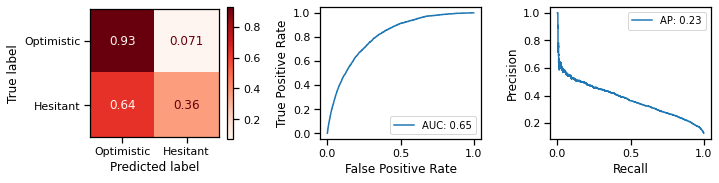

In [480]:
# Review model performance for a model with optimal params that weren't the
# max in the grid search.
rf = RandomForestClassifier(class_weight='balanced', criterion='entropy', 
                            min_samples_split=20)


rf.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

In [481]:
# How about trying another grid search with just max_depth and criterion?
rf = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [5, 10, 30]
}

gs_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)


gs_rf.fit(X_train_df[v1_cols], y_train)

print(gs_rf.best_estimator_)
print(gs_rf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.6min finished


RandomForestClassifier(class_weight='balanced', max_depth=10)
0.624889713409605


****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     51283
         1.0       0.34      0.79      0.47      7085

    accuracy                           0.78     58368
   macro avg       0.65      0.79      0.67     58368
weighted avg       0.89      0.78      0.82     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85     17037
         1.0       0.29      0.67      0.41      2420

    accuracy                           0.76     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.76      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6679
        Training Macro Recall = 0.7877
   Training Balanced Accuracy = 0.7877



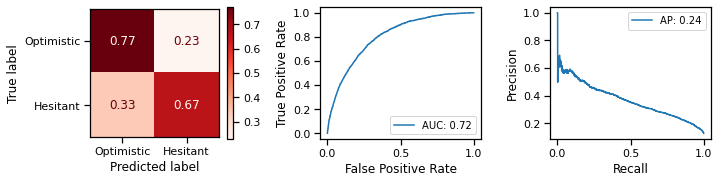

In [482]:
rf = RandomForestClassifier(class_weight='balanced', max_depth=10)


rf.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

## Feature Selection: Imbalanced

### Variance Threshold


In [346]:
# I'm pretty sure from my EDA that I don't have any features with 0 variance
# so I'm going to start with a threshold of .95

# since most of my variables are OHE, I'll use the formula p(1-p) to generate
# the appropriate variace threshold 
# More here: (https://scikit-learn.org/stable/modules/feature_selection.html)
threshold = 0.99*(1-0.99)

sel = VarianceThreshold(threshold)
sel.fit(X_train_df)

# Review columns to be removed
list(X_train_df.loc[:, sel.get_support()==False].head().columns)

['skipped',
 'DELAY_-1.0',
 'EIP_-1.0',
 'FEWRTRANS_-1.0',
 'FEWRTRIPS_-1.0',
 'FREEFOOD_-1.0',
 'MH_NOTGET_-1.0',
 'MH_SVCS_-1.0',
 'NOTGET_-1.0',
 'PLNDTRIPS_-1.0',
 'PRESCRIPT_-1.0',
 'SNAP_YN_-1.0',
 'SSA_APPLY_-1.0',
 'SSA_RECV_-1.0',
 'TENURE_-1.0',
 'UI_APPLY_-1.0',
 'ANXIOUS_-1.0',
 'DOWN_-1.0',
 'INTEREST_-1.0',
 'WORRY_-1.0',
 'HLTHINS7_1.0',
 'LIVQTR_-1.0',
 'LIVQTR_10.0',
 'HLTHINS_-1.0',
 'LIVQTR_2_-1.0',
 'LIVQTR_2_4.0',
 'ANYWORK_-1.0',
 'EXPCTLOSS_-1.0',
 'HADCOVID_-1.0',
 'WRKLOSS_-1.0',
 'MS_-1.0',
 'MS_2_-1.0',
 'CURFOODSUF_skipped_0.0',
 'CURFOODSUF_skipped_1.0',
 'EXPNS_DIF_skipped_0.0',
 'EXPNS_DIF_skipped_1.0']

Almost all of these are skipped indicator columns for specific questions, which makes sense because those are sparsely populated. 

I'll come back to this if the other processes don't filter these features out using their methods.

### Univariate Feature Selection
There are 3 different algorithms to univariate feature selection methods that are suitable for classification problems. I decided to try each one out and give them an equal vote in terms of which features to keep.

For each algorithm, I asked for `k=50` features.

In [347]:
# using mutual info
selk = SelectKBest(mutual_info_classif, k=50)
selk.fit(X_train_df, y_train)

# Review features that it would keep
keep50_mutual = list(X_train_df.loc[:, selk.get_support()].head().columns)
keep50_mutual

['EXPNS_DIF',
 'THHLD_NUMKID',
 'AGE',
 'EEDUC',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW10_0.0',
 'CHNGHOW11_0.0',
 'CHNGHOW12_0.0',
 'CHNGHOW2_0.0',
 'CHNGHOW3_0.0',
 'CHNGHOW4_0.0',
 'CHNGHOW5_0.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_0.0',
 'MH_NOTGET_0.0',
 'PLNDTRIPS_1.0',
 'SNAP_YN_0.0',
 'SPNDSRC1_1.0',
 'SPNDSRC2_0.0',
 'SPNDSRC3_0.0',
 'SPNDSRC4_0.0',
 'SPNDSRC5_0.0',
 'SPNDSRC6_0.0',
 'SPNDSRC7_0.0',
 'SSA_APPLY_0.0',
 'SSA_RECV_0.0',
 'UI_APPLY_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_0.0',
 'HLTHINS_1.0',
 'LIVQTR_2_2.0',
 'EXPCTLOSS_0.0',
 'HADCOVID_0.0',
 'RHISPANIC_0.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_0.0',
 'inc_binary_0.0',
 'IN_METRO_AREA_0.0',
 'SCHOOL_KIDS_0.0',
 'PROP_FOODSPEND_HOME_skipped_0.0',
 'TNUM_PS_skipped_0.0',
 'CURFOODSUF_skipped_0.0',
 'EXPNS_DIF_skipped_0.0',
 'INCOME_skipped_0.0']

In [348]:
# Using chi2
selk2 = SelectKBest(chi2, k=50)
selk2.fit(X_train_df, y_train)

# Review features that it would keep
keep50_chi2 = list(X_train_df.loc[:, selk2.get_support()].head().columns)
keep50_chi2

['EXPNS_DIF',
 'THHLD_NUMKID',
 'AGE',
 'EEDUC',
 'CURFOODSUF',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW9_1.0',
 'EIP_3.0',
 'FEWRTRANS_1.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'PLNDTRIPS_0.0',
 'SNAP_YN_1.0',
 'SPNDSRC1_0.0',
 'SPNDSRC4_1.0',
 'SSA_RECV_0.0',
 'SSA_RECV_1.0',
 'TENURE_1.0',
 'TENURE_3.0',
 'UI_APPLY_1.0',
 'ANXIOUS_2.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_1.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'LIVQTR_1.0',
 'HLTHINS_0.0',
 'LIVQTR_2_1.0',
 'EXPCTLOSS_1.0',
 'HADCOVID_1.0',
 'RRACE_3.0',
 'RRACE_4.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_0.0',
 'WRKLOSS_1.0',
 'polit_0',
 'polit_1',
 'IN_METRO_AREA_1.0',
 'SCHOOL_KIDS_1.0']

In [349]:
# Using f
selk3 = SelectKBest(f_classif, k=50)
selk3.fit(X_train_df, y_train)

# Review features that it would keep
keep50_f = list(X_train_df.loc[:, selk3.get_support()].head().columns)
keep50_f

['EXPNS_DIF',
 'INCOME',
 'THHLD_NUMKID',
 'AGE',
 'EEDUC',
 'CURFOODSUF',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'FEWRTRANS_1.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'PLNDTRIPS_0.0',
 'PLNDTRIPS_1.0',
 'SNAP_YN_0.0',
 'SNAP_YN_1.0',
 'SPNDSRC1_1.0',
 'SPNDSRC4_0.0',
 'SPNDSRC4_1.0',
 'SSA_RECV_0.0',
 'SSA_RECV_1.0',
 'TENURE_1.0',
 'UI_APPLY_0.0',
 'UI_APPLY_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_1.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'LIVQTR_1.0',
 'HLTHINS_0.0',
 'HLTHINS_1.0',
 'LIVQTR_2_1.0',
 'EXPCTLOSS_0.0',
 'EXPCTLOSS_1.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_0.0',
 'WRKLOSS_1.0',
 'polit_0',
 'polit_1',
 'SCHOOL_KIDS_0.0',
 'SCHOOL_KIDS_1.0']

### Select From Model - Logit
When I ran logistic regression, it found that L2 was the best performing regularization technique with `saga` solver, but now I'll use L1 Lasso with a  to see how well it can reduce features for me.

I also tried this with a LinearSVC model, but even at 4000 max iterations, it failed to converge.

I used a CV Logistic Regression model here since it will try different values of C for the penalty and choose the best one. I want my feature selection to be based on the model with the best f1 score.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.27      0.74      0.40      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.61     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.74      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.62      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Score Comparison ******************************
Training F1 = 0.3952
Training Accuracy = 0.7236
Test F1 = 0.4049
Test Accuracy = 0.7291

****************************

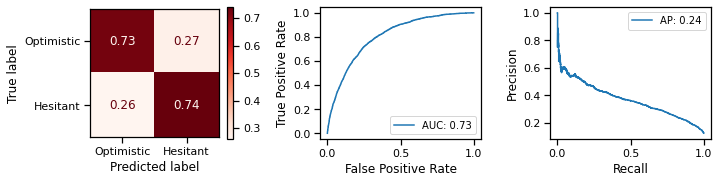

In [354]:
# fitting on all columns, since will be using for feature selection
# Using best CV params optimizing for F1_macro, which happens to be for l1 also
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=300, 
                        class_weight='balanced')
lr.fit(X_train_df, y_train)

eval_clf_model(lr, X_test_df, y_test, X_train_df, y_train, labels=labels)

In [355]:
model_sel = SelectFromModel(lr, prefit=True)
model_sel.get_support()

array([ True,  True, False,  True,  True, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [356]:
# what would it get rid of?
keep_lr = list(X_train_df.loc[:, model_sel.get_support()==False].head().columns)
keep_lr

['skipped',
 'incomplete',
 'FEWRTRIPS_-1.0',
 'PLNDTRIPS_-1.0',
 'LIVQTR_2.0',
 'LIVQTR_4.0',
 'ANYWORK_1.0',
 'EXPCTLOSS_0.0',
 'HADCOVID_1.0',
 'TW_START_-1.0',
 'WRKLOSS_1.0',
 'THHLD_NUMADLT_2.0',
 'EST_MSA_33100.0',
 'EST_MSA_35620.0',
 'inc_binary_0.0',
 'inc_binary_1.0',
 'CURFOODSUF_skipped_0.0',
 'CURFOODSUF_skipped_1.0']

### Select from Model - Forest

I started with a max depth of 1, but figured it wasn't enough splits to let each tree decide on different combinations of features. I tried at both 3 and 5, and 5 created a model that performed well on test and similarly on both test and train.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87     51283
         1.0       0.34      0.79      0.47      7085

    accuracy                           0.79     58368
   macro avg       0.65      0.79      0.67     58368
weighted avg       0.89      0.79      0.82     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.78      0.85     17037
         1.0       0.30      0.67      0.41      2420

    accuracy                           0.76     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.76      0.80     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6709
        Training Macro Recall = 0.7882
   Training Balanced Accuracy = 0.7882



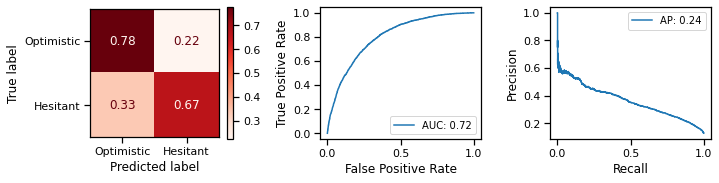

In [483]:
# Using best minimal params from grid search
rf = RandomForestClassifier(max_depth=10,
                            class_weight='balanced')

rf.fit(X_train_df, y_train)

eval_clf_model(rf, X_test_df, y_test, X_train_df, y_train, labels=labels)

In [484]:
model_sel_f = SelectFromModel(rf, prefit=True)
model_sel_f.get_support()

array([ True,  True,  True,  True,  True, False,  True,  True, False,
        True,  True,  True, False, False, False, False,  True,  True,
       False, False, False, False, False,  True, False, False,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False, False, False,  True,  True,  True,  True,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False,  True, False, False, False, False,  True,  True, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False,  True, False, False, False, False,  True,
        True, False,

In [485]:
# what would it keep?
keep_tree = list(X_train_df.loc[:, model_sel_f.get_support()].head().columns)
keep_tree

['EXPNS_DIF',
 'INCOME',
 'skipped',
 'THHLD_NUMKID',
 'AGE',
 'EEDUC',
 'PROP_FOODSPEND_HOME',
 'CURFOODSUF',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'PLNDTRIPS_0.0',
 'PLNDTRIPS_1.0',
 'SNAP_YN_0.0',
 'SNAP_YN_1.0',
 'SPNDSRC1_0.0',
 'SPNDSRC1_1.0',
 'SPNDSRC4_0.0',
 'SSA_RECV_0.0',
 'SSA_RECV_1.0',
 'TENURE_1.0',
 'UI_APPLY_0.0',
 'UI_APPLY_1.0',
 'ANXIOUS_2.0',
 'HLTHINS1_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_1.0',
 'ENROLL1_1.0',
 'ENROLL3_-1.0',
 'HLTHINS_0.0',
 'HADCOVID_0.0',
 'HADCOVID_1.0',
 'RRACE_3.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_0.0',
 'WRKLOSS_1.0',
 'polit_0',
 'polit_1',
 'EST_MSA_0.0',
 'IN_METRO_AREA_1.0',
 'SCHOOL_KIDS_0.0',
 'SCHOOL_KIDS_1.0']

This looks pretty reasonable.

Let's compare features across the different feature selection methods and see which are most commonly kept.

### Combine Votes for Features

In [486]:
feat_dict = {
    'univ_mutual' : list(selk.get_support()),
    'univ_chi2' : list(selk2.get_support()),
    'univ_f' : list(selk3.get_support()),
    'model_lr' : list(model_sel.get_support()),
    'model_rf' : list(model_sel_f.get_support())
    }

feat_votes_ib = pd.DataFrame.from_dict(feat_dict, orient='index', 
                                    columns=X_train_df.columns)

feat_votes_ib

,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,CHNGHOW1_0.0,CHNGHOW1_1.0,CHNGHOW10_0.0,CHNGHOW10_1.0,CHNGHOW11_0.0,CHNGHOW11_1.0,CHNGHOW12_0.0,CHNGHOW12_1.0,CHNGHOW2_0.0,CHNGHOW2_1.0,CHNGHOW3_0.0,CHNGHOW3_1.0,CHNGHOW4_0.0,CHNGHOW4_1.0,CHNGHOW5_0.0,CHNGHOW5_1.0,CHNGHOW6_0.0,CHNGHOW6_1.0,CHNGHOW7_0.0,CHNGHOW7_1.0,CHNGHOW8_0.0,CHNGHOW8_1.0,CHNGHOW9_0.0,CHNGHOW9_1.0,DELAY_-1.0,DELAY_0.0,DELAY_1.0,EIP_-1.0,EIP_1.0,EIP_2.0,EIP_3.0,EIP_4.0,FEWRTRANS_-1.0,FEWRTRANS_1.0,FEWRTRANS_2.0,FEWRTRANS_3.0,FEWRTRIPS_-1.0,FEWRTRIPS_0.0,FEWRTRIPS_1.0,FREEFOOD_-1.0,FREEFOOD_0.0,FREEFOOD_1.0,MH_NOTGET_-1.0,MH_NOTGET_0.0,MH_NOTGET_1.0,MH_SVCS_-1.0,MH_SVCS_0.0,MH_SVCS_1.0,NOTGET_-1.0,NOTGET_0.0,NOTGET_1.0,PLNDTRIPS_-1.0,PLNDTRIPS_0.0,PLNDTRIPS_1.0,PRESCRIPT_-1.0,PRESCRIPT_0.0,PRESCRIPT_1.0,SNAP_YN_-1.0,SNAP_YN_0.0,SNAP_YN_1.0,SPNDSRC1_0.0,SPNDSRC1_1.0,SPNDSRC2_0.0,SPNDSRC2_1.0,SPNDSRC3_0.0,SPNDSRC3_1.0,SPNDSRC4_0.0,SPNDSRC4_1.0,SPNDSRC5_0.0,SPNDSRC5_1.0,SPNDSRC6_0.0,SPNDSRC6_1.0,SPNDSRC7_0.0,SPNDSRC7_1.0,SSA_APPLY_-1.0,SSA_APPLY_0.0,SSA_APPLY_1.0,SSA_RECV_-1.0,SSA_RECV_0.0,SSA_RECV_1.0,TENURE_-1.0,TENURE_1.0,TENURE_2.0,TENURE_3.0,TENURE_4.0,UI_APPLY_-1.0,UI_APPLY_0.0,UI_APPLY_1.0,ANXIOUS_-1.0,ANXIOUS_1.0,ANXIOUS_2.0,ANXIOUS_3.0,ANXIOUS_4.0,DOWN_-1.0,DOWN_1.0,DOWN_2.0,DOWN_3.0,DOWN_4.0,INTEREST_-1.0,INTEREST_1.0,INTEREST_2.0,INTEREST_3.0,INTEREST_4.0,WORRY_-1.0,WORRY_1.0,WORRY_2.0,WORRY_3.0,WORRY_4.0,HLTHINS1_-1.0,HLTHINS1_0.0,HLTHINS1_1.0,HLTHINS2_-1.0,HLTHINS2_0.0,HLTHINS2_1.0,HLTHINS3_-1.0,HLTHINS3_0.0,HLTHINS3_1.0,HLTHINS4_-1.0,HLTHINS4_0.0,HLTHINS4_1.0,HLTHINS5_-1.0,HLTHINS5_0.0,HLTHINS5_1.0,HLTHINS6_-1.0,HLTHINS6_0.0,HLTHINS6_1.0,HLTHINS7_-1.0,HLTHINS7_0.0,HLTHINS7_1.0,HLTHINS8_-1.0,HLTHINS8_0.0,HLTHINS8_1.0,ENROLL1_-1.0,ENROLL1_1.0,ENROLL2_-1.0,ENROLL2_1.0,ENROLL3_-1.0,ENROLL3_1.0,LIVQTR_-1.0,LIVQTR_1.0,LIVQTR_2.0,LIVQTR_3.0,LIVQTR_4.0,LIVQTR_5.0,LIVQTR_6.0,LIVQTR_7.0,LIVQTR_8.0,LIVQTR_9.0,LIVQTR_10.0,HLTHINS_-1.0,HLTHINS_0.0,HLTHINS_1.0,LIVQTR_2_-1.0,LIVQTR_2_1.0,LIVQTR_2_2.0,LIVQTR_2_3.0,LIVQTR_2_4.0,TNUM_PS_2_-1.0,TNUM_PS_2_0.0,TNUM_PS_2_1.0,ANYWORK_-1.0,ANYWORK_0.0,ANYWORK_1.0,EGENDER_0.0,EGENDER_1.0,EXPCTLOSS_-1.0,EXPCTLOSS_0.0,EXPCTLOSS_1.0,HADCOVID_-1.0,HADCOVID_0.0,HADCOVID_1.0,RHISPANIC_0.0,RHISPANIC_1.0,RRACE_1.0,RRACE_2.0,RRACE_3.0,RRACE_4.0,TW_START_-1.0,TW_START_0.0,TW_START_1.0,WRKLOSS_-1.0,WRKLOSS_0.0,WRKLOSS_1.0,THHLD_NUMADLT_1.0,THHLD_NUMADLT_2.0,THHLD_NUMADLT_3.0,polit_0,polit_1,EST_MSA_0.0,EST_MSA_12060.0,EST_MSA_14460.0,EST_MSA_16980.0,EST_MSA_19100.0,EST_MSA_19820.0,EST_MSA_26420.0,EST_MSA_31080.0,EST_MSA_33100.0,EST_MSA_35620.0,EST_MSA_37980.0,EST_MSA_38060.0,EST_MSA_40140.0,EST_MSA_41860.0,EST_MSA_42660.0,EST_MSA_47900.0,MS_-1.0,MS_1.0,MS_2.0,MS_3.0,MS_4.0,MS_5.0,inc_binary_0.0,inc_binary_1.0,IN_METRO_AREA_0.0,IN_METRO_AREA_1.0,SCHOOL_KIDS_0.0,SCHOOL_KIDS_1.0,MS_2_-1.0,MS_2_1.0,MS_2_2.0,MS_2_3.0,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
univ_mutual,True,False,False,True,True,False,True,False,False,False,True,True,True,False,True,False,True,False,True,False,True,False,True,False,True,False,True,True,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,False,False,True,False,False,True,True,False,True,False,True,False,True,False,True,False,True,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,Fals

In [487]:
# really useful: https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
feat_votes_ib = feat_votes_ib*1


feat_votes_ib

,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,CHNGHOW1_0.0,CHNGHOW1_1.0,CHNGHOW10_0.0,CHNGHOW10_1.0,CHNGHOW11_0.0,CHNGHOW11_1.0,CHNGHOW12_0.0,CHNGHOW12_1.0,CHNGHOW2_0.0,CHNGHOW2_1.0,CHNGHOW3_0.0,CHNGHOW3_1.0,CHNGHOW4_0.0,CHNGHOW4_1.0,CHNGHOW5_0.0,CHNGHOW5_1.0,CHNGHOW6_0.0,CHNGHOW6_1.0,CHNGHOW7_0.0,CHNGHOW7_1.0,CHNGHOW8_0.0,CHNGHOW8_1.0,CHNGHOW9_0.0,CHNGHOW9_1.0,DELAY_-1.0,DELAY_0.0,DELAY_1.0,EIP_-1.0,EIP_1.0,EIP_2.0,EIP_3.0,EIP_4.0,FEWRTRANS_-1.0,FEWRTRANS_1.0,FEWRTRANS_2.0,FEWRTRANS_3.0,FEWRTRIPS_-1.0,FEWRTRIPS_0.0,FEWRTRIPS_1.0,FREEFOOD_-1.0,FREEFOOD_0.0,FREEFOOD_1.0,MH_NOTGET_-1.0,MH_NOTGET_0.0,MH_NOTGET_1.0,MH_SVCS_-1.0,MH_SVCS_0.0,MH_SVCS_1.0,NOTGET_-1.0,NOTGET_0.0,NOTGET_1.0,PLNDTRIPS_-1.0,PLNDTRIPS_0.0,PLNDTRIPS_1.0,PRESCRIPT_-1.0,PRESCRIPT_0.0,PRESCRIPT_1.0,SNAP_YN_-1.0,SNAP_YN_0.0,SNAP_YN_1.0,SPNDSRC1_0.0,SPNDSRC1_1.0,SPNDSRC2_0.0,SPNDSRC2_1.0,SPNDSRC3_0.0,SPNDSRC3_1.0,SPNDSRC4_0.0,SPNDSRC4_1.0,SPNDSRC5_0.0,SPNDSRC5_1.0,SPNDSRC6_0.0,SPNDSRC6_1.0,SPNDSRC7_0.0,SPNDSRC7_1.0,SSA_APPLY_-1.0,SSA_APPLY_0.0,SSA_APPLY_1.0,SSA_RECV_-1.0,SSA_RECV_0.0,SSA_RECV_1.0,TENURE_-1.0,TENURE_1.0,TENURE_2.0,TENURE_3.0,TENURE_4.0,UI_APPLY_-1.0,UI_APPLY_0.0,UI_APPLY_1.0,ANXIOUS_-1.0,ANXIOUS_1.0,ANXIOUS_2.0,ANXIOUS_3.0,ANXIOUS_4.0,DOWN_-1.0,DOWN_1.0,DOWN_2.0,DOWN_3.0,DOWN_4.0,INTEREST_-1.0,INTEREST_1.0,INTEREST_2.0,INTEREST_3.0,INTEREST_4.0,WORRY_-1.0,WORRY_1.0,WORRY_2.0,WORRY_3.0,WORRY_4.0,HLTHINS1_-1.0,HLTHINS1_0.0,HLTHINS1_1.0,HLTHINS2_-1.0,HLTHINS2_0.0,HLTHINS2_1.0,HLTHINS3_-1.0,HLTHINS3_0.0,HLTHINS3_1.0,HLTHINS4_-1.0,HLTHINS4_0.0,HLTHINS4_1.0,HLTHINS5_-1.0,HLTHINS5_0.0,HLTHINS5_1.0,HLTHINS6_-1.0,HLTHINS6_0.0,HLTHINS6_1.0,HLTHINS7_-1.0,HLTHINS7_0.0,HLTHINS7_1.0,HLTHINS8_-1.0,HLTHINS8_0.0,HLTHINS8_1.0,ENROLL1_-1.0,ENROLL1_1.0,ENROLL2_-1.0,ENROLL2_1.0,ENROLL3_-1.0,ENROLL3_1.0,LIVQTR_-1.0,LIVQTR_1.0,LIVQTR_2.0,LIVQTR_3.0,LIVQTR_4.0,LIVQTR_5.0,LIVQTR_6.0,LIVQTR_7.0,LIVQTR_8.0,LIVQTR_9.0,LIVQTR_10.0,HLTHINS_-1.0,HLTHINS_0.0,HLTHINS_1.0,LIVQTR_2_-1.0,LIVQTR_2_1.0,LIVQTR_2_2.0,LIVQTR_2_3.0,LIVQTR_2_4.0,TNUM_PS_2_-1.0,TNUM_PS_2_0.0,TNUM_PS_2_1.0,ANYWORK_-1.0,ANYWORK_0.0,ANYWORK_1.0,EGENDER_0.0,EGENDER_1.0,EXPCTLOSS_-1.0,EXPCTLOSS_0.0,EXPCTLOSS_1.0,HADCOVID_-1.0,HADCOVID_0.0,HADCOVID_1.0,RHISPANIC_0.0,RHISPANIC_1.0,RRACE_1.0,RRACE_2.0,RRACE_3.0,RRACE_4.0,TW_START_-1.0,TW_START_0.0,TW_START_1.0,WRKLOSS_-1.0,WRKLOSS_0.0,WRKLOSS_1.0,THHLD_NUMADLT_1.0,THHLD_NUMADLT_2.0,THHLD_NUMADLT_3.0,polit_0,polit_1,EST_MSA_0.0,EST_MSA_12060.0,EST_MSA_14460.0,EST_MSA_16980.0,EST_MSA_19100.0,EST_MSA_19820.0,EST_MSA_26420.0,EST_MSA_31080.0,EST_MSA_33100.0,EST_MSA_35620.0,EST_MSA_37980.0,EST_MSA_38060.0,EST_MSA_40140.0,EST_MSA_41860.0,EST_MSA_42660.0,EST_MSA_47900.0,MS_-1.0,MS_1.0,MS_2.0,MS_3.0,MS_4.0,MS_5.0,inc_binary_0.0,inc_binary_1.0,IN_METRO_AREA_0.0,IN_METRO_AREA_1.0,SCHOOL_KIDS_0.0,SCHOOL_KIDS_1.0,MS_2_-1.0,MS_2_1.0,MS_2_2.0,MS_2_3.0,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
univ_mutual,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
univ_chi2,1,0,0,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,

In [488]:
votes_ib = feat_votes_ib.sum(axis=0)
sorted_votes_ib = votes_ib.sort_values(ascending=False)
print(list(sorted_votes_ib))

[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


It looks like there are a decent number of features that at least 2 of these feature selection methods voted for. I'm inclined to go with those, but let's take a look at what will be dropped if we exclude features that only 1 or no methods voted for.

In [489]:
# What are the features that only process voted for? Are they all different processes?
with pd.option_context('display.max_columns',300):
    display(feat_votes_ib)

,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,CHNGHOW1_0.0,CHNGHOW1_1.0,CHNGHOW10_0.0,CHNGHOW10_1.0,CHNGHOW11_0.0,CHNGHOW11_1.0,CHNGHOW12_0.0,CHNGHOW12_1.0,CHNGHOW2_0.0,CHNGHOW2_1.0,CHNGHOW3_0.0,CHNGHOW3_1.0,CHNGHOW4_0.0,CHNGHOW4_1.0,CHNGHOW5_0.0,CHNGHOW5_1.0,CHNGHOW6_0.0,CHNGHOW6_1.0,CHNGHOW7_0.0,CHNGHOW7_1.0,CHNGHOW8_0.0,CHNGHOW8_1.0,CHNGHOW9_0.0,CHNGHOW9_1.0,DELAY_-1.0,DELAY_0.0,DELAY_1.0,EIP_-1.0,EIP_1.0,EIP_2.0,EIP_3.0,EIP_4.0,FEWRTRANS_-1.0,FEWRTRANS_1.0,FEWRTRANS_2.0,FEWRTRANS_3.0,FEWRTRIPS_-1.0,FEWRTRIPS_0.0,FEWRTRIPS_1.0,FREEFOOD_-1.0,FREEFOOD_0.0,FREEFOOD_1.0,MH_NOTGET_-1.0,MH_NOTGET_0.0,MH_NOTGET_1.0,MH_SVCS_-1.0,MH_SVCS_0.0,MH_SVCS_1.0,NOTGET_-1.0,NOTGET_0.0,NOTGET_1.0,PLNDTRIPS_-1.0,PLNDTRIPS_0.0,PLNDTRIPS_1.0,PRESCRIPT_-1.0,PRESCRIPT_0.0,PRESCRIPT_1.0,SNAP_YN_-1.0,SNAP_YN_0.0,SNAP_YN_1.0,SPNDSRC1_0.0,SPNDSRC1_1.0,SPNDSRC2_0.0,SPNDSRC2_1.0,SPNDSRC3_0.0,SPNDSRC3_1.0,SPNDSRC4_0.0,SPNDSRC4_1.0,SPNDSRC5_0.0,SPNDSRC5_1.0,SPNDSRC6_0.0,SPNDSRC6_1.0,SPNDSRC7_0.0,SPNDSRC7_1.0,SSA_APPLY_-1.0,SSA_APPLY_0.0,SSA_APPLY_1.0,SSA_RECV_-1.0,SSA_RECV_0.0,SSA_RECV_1.0,TENURE_-1.0,TENURE_1.0,TENURE_2.0,TENURE_3.0,TENURE_4.0,UI_APPLY_-1.0,UI_APPLY_0.0,UI_APPLY_1.0,ANXIOUS_-1.0,ANXIOUS_1.0,ANXIOUS_2.0,ANXIOUS_3.0,ANXIOUS_4.0,DOWN_-1.0,DOWN_1.0,DOWN_2.0,DOWN_3.0,DOWN_4.0,INTEREST_-1.0,INTEREST_1.0,INTEREST_2.0,INTEREST_3.0,INTEREST_4.0,WORRY_-1.0,WORRY_1.0,WORRY_2.0,WORRY_3.0,WORRY_4.0,HLTHINS1_-1.0,HLTHINS1_0.0,HLTHINS1_1.0,HLTHINS2_-1.0,HLTHINS2_0.0,HLTHINS2_1.0,HLTHINS3_-1.0,HLTHINS3_0.0,HLTHINS3_1.0,HLTHINS4_-1.0,HLTHINS4_0.0,HLTHINS4_1.0,HLTHINS5_-1.0,HLTHINS5_0.0,HLTHINS5_1.0,HLTHINS6_-1.0,HLTHINS6_0.0,HLTHINS6_1.0,HLTHINS7_-1.0,HLTHINS7_0.0,HLTHINS7_1.0,HLTHINS8_-1.0,HLTHINS8_0.0,HLTHINS8_1.0,ENROLL1_-1.0,ENROLL1_1.0,ENROLL2_-1.0,ENROLL2_1.0,ENROLL3_-1.0,ENROLL3_1.0,LIVQTR_-1.0,LIVQTR_1.0,LIVQTR_2.0,LIVQTR_3.0,LIVQTR_4.0,LIVQTR_5.0,LIVQTR_6.0,LIVQTR_7.0,LIVQTR_8.0,LIVQTR_9.0,LIVQTR_10.0,HLTHINS_-1.0,HLTHINS_0.0,HLTHINS_1.0,LIVQTR_2_-1.0,LIVQTR_2_1.0,LIVQTR_2_2.0,LIVQTR_2_3.0,LIVQTR_2_4.0,TNUM_PS_2_-1.0,TNUM_PS_2_0.0,TNUM_PS_2_1.0,ANYWORK_-1.0,ANYWORK_0.0,ANYWORK_1.0,EGENDER_0.0,EGENDER_1.0,EXPCTLOSS_-1.0,EXPCTLOSS_0.0,EXPCTLOSS_1.0,HADCOVID_-1.0,HADCOVID_0.0,HADCOVID_1.0,RHISPANIC_0.0,RHISPANIC_1.0,RRACE_1.0,RRACE_2.0,RRACE_3.0,RRACE_4.0,TW_START_-1.0,TW_START_0.0,TW_START_1.0,WRKLOSS_-1.0,WRKLOSS_0.0,WRKLOSS_1.0,THHLD_NUMADLT_1.0,THHLD_NUMADLT_2.0,THHLD_NUMADLT_3.0,polit_0,polit_1,EST_MSA_0.0,EST_MSA_12060.0,EST_MSA_14460.0,EST_MSA_16980.0,EST_MSA_19100.0,EST_MSA_19820.0,EST_MSA_26420.0,EST_MSA_31080.0,EST_MSA_33100.0,EST_MSA_35620.0,EST_MSA_37980.0,EST_MSA_38060.0,EST_MSA_40140.0,EST_MSA_41860.0,EST_MSA_42660.0,EST_MSA_47900.0,MS_-1.0,MS_1.0,MS_2.0,MS_3.0,MS_4.0,MS_5.0,inc_binary_0.0,inc_binary_1.0,IN_METRO_AREA_0.0,IN_METRO_AREA_1.0,SCHOOL_KIDS_0.0,SCHOOL_KIDS_1.0,MS_2_-1.0,MS_2_1.0,MS_2_2.0,MS_2_3.0,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
univ_mutual,1,0,0,1,1,0,1,0,0,0,1,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,1,0,1,0,1,0,1,0
univ_chi2,1,0,0,1,1,0,1,0,0,1,1,1,0,0,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,

In [491]:
#These columns would be kept
to_keep_ib = list(sorted_votes_ib.loc[sorted_votes_ib >= 2].index)
to_keep_ib.sort()

display(to_keep_ib)

['AGE',
 'ANXIOUS_2.0',
 'CHNGHOW10_0.0',
 'CHNGHOW11_0.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'EEDUC',
 'EIP_3.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'EST_MSA_0.0',
 'EXPCTLOSS_0.0',
 'EXPCTLOSS_1.0',
 'EXPNS_DIF',
 'EXPNS_DIF_skipped_0.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_0.0',
 'HADCOVID_0.0',
 'HADCOVID_1.0',
 'HLTHINS1_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_0.0',
 'HLTHINS4_1.0',
 'HLTHINS_0.0',
 'HLTHINS_1.0',
 'INCOME',
 'INCOME_skipped_0.0',
 'IN_METRO_AREA_0.0',
 'IN_METRO_AREA_1.0',
 'LIVQTR_1.0',
 'LIVQTR_2_1.0',
 'LIVQTR_2_2.0',
 'MH_NOTGET_0.0',
 'PLNDTRIPS_0.0',
 'PLNDTRIPS_1.0',
 'PROP_FOODSPEND_HOME',
 'PROP_FOODSPEND_HOME_skipped_0.0',
 'RHISPANIC_0.0',
 'RRAC

Let's go through the features the selection processes voted to keep, and make sure all labels in a given category are kept in, since this process didn't account for groups of labels.

The only exception will be that I'm not going to add any _skipped or -1 features unless this process recommended them. 

In [492]:
all_cols = X_train_df.columns
fam_keep = []

for col in to_keep_ib:
    # anything that ends with a number .0 is a OHE column and I need to keep 
    # the related labels in the set
    if col.endswith('.0'):
        # get base root of the col name without label
        root = '_'.join(col.split('_')[:-1]) + '_'
        # get a list of matches of columns that start with the root
        fam_labels = [fam for fam in all_cols if fam.startswith(root)]
        fam_keep = fam_keep + fam_labels
    else:
        # if isn't OHE, keep it
        fam_keep.append(col)

# deduplicate the list
fam_keep = list(set(fam_keep))
fam_keep.sort()
fam_keep

['AGE',
 'ANXIOUS_-1.0',
 'ANXIOUS_1.0',
 'ANXIOUS_2.0',
 'ANXIOUS_3.0',
 'ANXIOUS_4.0',
 'CHNGHOW10_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'EEDUC',
 'EIP_-1.0',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'ENROLL1_-1.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'ENROLL3_1.0',
 'EST_MSA_0.0',
 'EST_MSA_12060.0',
 'EST_MSA_14460.0',
 'EST_MSA_16980.0',
 'EST_MSA_19100.0',
 'EST_MSA_19820.0',
 'EST_MSA_26420.0',
 'EST_MSA_31080.0',
 'EST_MSA_33100.0',
 'EST_MSA_35620.0',
 'EST_MSA_37980.0',
 'EST_MSA_38060.0',
 'EST_MSA_40140.0',
 'EST_MSA_41860.0',
 'EST_MSA_42660.0',
 'EST_MSA_47900.0',
 'EXPCTLOSS_-1.0',
 'EXPCTLOSS

In [493]:
# Take out all the individual -1 skipped columns and the skipped_0.0
fam_keep_pruned = [col for col in fam_keep if (not col.endswith('_-1.0')) & 
                                        (not col.endswith('_skipped_0.0'))]

# add back in the specific skipped columns that were selected as features
skipped = [col for col in to_keep_ib if col.endswith('_-1.0')]
final_keep = fam_keep_pruned + skipped
final_keep.sort()

final_keep

['AGE',
 'ANXIOUS_1.0',
 'ANXIOUS_2.0',
 'ANXIOUS_3.0',
 'ANXIOUS_4.0',
 'CHNGHOW10_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'EEDUC',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_-1.0',
 'ENROLL3_1.0',
 'EST_MSA_0.0',
 'EST_MSA_12060.0',
 'EST_MSA_14460.0',
 'EST_MSA_16980.0',
 'EST_MSA_19100.0',
 'EST_MSA_19820.0',
 'EST_MSA_26420.0',
 'EST_MSA_31080.0',
 'EST_MSA_33100.0',
 'EST_MSA_35620.0',
 'EST_MSA_37980.0',
 'EST_MSA_38060.0',
 'EST_MSA_40140.0',
 'EST_MSA_41860.0',
 'EST_MSA_42660.0',
 'EST_MSA_47900.0',
 'EXPCTLOSS_0.0',
 'EXPCTLOSS_1.0',
 'EXPNS_DIF',
 'EXPNS_DIF_skipped_1.0',
 

In [494]:
# Review multicollinearity between HLTHINS original and engineered features
with pd.option_context('display.max_rows', 200):
    display(sorted_corr.loc[((sorted_corr[0] > 0.8)|(sorted_corr[0] < -0.8))
                            & ((sorted_corr['level_0'].str.startswith('HLTHINS'))
                            & (sorted_corr['level_1'].str.startswith('HLTHINS'))), 
                            ['combo', 0]])

,combo,0
5766,HLTHINS2 / HLTHINS4,0.805122
5772,HLTHINS2 / HLTHINS8,0.806143
5782,HLTHINS3 / HLTHINS6,0.807803
5792,HLTHINS3 / HLTHINS5,0.809857
5800,HLTHINS3 / HLTHINS7,0.813224
5822,HLTHINS1 / HLTHINS7,0.821292
5830,HLTHINS2 / HLTHINS5,0.825915
5832,HLTHINS2 / HLTHINS6,0.827238
5840,HLTHINS / HLTHINS2,0.829094
5864,HLTHINS / HLTHINS3,0.838490


I notice that some of the selected features include both the original version, and a version that I engineered. 

Some of the features I engineered beat out the original ones, but others, such as questions about children in enrolled in school, health insurance, and type of home, had features from both versions selected by the process above.

I'm concerned about multicollinearity of these features since one is derived form the other, especially with RandomForests, which will have to choose between two features that are very similar. It could lead to strange results.

After evaluating what I engineered on these and what the selection process recommended, I will do the following:
- Keep only my engineered LIVQTR feature, which basically just bins attached and detached houses together, and bins all sizes of apartment buildings together. The model selection process chose to keep only label 1 from the original feature, which my engineered feature maintained identically.
- Keep only my engineered SCHOOL_KIDS feature, which differentiated between households who had kids enrolled in external school versus not. The original ENROLL questions were multi-select and kind of confusing because it's hard to say if people would have explicitly chosen "no" if they have no kids, or just left it blank. I believe my engineered feature will capture the same information, with fewer rare labels and less ambiguity in terms of what the respondent meant.
- Keep both the original and my engineered HLTHINS features. The selection process chose only HLTHINS3 and HLTHINS4 out of the group, which correspond to respondents who indicated they are enrolled in Medicare Medicaid plans respectively. If these are relevant, I don't want to lose that nuance. However, the selection process also chose both 0 and 1 labels from my engineered feature that simply indicates whether someone had insurance or not. Although these may be multicollinear, I don't want to lose the information about someone not having insurance, if it might be relevant.
- Keep only my engineered IN_METRO_AREA feature. The selection process only voted to keep EST_MSA_0.0, which indicates no metro area, and my engineered feature also accounts for.

In [498]:
to_remove = ['LIVQTR_1.0','LIVQTR_10.0','LIVQTR_2.0', 'LIVQTR_3.0', 
             'LIVQTR_4.0','LIVQTR_5.0','LIVQTR_6.0','LIVQTR_7.0','LIVQTR_8.0',
             'LIVQTR_9.0', 'ENROLL1_1.0', 'ENROLL2_-1.0', 'ENROLL2_1.0',
             'ENROLL3_-1.0', 'ENROLL3_1.0',  'EST_MSA_0.0','EST_MSA_12060.0', 
             'EST_MSA_14460.0', 'EST_MSA_16980.0',
             'EST_MSA_19100.0', 'EST_MSA_19820.0', 
             'EST_MSA_26420.0', 'EST_MSA_31080.0',
             'EST_MSA_33100.0', 'EST_MSA_35620.0', 
             'EST_MSA_37980.0', 'EST_MSA_38060.0',
             'EST_MSA_40140.0', 'EST_MSA_41860.0', 
             'EST_MSA_42660.0', 'EST_MSA_47900.0',]

final_keep = [x for x in final_keep if not x in to_remove]
final_keep

['AGE',
 'ANXIOUS_1.0',
 'ANXIOUS_2.0',
 'ANXIOUS_3.0',
 'ANXIOUS_4.0',
 'CHNGHOW10_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'CURFOODSUF',
 'EEDUC',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'EXPCTLOSS_0.0',
 'EXPCTLOSS_1.0',
 'EXPNS_DIF',
 'EXPNS_DIF_skipped_1.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_2.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'FREEFOOD_0.0',
 'FREEFOOD_1.0',
 'HADCOVID_0.0',
 'HADCOVID_1.0',
 'HLTHINS1_0.0',
 'HLTHINS1_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_0.0',
 'HLTHINS4_1.0',
 'HLTHINS_0.0',
 'HLTHINS_1.0',
 'INCOME',
 'INCOME_skipped_1.0',
 'IN_METRO_AREA_0.0',
 'IN_METRO_AREA_1.0',
 'LIVQTR_2_1.0',
 'LIVQTR_2_2

## Modeling in Reduced Feature Space

### Logistic Regression

In [500]:
param_grid = {
    'C':[0.01, 1, 100, 1e6],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga', 'lbfgs']
}

gs_lr = GridSearchCV(lr, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_lr.fit(X_train_df[final_keep], y_train)

    print(gs_lr.best_estimator_)
    print(gs_lr.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed: 16.3min finished


LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='l1',
                   solver='liblinear')
0.6011588420563525


** Best LR params on reduced features**:
- LogisticRegression(C=1, class_weight='balanced', max_iter=500, penalty='l1', solver='liblinear')
- 0.6011588420563525

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     51283
         1.0       0.26      0.74      0.39      7085

    accuracy                           0.72     58368
   macro avg       0.61      0.73      0.60     58368
weighted avg       0.87      0.72      0.77     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82     17037
         1.0       0.28      0.73      0.40      2420

    accuracy                           0.73     19457
   macro avg       0.61      0.73      0.61     19457
weighted avg       0.87      0.73      0.77     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.6028
        Training Macro Recall = 0.7265
   Training Balanced Accuracy = 0.7265



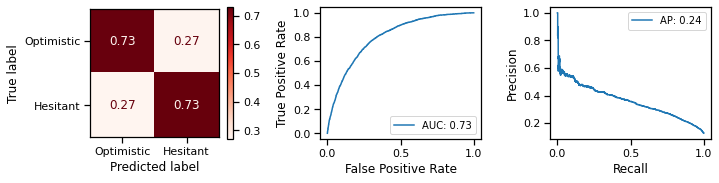

In [501]:
# Logistic Regression with reduced features, optimal params from grid search
lr = LogisticRegression(C=1, class_weight='balanced', max_iter=500, 
                        penalty='l1', solver='liblinear')

lr.fit(X_train_df[final_keep], y_train)

eval_clf_model(lr, X_test_df[final_keep], y_test, X_train_df[final_keep], 
               y_train, labels=labels)

**From optimal model on v1 cols**

****************************** Training Scores ******************************
- Training Macro F1 = 0.6074
- Training Macro Recall = 0.7327
- Training Balanced Accuracy = 0.7327

****************************** Test Scores ******************************
- Test Macro F1 = 0.6144
- Test Macro Recall = 0.733
- Test Balanced Accuracy = 0.733

****************************** Differences ******************************
- Train-Test Macro F1 Diff = 0.0070
- Train-Test Macro Recall Diff = 0.0003
- Train-Test Balanced Accuracy Diff = 0.0003

Not really any different from the original model on V1 features that didn't use regularization. So removing the features that the selection process voted were not important hasn't had much effect on Logistic Regression accuracy or F1.

This is OK; it just means I have simplified my model somewhat and honed in on the features that actually do help predictions. I don't think I can go any further with Logistic Regression; let's see how a Random Forest does on the adjusted feature space.

### Random Forest


In [502]:
# How about trying another grid search with just max_depth and criterion?
rf = RandomForestClassifier(class_weight='balanced')

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [5, 10, 30]
}

gs_rf = GridSearchCV(rf, param_grid, scoring='f1_macro', n_jobs=-1,  
                     verbose=True)

if rerun_gridsearch:
    gs_rf.fit(X_train_df[final_keep], y_train)

    print(gs_rf.best_estimator_)
    print(gs_rf.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.0min finished


RandomForestClassifier(class_weight='balanced', max_depth=10)
0.6236553503755118


Best params for RF on reduced features is the same as it was for v1 features; max_depth = 10.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.96      0.78      0.86     51283
         1.0       0.34      0.79      0.47      7085

    accuracy                           0.78     58368
   macro avg       0.65      0.79      0.67     58368
weighted avg       0.89      0.78      0.82     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.77      0.85     17037
         1.0       0.29      0.66      0.41      2420

    accuracy                           0.76     19457
   macro avg       0.62      0.72      0.63     19457
weighted avg       0.86      0.76      0.79     19457


****************************** Training Scores ******************************
            Training Macro F1 = 0.668
        Training Macro Recall = 0.7881
   Training Balanced Accuracy = 0.7881

*

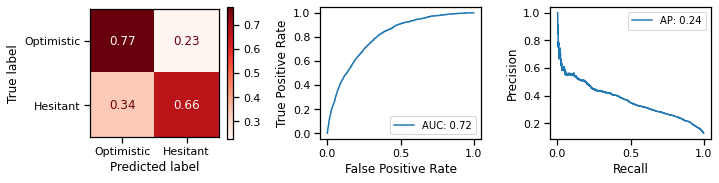

In [503]:
# Random Forest with reduced features, optimal params from grid search
rf = RandomForestClassifier(class_weight='balanced', max_depth=10)

rf.fit(X_train_df[final_keep], y_train)

eval_clf_model(rf, X_test_df[final_keep], y_test, X_train_df[final_keep], 
               y_train, labels=labels)

In [505]:
# Saving final models out
joblib.dump(lr, 'final_lr_model.joblib') 
joblib.dump(rf, 'final_rf_model.joblib') 

['final_rf_model.joblib']

# iNTERPRET

Evaluate how well your work solves the stated business problem.

***
Questions to consider:
* How do you interpret the results?
* How well does your model fit your data? How much better is this than your baseline model?
* How confident are you that your results would generalize beyond the data you have?
* How confident are you that this model would benefit the business if put into use?
***

# CONCLUSIONS & RECOMMENDATIONS

Provide your conclusions about the work you've done, including any limitations or next steps.

***
Questions to consider:
* What would you recommend the business do as a result of this work?
* What are some reasons why your analysis might not fully solve the business problem?
* What else could you do in the future to improve this project?
***

# Extra

### K-Nearest-Neighbors
I fitted a KNN model with `weights='distance'` to my un-balanced data, and it took a very long time to make predictions so I could get my report. 

It way overfit on training data (all scores of 1.0) and had an F1 score of 0.147 on Test data, with recall only 0.09.

I may try it again with a different weight parameter and the filtered v1 columns only, but due to the number of features and observations. I don't think KNN is a feasible model given how long it takes to make predictions.

In [122]:
# First I'll try the un-balanced data, using the weights=distance param
#knn = KNeighborsClassifier(weights='distance')

#knn.fit(X_train_df, y_train)x

#eval_clf_model(knn, X_test_df, y_test, X_train_df, y_train, labels=labels)

KNeighborsClassifier(weights='distance')

## Decision Trees - SMOTEd

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     51283
         1.0       1.00      0.99      0.99     51283

    accuracy                           0.99    102566
   macro avg       0.99      0.99      0.99    102566
weighted avg       0.99      0.99      0.99    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.96      0.93     17037
         1.0       0.38      0.16      0.22      2420

    accuracy                           0.86     19457
   macro avg       0.64      0.56      0.57     19457
weighted avg       0.83      0.86      0.84     19457


****************************** Score Comparison ******************************
Training F1 = 0.9936
Training Accuracy = 0.9936
Test F1 = 0.222
Test Accuracy = 0.8638

*****************************

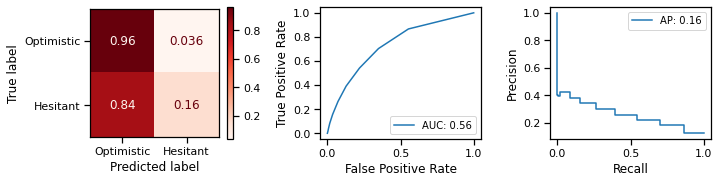

In [187]:
# Try a Bagging Classifier
dt = DecisionTreeClassifier()

bag = BaggingClassifier(dt, random_state=42)
bag.fit(X_train_sm[v1_cols], y_train_sm)

eval_clf_model(bag, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)


****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51283
         1.0       1.00      1.00      1.00     51283

    accuracy                           1.00    102566
   macro avg       1.00      1.00      1.00    102566
weighted avg       1.00      1.00      1.00    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.98      0.93     17037
         1.0       0.46      0.10      0.17      2420

    accuracy                           0.87     19457
   macro avg       0.67      0.54      0.55     19457
weighted avg       0.83      0.87      0.84     19457


****************************** Score Comparison ******************************
Training F1 = 1.0
Training Accuracy = 1.0
Test F1 = 0.1694
Test Accuracy = 0.8735

****************************** Gra

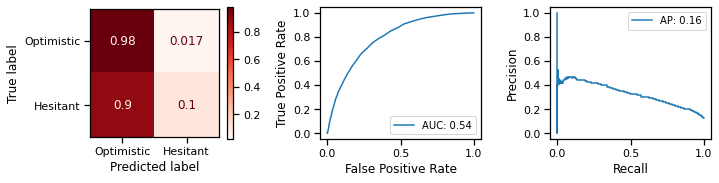

In [180]:
# Random Forest using default settings and v1 columns
rf = RandomForestClassifier()

rf.fit(X_train_sm[v1_cols], y_train_sm)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)

This is very overfit, and performed quite poorly on test data, especially F1.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.91     51283
         1.0       0.94      0.88      0.91     51283

    accuracy                           0.91    102566
   macro avg       0.91      0.91      0.91    102566
weighted avg       0.91      0.91      0.91    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     17037
         1.0       0.40      0.28      0.33      2420

    accuracy                           0.86     19457
   macro avg       0.65      0.61      0.62     19457
weighted avg       0.84      0.86      0.85     19457


****************************** Score Comparison ******************************
Training F1 = 0.9093
Training Accuracy = 0.9121
Test F1 = 0.3282
Test Accuracy = 0.8592

****************************

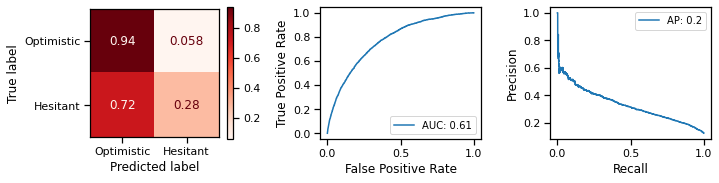

In [188]:
# Trying a gradient boost
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
            max_depth=1, random_state=42)

gbc.fit(X_train_sm[v1_cols], y_train_sm)

eval_clf_model(gbc, X_test_df[v1_cols], y_test, X_train_sm[v1_cols], 
               y_train_sm, labels=labels)

OK so all of these with default estimator settings are performing quite poorly. Better than the dummy model, but not by much. I think I need to do some feature selection to see if reducing the feature space helps.

## Decision Trees - Unbalanced

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51283
         1.0       1.00      1.00      1.00      7085

    accuracy                           1.00     58368
   macro avg       1.00      1.00      1.00     58368
weighted avg       1.00      1.00      1.00     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.89      0.89     17037
         1.0       0.25      0.25      0.25      2420

    accuracy                           0.81     19457
   macro avg       0.57      0.57      0.57     19457
weighted avg       0.81      0.81      0.81     19457


****************************** Score Comparison ******************************
Training F1 = 1.0
Training Accuracy = 1.0
Test F1 = 0.2477
Test Accuracy = 0.813

****************************** Grap

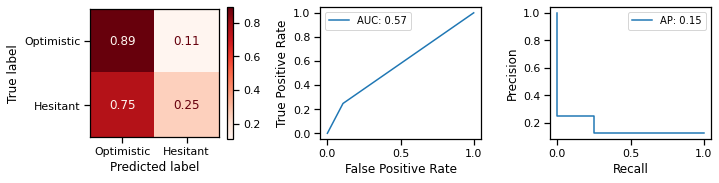

In [374]:
# Try a Vanilla decision tree
dt = DecisionTreeClassifier(class_weight='balanced')

dt.fit(X_train_df[v1_cols], y_train)

eval_clf_model(dt, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)


Pretty overfit. Does not perform well on target class in test data.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51283
         1.0       1.00      1.00      1.00      7085

    accuracy                           1.00     58368
   macro avg       1.00      1.00      1.00     58368
weighted avg       1.00      1.00      1.00     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.88      1.00      0.93     17037
         1.0       0.57      0.04      0.07      2420

    accuracy                           0.88     19457
   macro avg       0.73      0.52      0.50     19457
weighted avg       0.84      0.88      0.83     19457


****************************** Score Comparison ******************************
Training F1 = 0.9998
Training Accuracy = 0.9999
Test F1 = 0.0742
Test Accuracy = 0.8769

****************************

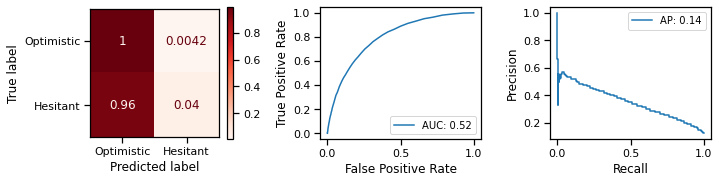

In [375]:
# Vanilla random forest using v1 features
rf = RandomForestClassifier(class_weight='balanced')

rf.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

In [376]:
# how deep and leafy was my original vanilla decision tree?
print(dt.get_depth())
print(dt.get_n_leaves())

65
8193


****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.67      0.78     51283
         1.0       0.21      0.62      0.31      7085

    accuracy                           0.67     58368
   macro avg       0.57      0.65      0.55     58368
weighted avg       0.84      0.67      0.72     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.68      0.79     17037
         1.0       0.22      0.65      0.33      2420

    accuracy                           0.67     19457
   macro avg       0.58      0.66      0.56     19457
weighted avg       0.84      0.67      0.73     19457


****************************** Score Comparison ******************************
Training F1 = 0.3101
Training Accuracy = 0.6663
Test F1 = 0.3309
Test Accuracy = 0.6747

****************************

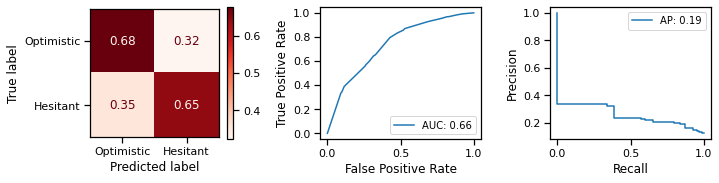

In [377]:
# Random Forest with a few settings tweaked to try to prevent overfitting
rf = RandomForestClassifier(class_weight='balanced', min_impurity_decrease=0.02,
                           max_features=10, max_depth=20, max_leaf_nodes=1000)

rf.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

Not too bad. Test is a bit better than train, so it may be slightly underfit. Let's relax the parameters a bit.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.52      0.67     51283
         1.0       0.19      0.81      0.31      7085

    accuracy                           0.55     58368
   macro avg       0.57      0.66      0.49     58368
weighted avg       0.86      0.55      0.63     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.53      0.68     17037
         1.0       0.20      0.82      0.32      2420

    accuracy                           0.57     19457
   macro avg       0.58      0.68      0.50     19457
weighted avg       0.86      0.57      0.64     19457


****************************** Score Comparison ******************************
Training F1 = 0.3058
Training Accuracy = 0.5548
Test F1 = 0.3205
Test Accuracy = 0.5659

****************************

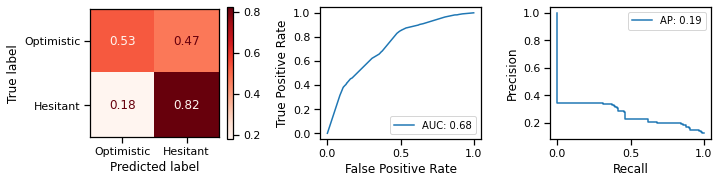

In [378]:
# Upped max_features to 20, upped max_depth to 40, upped max_leaf_nodes to 2000
rf = RandomForestClassifier(class_weight='balanced', min_impurity_decrease=0.02,
                           max_features=20, max_depth=40, max_leaf_nodes=2000)

rf.fit(X_train_df[v1_cols], y_train)

eval_clf_model(rf, X_test_df[v1_cols], y_test, X_train_df[v1_cols], 
               y_train, labels=labels)

I'm concerned about the variability in these Random Forest models with just a few settings tweaked. This model had higher recall on the Hesitant class in test than the previous one, but lower recall on the Optimistic class. I'm concerned if I keep tweaking this, I will be overfitting to the peculiarities of the test data.

Maybe reducing the feature space will help.

## Feature Selection: SMOTEd

### Variance Threshold


In [197]:
# I'm pretty sure from my EDA that I don't have any features with 0 variance
# so I'm going to start with a threshold of .95

# since most of my variables are OHE, I'll use the formula p(1-p) to generate
# the appropriate variace threshold 
# More here: (https://scikit-learn.org/stable/modules/feature_selection.html)
threshold = 0.99*(1-0.99)

sel = VarianceThreshold(threshold)
sel.fit(X_train_sm)

# Review columns to be removed
list(X_train_sm.loc[:, sel.get_support()==False].head().columns)

VarianceThreshold(threshold=0.00990000000000001)

Almost all of these are skipped indicator columns for specific questions, which makes sense because those are sparsely populated.

That said, my v2_cols I've been testing don't include most of those, just the 'skipped' column that has the number of skipped questions. I haven't seen much difference in performance on v2 cols as opposed to v1. 

### Univariate Feature Selection

In [202]:
# using mutual info
selk = SelectKBest(mutual_info_classif, k=50)
selk.fit(X_train_sm, y_train_sm)

SelectKBest(k=50, score_func=<function mutual_info_classif at 0x7fe3b3a78160>)

In [205]:
# Review features that it would keep
keep50_mutual = list(X_train_sm.loc[:, selk.get_support()].head().columns)
keep50_mutual

['CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'EIP_3.0',
 'EIP_4.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'PLNDTRIPS_0.0',
 'PLNDTRIPS_1.0',
 'SPNDSRC1_1.0',
 'SPNDSRC2_0.0',
 'SPNDSRC2_1.0',
 'SPNDSRC3_0.0',
 'SSA_RECV_0.0',
 'SSA_RECV_1.0',
 'TENURE_1.0',
 'TENURE_2.0',
 'UI_APPLY_0.0',
 'ANXIOUS_2.0',
 'INTEREST_2.0',
 'TNUM_PS_2_0.0',
 'ANYWORK_0.0',
 'ANYWORK_1.0',
 'EGENDER_0.0',
 'EGENDER_1.0',
 'EXPCTLOSS_0.0',
 'HADCOVID_0.0',
 'RRACE_1.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_0.0',
 'WRKLOSS_1.0',
 'THHLD_NUMADLT_1.0',
 'THHLD_NUMADLT_2.0',
 'THHLD_NUMADLT_3.0',
 'polit_0',
 'polit_1',
 'EST_MSA_0.0',
 'IN_METRO_AREA_0.0',
 'IN_METRO_AREA_1.0']

In [206]:
# Using chi2
selk2 = SelectKBest(chi2, k=50)
selk2.fit(X_train_sm, y_train_sm)

# Review features that it would keep
keep50_chi2 = list(X_train_sm.loc[:, selk2.get_support()].head().columns)
keep50_chi2

['AGE',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW10_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_1.0',
 'DELAY_1.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'PLNDTRIPS_0.0',
 'SNAP_YN_1.0',
 'SPNDSRC4_1.0',
 'SSA_RECV_0.0',
 'SSA_RECV_1.0',
 'TENURE_1.0',
 'UI_APPLY_1.0',
 'ANXIOUS_2.0',
 'DOWN_2.0',
 'WORRY_2.0',
 'HLTHINS2_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_1.0',
 'HLTHINS6_-1.0',
 'HLTHINS7_-1.0',
 'HLTHINS8_-1.0',
 'ENROLL1_1.0',
 'ENROLL2_-1.0',
 'ENROLL3_-1.0',
 'HLTHINS_0.0',
 'RRACE_3.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_1.0',
 'polit_0',
 'polit_1',
 'EST_MSA_0.0',
 'EST_MSA_41860.0',
 'EST_MSA_47900.0',
 'IN_METRO_AREA_0.0',
 'IN_METRO_AREA_1.0',
 'SCHOOL_KIDS_1.0']

In [207]:
# Using f
selk3 = SelectKBest(f_classif, k=50)
selk3.fit(X_train_sm, y_train_sm)

# Review features that it would keep
keep50_f = list(X_train_sm.loc[:, selk3.get_support()].head().columns)
keep50_f

['INCOME',
 'skipped',
 'AGE',
 'EEDUC',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'PLNDTRIPS_1.0',
 'SNAP_YN_0.0',
 'SNAP_YN_1.0',
 'SSA_RECV_0.0',
 'SSA_RECV_1.0',
 'TENURE_1.0',
 'UI_APPLY_0.0',
 'UI_APPLY_1.0',
 'ANXIOUS_2.0',
 'HLTHINS2_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_1.0',
 'ENROLL1_1.0',
 'ENROLL3_-1.0',
 'HLTHINS_0.0',
 'HLTHINS_1.0',
 'RRACE_3.0',
 'TW_START_0.0',
 'TW_START_1.0',
 'WRKLOSS_0.0',
 'WRKLOSS_1.0',
 'polit_0',
 'polit_1',
 'EST_MSA_0.0',
 'IN_METRO_AREA_0.0',
 'IN_METRO_AREA_1.0',
 'SCHOOL_KIDS_0.0',
 'SCHOOL_KIDS_1.0']

### Select From Model - Logit
When I ran logistic regression, it found that L2 was the best performing regularization technique with `saga` solver, but now I'll use L1 Lasso with a  to see how well it can reduce features for me.

I also tried this with a LinearSVC model, but even at 4000 max iterations, it failed to converge.

I used a CV Logistic Regression model here since it will try different values of C for the penalty and choose the best one. I want my feature selection to be based on the model with the best f1 score.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.77      0.75      0.76     51283
         1.0       0.75      0.78      0.77     51283

    accuracy                           0.76    102566
   macro avg       0.76      0.76      0.76    102566
weighted avg       0.76      0.76      0.76    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.75      0.83     17037
         1.0       0.27      0.65      0.38      2420

    accuracy                           0.74     19457
   macro avg       0.60      0.70      0.61     19457
weighted avg       0.85      0.74      0.78     19457


****************************** Score Comparison ******************************
Training F1 = 0.7651
Training Accuracy = 0.7614
Test F1 = 0.3815
Test Accuracy = 0.7395

****************************

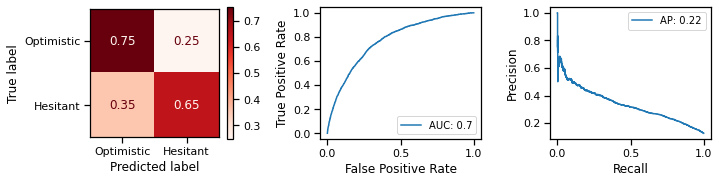

In [219]:
# fitting on all columns, since will be using for feature selection
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=300)
lr.fit(X_train_sm, y_train_sm)

eval_clf_model(lr, X_test_df, y_test, X_train_sm, y_train_sm, labels=labels)

In [223]:
model_sel = SelectFromModel(lr, prefit=True)
model_sel.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True, False,  True,  True,  True,  True,  True, False,
        True,  True, False,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,

In [224]:
# what would it get rid of?
keep_lr = list(X_train_sm.loc[:, model_sel.get_support()==False].head().columns)
keep_lr

['FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'MH_NOTGET_0.0',
 'MH_SVCS_0.0',
 'PLNDTRIPS_0.0',
 'SPNDSRC6_1.0',
 'DOWN_4.0',
 'HLTHINS1_0.0',
 'HLTHINS6_1.0',
 'ENROLL1_-1.0',
 'ENROLL2_-1.0',
 'LIVQTR_2.0',
 'LIVQTR_6.0',
 'ANYWORK_1.0',
 'EGENDER_1.0',
 'EXPCTLOSS_1.0',
 'HADCOVID_1.0',
 'RHISPANIC_1.0',
 'RRACE_1.0',
 'TW_START_0.0',
 'WRKLOSS_1.0',
 'THHLD_NUMADLT_2.0',
 'polit_0',
 'EST_MSA_19100.0',
 'EST_MSA_31080.0',
 'MS_2.0',
 'inc_binary_1.0',
 'IN_METRO_AREA_1.0',
 'SCHOOL_KIDS_0.0',
 'MS_2_2.0',
 'PROP_FOODSPEND_HOME_skipped_0.0',
 'TNUM_PS_skipped_0.0',
 'CURFOODSUF_skipped_0.0',
 'EXPNS_DIF_skipped_0.0',
 'INCOME_skipped_0.0']

My logistic regression model using Lasso L1 regularization wants to keep most of my features. It's possible that a different value of C would help, but also with this many features, a grid search to find the best value would be time prohibitive.

### Select from Model - Forest


****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     51283
         1.0       0.94      0.88      0.91     51283

    accuracy                           0.91    102566
   macro avg       0.91      0.91      0.91    102566
weighted avg       0.91      0.91      0.91    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     17037
         1.0       0.39      0.26      0.31      2420

    accuracy                           0.86     19457
   macro avg       0.64      0.60      0.61     19457
weighted avg       0.84      0.86      0.84     19457


****************************** Score Comparison ******************************
Training F1 = 0.91
Training Accuracy = 0.9128
Test F1 = 0.3086
Test Accuracy = 0.8577

******************************

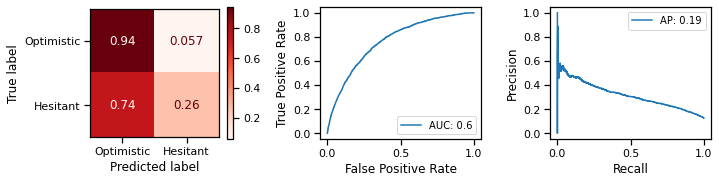

In [226]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
            max_depth=1)

gbc.fit(X_train_sm, y_train_sm)

eval_clf_model(gbc, X_test_df, y_test, X_train_sm, y_train_sm, labels=labels)

In [227]:
model_sel_f = SelectFromModel(gbc, prefit=True)
model_sel_f.get_support()

array([False, False,  True, False,  True, False,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
        True, False, False, False, False, False, False, False, False,
       False, False,  True,  True,  True,  True, False,  True, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
        True, False, False,  True, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,

In [228]:
# what would it keep?
keep_tree = list(X_train_sm.loc[:, model_sel_f.get_support()].head().columns)
keep_tree

['skipped',
 'AGE',
 'EEDUC',
 'CHNGHOW2_1.0',
 'CHNGHOW6_1.0',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'FEWRTRANS_1.0',
 'FEWRTRIPS_0.0',
 'PLNDTRIPS_0.0',
 'PLNDTRIPS_1.0',
 'PRESCRIPT_1.0',
 'SPNDSRC1_0.0',
 'SPNDSRC1_1.0',
 'TENURE_2.0',
 'ANXIOUS_2.0',
 'HLTHINS2_1.0',
 'ENROLL3_-1.0',
 'EGENDER_0.0',
 'EGENDER_1.0',
 'EXPCTLOSS_0.0',
 'HADCOVID_0.0',
 'HADCOVID_1.0',
 'RHISPANIC_0.0',
 'RRACE_1.0',
 'RRACE_3.0',
 'TW_START_0.0',
 'WRKLOSS_0.0',
 'WRKLOSS_1.0',
 'THHLD_NUMADLT_2.0',
 'polit_0',
 'IN_METRO_AREA_1.0']

This looks pretty reasonable.

Let's compare features across the different feature selection methods and see which are most commonly kept.

### Combine Votes for Features

In [229]:
feat_dict = {
    'univ_mutual' : list(selk.get_support()),
    'univ_chi2' : list(selk2.get_support()),
    'univ_f' : list(selk3.get_support()),
    'model_lr' : list(model_sel.get_support()),
    'model_gbt' : list(model_sel_f.get_support())
    }

feat_votes = pd.DataFrame.from_dict(feat_dict, orient='index', 
                                    columns=X_train_sm.columns)

feat_votes

,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,...,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
univ_mutual,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
univ_chi2,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
univ_f,False,True,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
model_lr,True,True,True,True,True,True,True,True,True,True,...,False,True,False,True,False,True,False,True,False,True
model_gbt,False,False,True,False,True,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [230]:
# really useful: https://stackoverflow.com/questions/17383094/how-can-i-map-true-false-to-1-0-in-a-pandas-dataframe
feat_votes = feat_votes*1
feat_votes

,EXPNS_DIF,INCOME,skipped,THHLD_NUMKID,AGE,incomplete,EEDUC,PROP_FOODSPEND_HOME,TNUM_PS,CURFOODSUF,...,PROP_FOODSPEND_HOME_skipped_0.0,PROP_FOODSPEND_HOME_skipped_1.0,TNUM_PS_skipped_0.0,TNUM_PS_skipped_1.0,CURFOODSUF_skipped_0.0,CURFOODSUF_skipped_1.0,EXPNS_DIF_skipped_0.0,EXPNS_DIF_skipped_1.0,INCOME_skipped_0.0,INCOME_skipped_1.0
univ_mutual,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
univ_chi2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
univ_f,0,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
model_lr,1,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,1,0,1,0,1
model_gbt,0,0,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [236]:
votes = feat_votes.sum(axis=0)
sorted_votes = votes.sort_values(ascending=False)
print(list(sorted_votes))

[5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


It looks like there are a decent number of features that at least 2 of these feature selection methods voted for. I'm inclined to go with those, but let's take a look at what will be dropped. if we exclude features that only 1 or no methods voted for.

In [244]:
#These columns would be dropped
to_drop = list(sorted_votes.loc[sorted_votes < 2].index)
to_drop.sort()

display(to_drop)

['ANXIOUS_-1.0',
 'ANXIOUS_1.0',
 'ANXIOUS_3.0',
 'ANXIOUS_4.0',
 'ANYWORK_-1.0',
 'ANYWORK_1.0',
 'CHNGHOW10_0.0',
 'CHNGHOW11_0.0',
 'CHNGHOW11_1.0',
 'CHNGHOW3_0.0',
 'CHNGHOW3_1.0',
 'CHNGHOW5_0.0',
 'CHNGHOW5_1.0',
 'CHNGHOW7_0.0',
 'CHNGHOW7_1.0',
 'CHNGHOW8_0.0',
 'CURFOODSUF',
 'CURFOODSUF_skipped_0.0',
 'CURFOODSUF_skipped_1.0',
 'DELAY_-1.0',
 'DELAY_0.0',
 'DOWN_-1.0',
 'DOWN_1.0',
 'DOWN_3.0',
 'DOWN_4.0',
 'EIP_-1.0',
 'ENROLL1_-1.0',
 'ENROLL2_-1.0',
 'ENROLL2_1.0',
 'ENROLL3_1.0',
 'EST_MSA_12060.0',
 'EST_MSA_14460.0',
 'EST_MSA_16980.0',
 'EST_MSA_19100.0',
 'EST_MSA_19820.0',
 'EST_MSA_26420.0',
 'EST_MSA_31080.0',
 'EST_MSA_33100.0',
 'EST_MSA_35620.0',
 'EST_MSA_37980.0',
 'EST_MSA_38060.0',
 'EST_MSA_40140.0',
 'EST_MSA_42660.0',
 'EXPCTLOSS_-1.0',
 'EXPCTLOSS_1.0',
 'EXPNS_DIF',
 'EXPNS_DIF_skipped_0.0',
 'EXPNS_DIF_skipped_1.0',
 'FEWRTRANS_-1.0',
 'FEWRTRANS_2.0',
 'FEWRTRIPS_-1.0',
 'FREEFOOD_-1.0',
 'FREEFOOD_0.0',
 'FREEFOOD_1.0',
 'HADCOVID_-1.0',
 'HADCOVID

In [245]:
#These columns would be kept
to_keep = list(sorted_votes.loc[sorted_votes >= 2].index)
to_keep.sort()

display(to_keep)

['AGE',
 'ANXIOUS_2.0',
 'ANYWORK_0.0',
 'CHNGHOW10_1.0',
 'CHNGHOW12_0.0',
 'CHNGHOW12_1.0',
 'CHNGHOW1_0.0',
 'CHNGHOW1_1.0',
 'CHNGHOW2_0.0',
 'CHNGHOW2_1.0',
 'CHNGHOW4_0.0',
 'CHNGHOW4_1.0',
 'CHNGHOW6_0.0',
 'CHNGHOW6_1.0',
 'CHNGHOW8_1.0',
 'CHNGHOW9_0.0',
 'CHNGHOW9_1.0',
 'DELAY_1.0',
 'DOWN_2.0',
 'EEDUC',
 'EGENDER_0.0',
 'EGENDER_1.0',
 'EIP_1.0',
 'EIP_2.0',
 'EIP_3.0',
 'EIP_4.0',
 'ENROLL1_1.0',
 'ENROLL3_-1.0',
 'EST_MSA_0.0',
 'EST_MSA_41860.0',
 'EST_MSA_47900.0',
 'EXPCTLOSS_0.0',
 'FEWRTRANS_1.0',
 'FEWRTRANS_3.0',
 'FEWRTRIPS_0.0',
 'FEWRTRIPS_1.0',
 'HADCOVID_0.0',
 'HLTHINS2_1.0',
 'HLTHINS3_0.0',
 'HLTHINS3_1.0',
 'HLTHINS4_1.0',
 'HLTHINS6_-1.0',
 'HLTHINS7_-1.0',
 'HLTHINS8_-1.0',
 'HLTHINS_0.0',
 'HLTHINS_1.0',
 'INCOME',
 'INTEREST_2.0',
 'IN_METRO_AREA_0.0',
 'IN_METRO_AREA_1.0',
 'PLNDTRIPS_0.0',
 'PLNDTRIPS_1.0',
 'PRESCRIPT_1.0',
 'RHISPANIC_0.0',
 'RRACE_1.0',
 'RRACE_3.0',
 'SCHOOL_KIDS_1.0',
 'SNAP_YN_0.0',
 'SNAP_YN_1.0',
 'SPNDSRC1_0.0',
 'SPNDSRC1_

OK, let's try these features on the models I tried before, and see if they perform better in terms of f1 score.

I originally used the SMOTEd data for my initial models and in using these features selection methods. It allowed me to use models such a gradient boosting, which doesn't have a class_weight parameter.

However, the models I created on the SMOTEd data, using the features selected from the SMOTEd data, were pretty sensitive to hyperparameter adjustment, especially the random forests. I became concerned that the SMOTEd data was not as representative of the original data as it should be, and that small adjustments in hyperparameters were causing large changes in performance that shouldn't be happening if the models are really picking up on the signal and not noise.

So, I went back and re-ran feature selection process on the original, imbalanced dataset and had processes vote to select features in the same way. The only difference was that I used a Random Forest instead of Gradient Boosting, to be able to use the class_weight parameter. The features selected by the models built on imbalanced data were quite different; some were added, some were removed. Since the linear regression and random forest models that generated these selected features performed more consistently on training and test, I'm more confident that the features they selected are based on their picking up on signal instead of noise, and that the features are more appropriate.

Let's compare the results of feature selection using the imbalanced, original data versus the SMOTEd data. Note that I had to use a RandomForest instead of Gradient Boosted Trees in the imbalanced selection process because Gradient Boosted Trees doesn't have a class_weight parameter.

In [368]:
in_ib_only = list(set(to_keep_ib) - set(to_keep))
in_sm_only = list(set(to_keep) - set(to_keep_ib))

display(in_ib_only)
display(in_sm_only)

['LIVQTR_1.0',
 'CHNGHOW10_0.0',
 'INCOME_skipped_0.0',
 'FREEFOOD_0.0',
 'ENROLL2_-1.0',
 'TNUM_PS_skipped_0.0',
 'THHLD_NUMKID',
 'SSA_APPLY_0.0',
 'CHNGHOW5_0.0',
 'CHNGHOW11_0.0',
 'EXPNS_DIF',
 'ENROLL2_1.0',
 'LIVQTR_2_1.0',
 'SPNDSRC6_0.0',
 'CURFOODSUF',
 'TENURE_3.0',
 'PROP_FOODSPEND_HOME_skipped_0.0',
 'SPNDSRC7_0.0',
 'LIVQTR_2_2.0',
 'SCHOOL_KIDS_0.0',
 'RRACE_4.0',
 'EXPNS_DIF_skipped_0.0',
 'CHNGHOW3_0.0',
 'CHNGHOW7_0.0',
 'SPNDSRC4_0.0',
 'EXPCTLOSS_1.0',
 'HLTHINS4_0.0',
 'SPNDSRC5_0.0',
 'MH_NOTGET_0.0']

['ANYWORK_0.0',
 'SPNDSRC2_1.0',
 'THHLD_NUMADLT_1.0',
 'CHNGHOW10_1.0',
 'PRESCRIPT_1.0',
 'HLTHINS2_1.0',
 'TENURE_2.0',
 'skipped',
 'THHLD_NUMADLT_2.0',
 'EGENDER_0.0',
 'HLTHINS7_-1.0',
 'CHNGHOW9_0.0',
 'RRACE_1.0',
 'HLTHINS6_-1.0',
 'CHNGHOW8_1.0',
 'EIP_2.0',
 'WORRY_2.0',
 'FEWRTRANS_3.0',
 'EST_MSA_47900.0',
 'DOWN_2.0',
 'DELAY_1.0',
 'THHLD_NUMADLT_3.0',
 'EIP_4.0',
 'INTEREST_2.0',
 'EST_MSA_41860.0',
 'EGENDER_1.0',
 'EIP_1.0',
 'HLTHINS8_-1.0',
 'TNUM_PS_2_0.0']

## Modeling in Reduced Feature Space - SMOTEd

### Logistic Regression

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.73     51283
         1.0       0.72      0.75      0.74     51283

    accuracy                           0.73    102566
   macro avg       0.73      0.73      0.73    102566
weighted avg       0.73      0.73      0.73    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     17037
         1.0       0.27      0.73      0.39      2420

    accuracy                           0.72     19457
   macro avg       0.61      0.72      0.60     19457
weighted avg       0.86      0.72      0.76     19457


****************************** Score Comparison ******************************
Training F1 = 0.7371
Training Accuracy = 0.7314
Test F1 = 0.3922
Test Accuracy = 0.7187

****************************

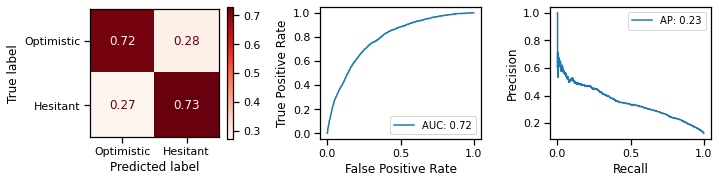

In [246]:
lr2 = LogisticRegression(C=0.01, penalty='l2', max_iter=300, solver='saga')

lr2.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(lr2, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

In [ ]:
param_grid = {
    'C':[0.01, 0.1, 1, 100],
    'penalty': ['l1', 'l2', 'elasticnet']
}

gs_lr = GridSearchCV(lr_sm, param_grid, scoring=['f1', 'recall'], n_jobs=-1, 
                     verbose=True, refit=False)

gs_lr.fit(X_train_sm[to_keep], y_train_sm)

In [340]:
gs_lr.cv_results_

{'mean_fit_time': array([ 5.45609245,  3.66125121,  0.11797318,  4.09468966, 11.23407574,
         0.11075892, 10.82168217, 39.51797571,  0.10588851,  5.52082787,
         4.48583264,  0.11115003]),
 'std_fit_time': array([5.04406417e-01, 2.72913332e-01, 1.34945344e-02, 1.62682117e-01,
        2.07490251e-01, 3.69635975e-03, 2.80961356e-01, 2.51528633e+00,
        4.68918809e-03, 2.79211075e-01, 2.54324051e-01, 2.51462478e-03]),
 'mean_score_time': array([0.03936167, 0.0343008 , 0.        , 0.03567877, 0.03468308,
        0.        , 0.03381019, 0.03144455, 0.        , 0.03364434,
        0.03415837, 0.        ]),
 'std_score_time': array([0.00436364, 0.00050136, 0.        , 0.00345791, 0.00217362,
        0.        , 0.00191308, 0.00395109, 0.        , 0.00253909,
        0.00636901, 0.        ]),
 'param_C': masked_array(data=[0.01, 0.01, 0.01, 0.1, 0.1, 0.1, 1, 1, 1, 100, 100,
                    100],
              mask=[False, False, False, False, False, False, False, False,
     

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.73     51283
         1.0       0.72      0.75      0.74     51283

    accuracy                           0.73    102566
   macro avg       0.73      0.73      0.73    102566
weighted avg       0.73      0.73      0.73    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.95      0.72      0.82     17037
         1.0       0.27      0.72      0.39      2420

    accuracy                           0.72     19457
   macro avg       0.61      0.72      0.61     19457
weighted avg       0.86      0.72      0.77     19457


****************************** Score Comparison ******************************
Training F1 = 0.7385
Training Accuracy = 0.7331
Test F1 = 0.3917
Test Accuracy = 0.7205

****************************

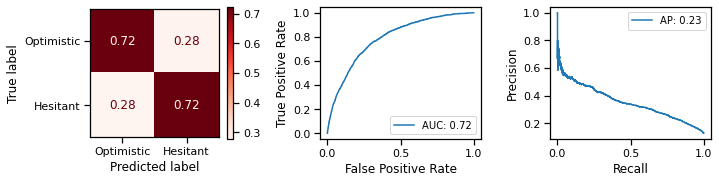

In [330]:
lr2 = LogisticRegression(C=100, penalty='l1', max_iter=300, solver='saga')

lr2.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(lr2, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

Performs a bit better than its predecessor with v1 features.

Let's try some more models with this feature space and see.

### Decision Trees

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     51283
         1.0       1.00      1.00      1.00     51283

    accuracy                           1.00    102566
   macro avg       1.00      1.00      1.00    102566
weighted avg       1.00      1.00      1.00    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88     17037
         1.0       0.24      0.29      0.26      2420

    accuracy                           0.79     19457
   macro avg       0.57      0.58      0.57     19457
weighted avg       0.81      0.79      0.80     19457


****************************** Score Comparison ******************************
Training F1 = 1.0
Training Accuracy = 1.0
Test F1 = 0.2615
Test Accuracy = 0.7948

****************************** Gra

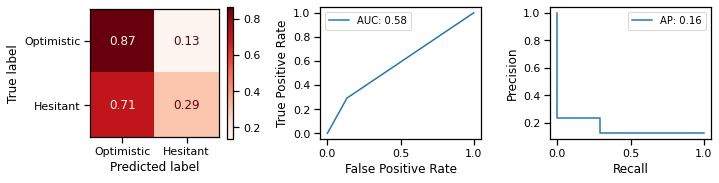

In [253]:
# Vanilla Decision Tree
dt = DecisionTreeClassifier()

dt.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

Way over fit. What are its charateristics?

In [256]:
print(f"depth: {dt.get_depth()}")
print(f"N leaves: {dt.get_n_leaves()}")

depth: 51
N leaves: 9818


****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     51283
         1.0       0.83      0.85      0.84     51283

    accuracy                           0.83    102566
   macro avg       0.83      0.83      0.83    102566
weighted avg       0.83      0.83      0.83    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     17037
         1.0       0.27      0.47      0.34      2420

    accuracy                           0.78     19457
   macro avg       0.59      0.65      0.60     19457
weighted avg       0.84      0.78      0.80     19457


****************************** Score Comparison ******************************
Training F1 = 0.8358
Training Accuracy = 0.8339
Test F1 = 0.3443
Test Accuracy = 0.7767

****************************

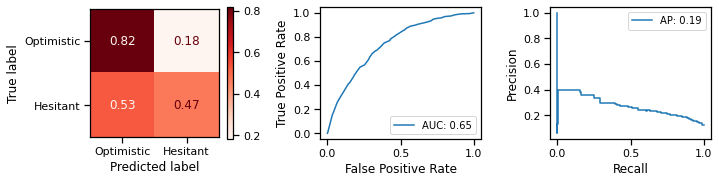

In [257]:
# Just guess at some different params for dt
dt = DecisionTreeClassifier(max_depth=10)

dt.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83     51283
         1.0       0.83      0.85      0.84     51283

    accuracy                           0.83    102566
   macro avg       0.83      0.83      0.83    102566
weighted avg       0.83      0.83      0.83    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.82      0.87     17037
         1.0       0.27      0.47      0.34      2420

    accuracy                           0.78     19457
   macro avg       0.59      0.65      0.61     19457
weighted avg       0.84      0.78      0.80     19457


****************************** Score Comparison ******************************
Training F1 = 0.8356
Training Accuracy = 0.8337
Test F1 = 0.3448
Test Accuracy = 0.7771

****************************

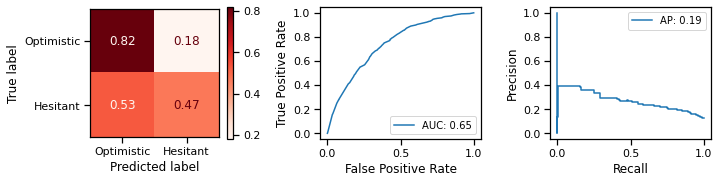

In [258]:
# What if I change min_samples_split too?
dt = DecisionTreeClassifier(max_depth=10, min_samples_split=10)

dt.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.71      0.68      0.69     51283
         1.0       0.69      0.72      0.70     51283

    accuracy                           0.70    102566
   macro avg       0.70      0.70      0.70    102566
weighted avg       0.70      0.70      0.70    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79     17037
         1.0       0.22      0.62      0.33      2420

    accuracy                           0.68     19457
   macro avg       0.57      0.65      0.56     19457
weighted avg       0.84      0.68      0.73     19457


****************************** Score Comparison ******************************
Training F1 = 0.7046
Training Accuracy = 0.6997
Test F1 = 0.326
Test Accuracy = 0.6812

*****************************

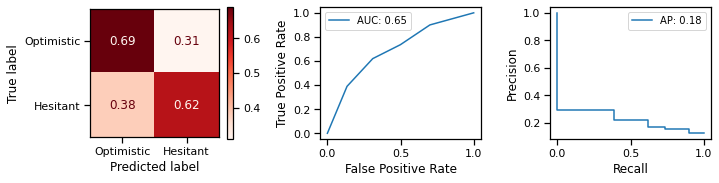

In [270]:
# min_samples_split didn't help much with max_depth, how about pairing it with 
# min_impurity_decrease and not specifying a max_depth?
dt = DecisionTreeClassifier(min_samples_split=10, min_impurity_decrease=0.01)

dt.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

This is one of the best models yet in terms of how it does on the test data.

In [266]:
# Time for a grid search to see if I can find the right mix of hyperparameters
dt = DecisionTreeClassifier()

param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [1, 5, 20],
    'min_impurity_decrease': [0, 0.01],
    'max_features': [None, 20],
    'max_leaf_nodes': [None, 4000, 500]
}

gs_dt = GridSearchCV(dt, param_grid, scoring='f1', n_jobs=-1, verbose=True)

gs_dt.fit(X_train_sm[to_keep], y_train_sm)

gs_dt.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.0min finished


{'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_split': 5}

OK, so my best parameters involved not specifying a max_depth or min_impurity decrease, but instead using a min_samples_split of 5 (my middle option), max_leaf_nodes of 4000 (also the middle option) and max_features 20 (the only option other than None).

How does this best model perform?

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.97      0.95     51283
         1.0       0.97      0.92      0.95     51283

    accuracy                           0.95    102566
   macro avg       0.95      0.95      0.95    102566
weighted avg       0.95      0.95      0.95    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.91      0.91     17037
         1.0       0.30      0.26      0.28      2420

    accuracy                           0.83     19457
   macro avg       0.60      0.59      0.59     19457
weighted avg       0.82      0.83      0.83     19457


****************************** Score Comparison ******************************
Training F1 = 0.9463
Training Accuracy = 0.9476
Test F1 = 0.2814
Test Accuracy = 0.8331

****************************

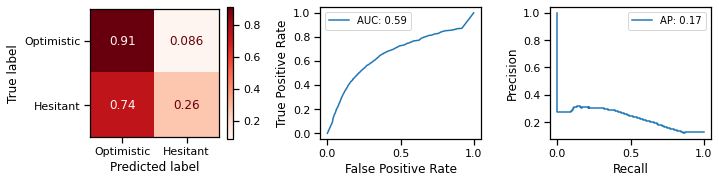

In [263]:
dt_best = gs_dt.best_estimator_
dt_best.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt_best, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

It doesn't perform very well on test data. It seems that optimizing for f1 of the training set isn't helping optimize f1 on test.

Maybe if I try optimizing for recall, since the training recall on my best DT model so far is the highest.

In [268]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_depth': [None, 10, 20],
    'min_samples_split': [1, 5, 20],
    'min_impurity_decrease': [0, 0.01],
    'max_features': [None, 20],
    'max_leaf_nodes': [None, 4000, 500]
}

gs_dt = GridSearchCV(dt, param_grid, scoring='recall', n_jobs=-1, verbose=True)

gs_dt.fit(X_train_sm[to_keep], y_train_sm)

gs_dt.best_params_

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  6.1min finished


{'criterion': 'gini',
 'max_depth': 20,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0,
 'min_samples_split': 5}

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.95      0.95     51283
         1.0       0.95      0.94      0.95     51283

    accuracy                           0.95    102566
   macro avg       0.95      0.95      0.95    102566
weighted avg       0.95      0.95      0.95    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.88      0.89     17037
         1.0       0.27      0.32      0.30      2420

    accuracy                           0.81     19457
   macro avg       0.59      0.60      0.59     19457
weighted avg       0.82      0.81      0.82     19457


****************************** Score Comparison ******************************
Training F1 = 0.9469
Training Accuracy = 0.9471
Test F1 = 0.2962
Test Accuracy = 0.8093

****************************

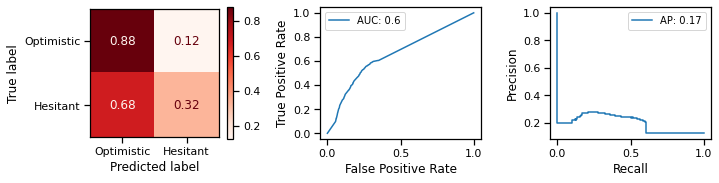

In [269]:
# Try out the best model from grid search optimized for recall
dt_best = gs_dt.best_estimator_
dt_best.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt_best, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

Well neither of those two 'best' models optimized for either f1 or recall appear to be performing better than this one I guessed at using `min_samples_split=10, min_impurity_decrease=0.01`. I'll iterate on that a bit more manually, since grid search isn't helping much.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68     51283
         1.0       0.68      0.68      0.68     51283

    accuracy                           0.68    102566
   macro avg       0.68      0.68      0.68    102566
weighted avg       0.68      0.68      0.68    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79     17037
         1.0       0.22      0.62      0.33      2420

    accuracy                           0.68     19457
   macro avg       0.57      0.65      0.56     19457
weighted avg       0.84      0.68      0.73     19457


****************************** Score Comparison ******************************
Training F1 = 0.6825
Training Accuracy = 0.6826
Test F1 = 0.326
Test Accuracy = 0.6812

*****************************

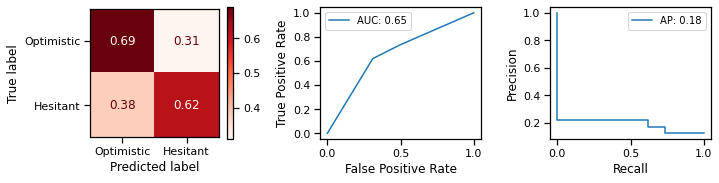

In [299]:
dt = DecisionTreeClassifier(min_impurity_decrease=0.02)

dt.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(dt, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

I iterated with a few different values of different hyperparameters and found that it's the `min_impurity_decrease` by itself that seems to account for the best model. Other parameters don't do much or make it worse on test.

If I try these parameters on the whole feature set, how does it do?

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68     51283
         1.0       0.68      0.68      0.68     51283

    accuracy                           0.68    102566
   macro avg       0.68      0.68      0.68    102566
weighted avg       0.68      0.68      0.68    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79     17037
         1.0       0.22      0.62      0.33      2420

    accuracy                           0.68     19457
   macro avg       0.57      0.65      0.56     19457
weighted avg       0.84      0.68      0.73     19457


****************************** Score Comparison ******************************
Training F1 = 0.6825
Training Accuracy = 0.6826
Test F1 = 0.326
Test Accuracy = 0.6812

*****************************

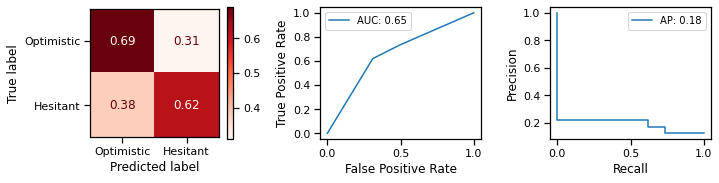

In [309]:
# same parameters that worked best on the reduced feature set, tried on the
# entire feature set

# I tested some max_features from 20 to 100 and they all made it worse

dt = DecisionTreeClassifier(min_impurity_decrease=0.02)

dt.fit(X_train_sm, y_train_sm)

eval_clf_model(dt, X_test_df, y_test, X_train_sm, 
               y_train_sm, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.78      0.84     51283
         1.0       0.25      0.53      0.34      7085

    accuracy                           0.75     58368
   macro avg       0.58      0.65      0.59     58368
weighted avg       0.84      0.75      0.78     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.92      0.78      0.85     17037
         1.0       0.26      0.54      0.35      2420

    accuracy                           0.75     19457
   macro avg       0.59      0.66      0.60     19457
weighted avg       0.84      0.75      0.79     19457


****************************** Score Comparison ******************************
Training F1 = 0.3364
Training Accuracy = 0.7483
Test F1 = 0.3505
Test Accuracy = 0.7526

****************************

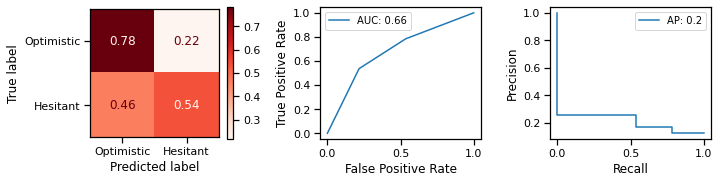

In [323]:
# How about not using SMOTEd data?
dt = DecisionTreeClassifier(min_impurity_decrease=0.02, class_weight='balanced')

dt.fit(X_train_df, y_train)

eval_clf_model(dt, X_test_df, y_test, X_train_df, 
               y_train, labels=labels)

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68     51283
         1.0       0.68      0.68      0.68     51283

    accuracy                           0.68    102566
   macro avg       0.68      0.68      0.68    102566
weighted avg       0.68      0.68      0.68    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79     17037
         1.0       0.22      0.62      0.33      2420

    accuracy                           0.68     19457
   macro avg       0.57      0.65      0.56     19457
weighted avg       0.84      0.68      0.73     19457


****************************** Score Comparison ******************************
Training F1 = 0.6825
Training Accuracy = 0.6826
Test F1 = 0.326
Test Accuracy = 0.6812

*****************************

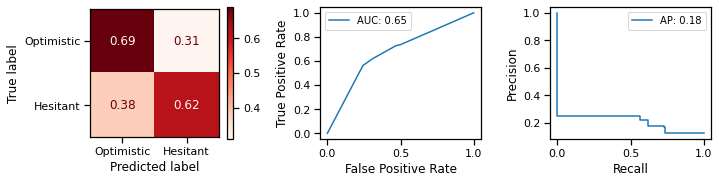

In [310]:
# How does my dt model do with bagging?
bag = BaggingClassifier(dt, random_state=42)
bag.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(bag, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

Having tried GridSearchCV optimizing for both f1 and recall, both recommended models that overfit to training and didn't perform as well on test as the one I stumbled upon and them iterated manually.

Now that I have a pretty good Decision Tree, I'll try with a few other ensemble methods to see if it can be improved.

### Random Forest
Since Random Forest is already randomly selecting features, I'll give it the whole feature space.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.74      0.71      0.72     51283
         1.0       0.72      0.75      0.73     51283

    accuracy                           0.73    102566
   macro avg       0.73      0.73      0.73    102566
weighted avg       0.73      0.73      0.73    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.93      0.72      0.81     17037
         1.0       0.23      0.60      0.33      2420

    accuracy                           0.70     19457
   macro avg       0.58      0.66      0.57     19457
weighted avg       0.84      0.70      0.75     19457


****************************** Score Comparison ******************************
Training F1 = 0.7342
Training Accuracy = 0.7286
Test F1 = 0.334
Test Accuracy = 0.7014

*****************************

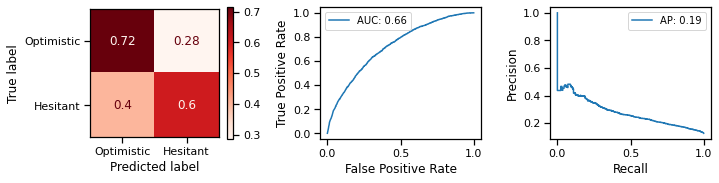

In [313]:
rf = RandomForestClassifier(min_impurity_decrease=0.02, n_estimators=300)

rf.fit(X_train_sm, y_train_sm)

eval_clf_model(rf, X_test_df, y_test, X_train_sm, 
               y_train_sm, labels=labels)

Even with number of estimators bulked up to 300, my tuned Decision Tree is still doing better than the Random Forest.

Just testing again here with letting sklearn fix the class imbalance instead of SMOTE to see if there is any difference.

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.59      0.72     51283
         1.0       0.20      0.74      0.31      7085

    accuracy                           0.61     58368
   macro avg       0.57      0.67      0.52     58368
weighted avg       0.85      0.61      0.67     58368


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.94      0.59      0.73     17037
         1.0       0.21      0.75      0.33      2420

    accuracy                           0.61     19457
   macro avg       0.58      0.67      0.53     19457
weighted avg       0.85      0.61      0.68     19457


****************************** Score Comparison ******************************
Training F1 = 0.3141
Training Accuracy = 0.6061
Test F1 = 0.3272
Test Accuracy = 0.6139

****************************

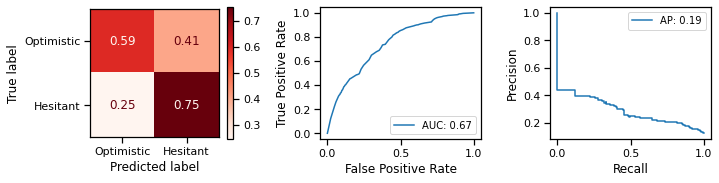

In [326]:
rf = RandomForestClassifier(n_estimators=300, min_impurity_decrease=0.02, 
                           class_weight='balanced')

rf.fit(X_train_df, y_train)

eval_clf_model(rf, X_test_df, y_test, X_train_df, 
               y_train, labels=labels)

### Gradient Boosting

My initial attempts at gradient boosting didn't improve on previous models.

I also tried the technique mentioned here to enable the ensemble model to determine an appropriate stopping point: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_early_stopping.html

****************************** Training Data ******************************
              precision    recall  f1-score   support

         0.0       0.89      0.94      0.92     51283
         1.0       0.94      0.89      0.91     51283

    accuracy                           0.92    102566
   macro avg       0.92      0.92      0.92    102566
weighted avg       0.92      0.92      0.92    102566


****************************** Test Data ******************************
              precision    recall  f1-score   support

         0.0       0.90      0.94      0.92     17037
         1.0       0.40      0.27      0.32      2420

    accuracy                           0.86     19457
   macro avg       0.65      0.61      0.62     19457
weighted avg       0.84      0.86      0.85     19457


****************************** Score Comparison ******************************
Training F1 = 0.913
Training Accuracy = 0.9154
Test F1 = 0.3223
Test Accuracy = 0.8599

*****************************

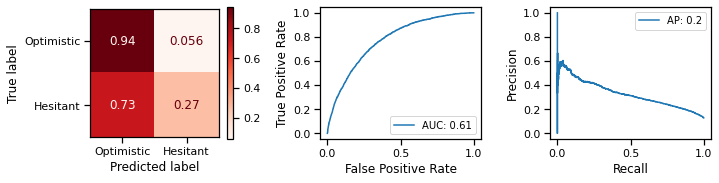

In [327]:
gbc = GradientBoostingClassifier(n_estimators=300, min_impurity_decrease=0.02, 
                                 n_iter_no_change=5, 
                                 tol=0.01, random_state=42)

gbc.fit(X_train_sm[to_keep], y_train_sm)

eval_clf_model(gbc, X_test_df[to_keep], y_test, X_train_sm[to_keep], 
               y_train_sm, labels=labels)

Since this approach is running until the accuracy score doesn't change over by more than the tolerance level over the last 5 trees, it's optimizing for accuracy, which isn't going to give a good result.